# Assignment #3
## Introduction
- **Objective:** Using Deep Learning concepts from **Session 7** and **Session 8**, create a challenger model to compare against the `model` and `model_2` built in **Session 5**. Name your new model `model_3`.
---

 ### **Notebook Structure:**
- 0. Import Data

- 1. Set-up for `model`
        - Features Selected
        - Features Engineered
        - model selection = LogisticRegression
        - Cross-Validation
        - model train/fit
        - model predictions

- 2. Set-up for `model_2`
        - Features Selected
        - Features Engineered
        - model selection = XGBClassifier *(using parameters from assignment #2)*
        - Selected Features using Recursive Features Elimination (RFE)
        - Cross-Validation
        - model train/fit
        - model predictions

- 3. Set-up for Challenger `model_3`
        - Features Selected
        - Features Engineered
        - Build base Deep Learning model
        - Explore model with Hyperparameter finetuning based on AUC scores
            - Evaluate and prevent overfitting
        - Build `model_3` from best parameters
        - model train/fit
        - model predictions

- 4. Model Comparisons
        - model evaluation metrics
        - ROC_AUC curve plot
        - Conclusion [advtangaes, disadvtages between models]

- 5. (Optional) model profiling with SHAP/LIME/SHAPASH


---



### Import libraries

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np

# Standard ML libraries for model preprocessing and evaluations
from sklearn.model_selection import cross_val_score, train_test_split

pd.set_option('max_colwidth', 800)
pd.set_option('display.max_columns', None)

# Working locally on Jupyter Notebook, parent folder is one folder up (using the folder structure shared at the beginning of the course)
path_python_material = ".."

---
# 0. Import Data

In [2]:
# Read data that was exported from previous session
df = pd.read_csv(f"{path_python_material}/data/2-intermediate/df_out_dsif5.csv")

# print shape of dataFrame
(print(f"shape of df = {df.shape}"))

df.head()

shape of df = (100000, 160)


id  loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0  167338079     4000.0       4000.0           4000.0   36 months     13.08   
1   71016917    24000.0      24000.0          24000.0   60 months      9.16   
2   39589826     5000.0       5000.0           5000.0   36 months     10.49   
3  134798709    24000.0      24000.0          24000.0   60 months     11.05   
4  127097355    14000.0      14000.0          14000.0   60 months     13.59   

   installment grade sub_grade       emp_title emp_length home_ownership  \
0       134.93     B        B5         cashier  10+ years       MORTGAGE   
1       500.07     B        B2             ABM    6 years           RENT   
2       162.49     B        B3          driver  10+ years       MORTGAGE   
3       522.42     B        B4             NaN        NaN       MORTGAGE   
4       322.79     C        C2  Shipping Clerk  10+ years       MORTGAGE   

   annual_inc verification_status   issue_d loan_status pymnt_plan  \
0     48000.0     Source Verified  Mar-2020     Current          n   
1     57000.0     Source Verified  Feb-2016     Current          n   
2     55000.0        Not Verified  Jan-2015  Fully Paid          n   
3     43500.0        Not Verified  Jun-2018     Current          n   
4     48000.0     Source Verified  Jan-2018  Fully Paid          n   

                                                                  url  \
0  https://lendingclub.com/browse/loanDetail.action?loan_id=167338079   
1   https://lendingclub.com/browse/loanDetail.action?loan_id=71016917   
2   https://lendingclub.com/browse/loanDetail.action?loan_id=39589826   
3  https://lendingclub.com/browse/loanDetail.action?loan_id=134798709   
4  https://lendingclub.com/browse/loanDetail.action?loan_id=127097355   

              purpose                    title zip_code addr_state    dti  \
0    home_improvement         Home improvement    115xx         NY  20.25   
1         credit_card  Credit card refinancing    708xx         LA  25.33   
2         credit_card  Credit card refinancing    347xx         FL   7.22   
3  debt_consolidation       Debt consolidation    443xx         OH  24.55   
4  debt_consolidation       Debt consolidation    681xx         NE  24.30   

   delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  \
0          1.0         Dec-2004           665.0            669.0   
1          0.0         Jan-2004           680.0            684.0   
2          0.0         Apr-2010           665.0            669.0   
3          0.0         Oct-2005           750.0            754.0   
4          0.0         Apr-2008           735.0            739.0   

   inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  \
0             0.0                    19.0                   110.0       4.0   
1             0.0                     NaN                     NaN      10.0   
2             0.0                     NaN                    61.0       7.0   
3             0.0                     NaN                     NaN      15.0   
4             1.0                     NaN                     NaN      16.0   

   pub_rec  revol_bal revol_util  total_acc initial_list_status  out_prncp  \
0      1.0     1988.0      82.8%       12.0                   w    3816.34   
1      0.0    22697.0      64.5%       24.0                   w    4333.29   
2      1.0     6001.0      52.6%        9.0                   f       0.00   
3      0.0     6573.0      12.1%       23.0                   w   16317.69   
4      0.0    11894.0      27.1%       23.0                   w       0.00   

   out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
0        3816.34    266.950000           266.95           183.66   
1        4333.29  25496.160000         25496.16         19666.71   
2           0.00   5846.672836          5846.67          5000.00   
3       16317.69  12000.930000         12000.93          7682.31   
4           0.00  16605.680000         16605.68         14000.

---
# 1. Set-up for Legacy/Initial `model`
- Features Selected
- Features Engineered
- model selection = LogisticRegression
- Cross-Validation
- model train/fit
- model predictions




In [3]:
# Legacy Model/Initial set-up

# 1.1 Feature Selection

# Feature section legacy (for simple 'model')
features = ['fico_range_high', 'fico_range_low', 'annual_inc', 'dti']
X = df[features]
y = df['loan_default']

# 1.2 Feature Engineering

# Create an imputer (replace missing values with the mean of the column)
# LogisticsRegression cannot handle missing values represented as NaN (Not a Number)
from sklearn.impute import SimpleImputer

# definie imputer method
imputer = SimpleImputer(strategy='mean')

# Fit the imputer
X = imputer.fit_transform(X)

df[features + ['loan_default']].head()

# 1.3 Model Selection
from sklearn.linear_model import LogisticRegression

# Legacy model
model = LogisticRegression()

# 1.4 Cross-Validation

# Performing 5-Fold Cross-Validation
cv_score_new = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(" \n ... Cross-Validation for Legacy model ... \n")
print(f"5-Fold CV Scores = {cv_score_new}")
print(f"Average - 5-Fold CV Scores = {cv_score_new.mean()}")
print(f"Median - 5-Fold CV Scores = {np.median(cv_score_new)} \n")

# 1.5 model training/fitting

# Data-splitting
# Split the data into training and testing sets by 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X,y train test datasets :")
for dframe, dlabel in zip([X_train, X_test, y_train, y_test], ['X_train', 'X_test', 'y_train', 'y_test']):
    print(f"Shape of {dlabel}: {dframe.shape}")

# Fit/Train Legacy model
model.fit(X_train, y_train)

# 1.6 Predictions & Probabilities 

# (will be used in Model Evaluations & Comparisons)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]


c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 
 ... Cross-Validation for Legacy model ... 

5-Fold CV Scores = [0.8762  0.87615 0.876   0.87615 0.87615]
Average - 5-Fold CV Scores = 0.8761299999999999
Median - 5-Fold CV Scores = 0.87615 

Shape of X,y train test datasets :
Shape of X_train: (80000, 4)
Shape of X_test: (20000, 4)
Shape of y_train: (80000,)
Shape of y_test: (20000,)


---
# 2. Set-up for `model_2`
- Features Selected
- Features Engineered
- model selection = XGBClassifier *(using parameters from assignment #2)*
- Selected Features using Recursive Features Elimination (RFE)
- Cross-Validation
- model train/fit
- model predictions

# Recap - Reasons for selecting features

- New `model_2` - Features added that can potentially relate to loan_defaults:
    - Initial features used in Legacy `model`:

        - 'fico_range_high', 
        - 'fico_range_low', 
        - 'annual_inc', 
        - 'dti' = A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

    - Additional Features:
        - 'annual_inc' = Annual income, indicator if they can afford to pay back the loan or not.
        - 'debt_to_income' = Ratio between 'loan_amnt and annual_inc. This does NOT! equate to 'dti',
        - 'total_bc_limit' = Total Bank Card high credit/ credit limit ~ a borrower's credit limit can entail if they have enough credit to make payments or not,
        - 'total_rec_late_fee' = Late fees received to date ~ late payment fees leads to more debt (i.e., bad debt), hence can lead to missing other payments,
        - 'int_rate_clean' = Interest rate can be a factor, hence high interest rate can lead to more difficulties in paying off a loan,
        - 'term' = Length to pay back the loan can show a categorical relationship, values are [36, 60 months] (might be too short for some with high interest and low annual_income),
        - 'loan_amnt' = loan_amount received, 
        - 'purpose' = ' Purpose of the loan, can show a categorical relationships, i.e., which purposes are most likely to lead to a loan_default, 
        - 'home_ownership' = Home_onwership status, can show a categorical relationships, i.e., does being a Renter or having a high mortgage lead to missing payments ? 

# Recap - Reasons for model_2 selection
- For this case, I will be selecting **XGBoost**, because it has the advantages of handling mix datatypes, isnce my data has categorical features. Also, it is known for being accurate for complex datasets.


| Algorithm                                        | Type                               | Best For                                               | Advantages                                                     | Disadvantages                                           | Covered in session |
| ------------------------------------------------ | ---------------------------------- | ------------------------------------------------------ | -------------------------------------------------------------- | ------------------------------------------------------- | ------------------ |
| Gradient Boosting (XGBoost)                      | Both                               | Accuracy, complex datasets                             | High accuracy, handles mixed data types                        | Requires careful tuning, can overfit                    | 6                  |





In [4]:
# Model_2 set-up

# 1.1 Feature Selection

# Feature section for model_2
# Splitting up the variables in two list, one for numeric, one for categorical

features_num = [
    'fico_range_high', 
    'fico_range_low', 
    'annual_inc', 
    'dti',
    'debt_to_income',
    'total_bc_limit',
    'total_rec_late_fee',
    'int_rate_clean',
    'loan_amnt', 
    ]

# Categorical variables
features_cat = [
    'term', 
    'purpose', 
    'home_ownership'
    ]

# New Dataframe for model_2
df_model_2 = df[features_num + features_cat + ['loan_default']].copy()

# Removing 103 records with annual_inc <= 1, 'debt_to_income = inf, dti = NaN
print("\n New DataFrame with dropped ~100 spurious records")

df_model_2_dropped = df_model_2[
    ~(df_model_2['debt_to_income'] == np.inf)
    &
    ~(df_model_2['annual_inc'] <= 1)
    &
    ~(pd.isnull(df_model_2['dti']) == True)].reset_index(drop=True)


# imputing NaNs for the feature 'total_bc_limit', replacing it with the mean value 
total_bc_limit_mean = df_model_2_dropped['total_bc_limit'].mean()
df_model_2_dropped['total_bc_limit'] = df_model_2_dropped['total_bc_limit'].apply(lambda x: total_bc_limit_mean if pd.isnull(x) == True else x)


# 1.2 Feature Engineering

# - Standarizing numerical values
# - OneHotEncoding Categorical Variables
# - Handle Class imbalances that are underrepresented, such as the categorical features and the numerical feature 'total_rec_late_fee'
from sklearn.preprocessing import StandardScaler

# preparing input variables/features for transformations
X_num = df_model_2_dropped[features_num]
X_cat = df_model_2_dropped[features_cat]

# target variable
y_2 = df_model_2_dropped['loan_default']

# definie standarizing numerical features method
scaler = StandardScaler()

# Transform numerical features
X_num_std = scaler.fit_transform(X_num)

# Convert tranformed numerical features into Dataframe
X_num_std = pd.DataFrame(X_num_std, columns=features_num)

# Encoding categorical features
# One-hot encoding
X_cat_ohe = pd.get_dummies(X_cat)

# bring Numerical and categorical features into one dataframe
X_2 = pd.concat([X_num_std, X_cat_ohe] , axis=1)

# Handling Class imbalances
from imblearn.over_sampling import SMOTE

# define method to handle imbalances = Synthetic Minority Oversampling Technique
# popular method to handle over-sampling minorities such as categorical data 
# e.g., less records for purpose == 'wedding', 'school', ...etc
smote = SMOTE()

X_2 , y_2 = smote.fit_resample(X_2, y_2)

# 1.3 Model Selection

# Importing XGBoost
from xgboost import XGBClassifier

# model_2 using best parameters from previous assignment
model_2 = XGBClassifier(
    n_estimators = 200,
    max_depth = 12,
    learning_rate = 0.1,
    enable_categorical = True,
    random_state = 42
)

# Data-splitting
# Split the data into training and testing sets by 80/20
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

print("Shape of X, y train test datasets :")
for dframe, dlabel in zip([X_train_2, X_test_2, y_train_2, y_test_2], ['X_train', 'X_test', 'y_train', 'y_test']):
    print(f"Shape of {dlabel}: {dframe.shape}")

# 1.4 Selecting Features using RFE

# Apply Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE

rfe = RFE(estimator=model_2,
          n_features_to_select=20, # number of features to select
          step=10,                  # step=10 ; remove 10 features at a time
          verbose = 3)

# Fit RFE to the training data
rfe.fit(X_train_2, y_train_2)

## Feature Selecting using Recursive Feature Elimination (RFE) for New model_2
selected_features = X_train_2.columns[rfe.support_] # rfe.support_ represents the mask of selected features (i.e. boolean indicator) 

print("\n Selected Features by RFE:")
print(f"Number of Selected Features {len(selected_features.values)} ")
print(f"\n {selected_features.values}")

# 1.5 Cross-Validation

# Performing 5-Fold Cross-Validation with selected features
cv_score_new_2 = cross_val_score(model_2, X_2[selected_features], y_2, cv=5, scoring='accuracy')
print(" \n ... Cross-Validation for model_2 ... \n")
print(f"5-Fold CV Scores = {cv_score_new_2}")
print(f"Average - 5-Fold CV Scores = {cv_score_new_2.mean()}")
print(f"Median - 5-Fold CV Scores = {np.median(cv_score_new_2)} \n")

# 1.6 model training/fitting

# Fit/Train Legacy model
model_2.fit(X_train_2[selected_features], y_train_2)

# 1.7 Predictions & Probabilities 
# (will be used in section 6. Model Evaluations & Comparisons)
y_pred_2 = model_2.predict(X_test_2[selected_features])
y_prob_2 = model_2.predict_proba(X_test_2[selected_features])[:,1]



 New DataFrame with dropped ~100 spurious records


c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Shape of X, y train test datasets :
Shape of X_train: (140036, 31)
Shape of X_test: (35010, 31)
Shape of y_train: (140036,)
Shape of y_test: (35010,)
Fitting estimator with 31 features.
Fitting estimator with 21 features.

 Selected Features by RFE:
Number of Selected Features 20 

 ['fico_range_high' 'annual_inc' 'debt_to_income' 'total_rec_late_fee'
 'int_rate_clean' 'loan_amnt' 'purpose_car' 'purpose_credit_card'
 'purpose_debt_consolidation' 'purpose_home_improvement' 'purpose_house'
 'purpose_major_purchase' 'purpose_medical' 'purpose_moving'
 'purpose_other' 'purpose_renewable_energy' 'purpose_small_business'
 'purpose_vacation' 'purpose_wedding' 'home_ownership_RENT']
 
 ... Cross-Validation for model_2 ... 

5-Fold CV Scores = [0.67672094 0.91493616 0.92030621 0.92153446 0.91827816]
Average - 5-Fold CV Scores = 0.8703551845471914
Median - 5-Fold CV Scores = 0.9182781570453312 



---
# 3. Set-up for `model_3` the Challenger model
- Features Selected
- Features Engineered
- Build base Deep Learning model
- Explore model with Hyperparameter finetuning based on AUC scores
    - Evaluate and prevent overfitting
- Build `model_3` from best parameters
- model train/fit
- model predictions

## Recap - Reasons for selecting features for model, model_, model_3

- New Challenger `model_3` - Features added that can potentially relate to loan_defaults:
    - Initial features used in Legacy `model`:
        - 'fico_range_high', 
        - 'fico_range_low', 
        - 'annual_inc', 
        - 'dti' = A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

    - New `model_2` - Additional Features:
        - 'annual_inc' = Annual income, indicator if they can afford to pay back the loan or not.
        - 'debt_to_income' = Ratio between 'loan_amnt and annual_inc. This does NOT! equate to 'dti',
        - 'total_bc_limit' = Total Bank Card high credit/ credit limit ~ a borrower's credit limit can entail if they have enough credit to make payments or not,
        - 'total_rec_late_fee' = Late fees received to date ~ late payment fees leads to more debt (i.e., bad debt), hence can lead to missing other payments,
        - 'int_rate_clean' = Interest rate can be a factor, hence high interest rate can lead to more difficulties in paying off a loan,
        - 'term' = Length to pay back the loan can show a categorical relationship, values are [36, 60 months] (might be too short for some with high interest and low annual_income),
        - 'loan_amnt' = loan_amount received, 
        - 'purpose' = ' Purpose of the loan, can show a categorical relationships, i.e., which purposes are most likely to lead to a loan_default, 
        - 'home_ownership' = Home_onwership status, can show a categorical relationships, i.e., does being a Renter or having a high mortgage lead to missing payments ? 

    - Challeger model_3 - Additional Features added to both inital and model_2, that can pontentially relate/predict loan_defaults to be [True, False]:
        - 'max_bal_bc' = Maximum current balance owed on all revolving accounts, can entail if a borrower is capable of paying off a loan
        - 'total_bc_limit' = Total bankcard high credit/credit limit, borrowers credit limit their pay-back credibility for a loan.
        - 'num_actv_bc_tl' = Number of currently active bankcard accounts, can show activity of money flow in a borrower's account, which can tell us how much they are capable of paying back a loan
        - 'num_bc_sats' = Number of satisfactory bankcard accounts, can show satisfactory activity of money flow in a borrower's accounts, which can tell us how much they are capable of paying back a loan
        - 'tot_cur_bal = 'Total Current balance of all acounts, can determine if they are capable of paying back a loan or not


## Model_3 (Deep Learning)
- For this case, I will be selecting **Deep Learning** model with the following Non-Linear Activation Functions;.

- **Activation function** determines the output of a neuron given an input or set of inputs. They introduce non-linearity into the network, allowing it to learn from errors and improve.

**Common NON LINEAR activation functions:**
| **Activation Function**    | **Description**                                                                                       |
|----------------------------|-------------------------------------------------------------------------------------------------------|
| **Sigmoid (Logistic)**      | Scales outputs between 0 and 1; common for binary classification but suffers from vanishing 
| **ReLU**                    | Popular for simplicity and speed; becomes linear when <= 0, limiting learning.                        |
| **Leaky ReLU**              | Introduces a negative slope for values below 0, solving the zeroing-out problem.                      |

 

- **Loss function:** Measures the difference between the predicted output and the actual target. The goal is to minimize this loss during training.
  - This case, we will use **binary_crossentropy** ~ ideal for binary classification tasks.
  
- **Optimization algorithms:** Methods used to minimize the loss function by adjusting the network's weights.

  - **Adam** is a popular stochastic gradient descent method that is computationally efficient, has little memory requirement and is well suited for problems that are large in terms of data/parameters.

- **Number of layers and neurons:** More layers and neurons can capture more complex patterns but may lead to overfitting if not managed properly.
    - To prevent overffting, we will assess multiple values and score based on AUC. 

- **Regularization:** 
    - L2 regularization:  help prevent overfitting by adding constraints to the model.
        - Adds the sum of the squared values of the model weights to the loss function, pushing weights towards smaller values without necessarily making them zero, generally preferred for most deep learning tasks. 
    
    - L1 regularization: Adds the sum of the absolute values of the model weights to the loss function, encouraging sparsity by forcing some weights to become zero, which can be useful for feature selection

    - Our Case: We will choose **L2**, as the data has some sparsity with the multiple categorical features, and L1 will force 'more' sparsity, which we do not want.
---

## Python Frameworks for Neural Networks
- **TensorFlow and Keras:** Developed by Google, Keras is a high-level API that runs on top of TensorFlow. It's user-friendly and 




In [5]:
# Select few features for NEW.! model_3

# 1.1 Feature Selection
# Splitting up the variables in two list, one for numeric, one for categorical

features_num_3 = [
    'fico_range_high', 
    'fico_range_low', 
    'annual_inc', 
    'dti',

    'debt_to_income',
    'total_rec_late_fee',
    'int_rate_clean',
    'loan_amnt', 

    'max_bal_bc',
    'total_bc_limit',
    'num_actv_bc_tl',
    'num_bc_sats',
    'tot_cur_bal'

    ]

# Categorical variables
features_cat_3 = [
    'purpose', 
    'home_ownership'
    ]

# New Dataframe for model_3
df_model_3 = df[features_num_3 + features_cat_3 + ['loan_default']].copy()

# Removing 103 records with annual_inc <= 1, 'debt_to_income = inf, dti = NaN
print("\n New DataFrame with dropped ~100 spurious records")

df_model_3_dropped = df_model_3[
    ~(df_model_3['debt_to_income'] == np.inf)
    &
    ~(df_model_3['annual_inc'] <= 1)
    &
    ~(pd.isnull(df_model_3['dti']) == True)].reset_index(drop=True)


# preparing input variables/features for transformations
X_num_3 = df_model_3_dropped[features_num_3]
X_cat_3 = df_model_3_dropped[features_cat_3]

# target variable
y_3 = df_model_3_dropped['loan_default']

display( pd.concat([X_num_3 , X_cat_3 , y_3] , axis=1) )



 New DataFrame with dropped ~100 spurious records


fico_range_high  fico_range_low  annual_inc    dti  debt_to_income  \
0                669.0           665.0     48000.0  20.25        0.083333   
1                684.0           680.0     57000.0  25.33        0.421053   
2                669.0           665.0     55000.0   7.22        0.090909   
3                754.0           750.0     43500.0  24.55        0.551724   
4                739.0           735.0     48000.0  24.30        0.291667   
...                ...             ...         ...    ...             ...   
99892            674.0           670.0     60000.0  17.98        0.055000   
99893            719.0           715.0    150000.0  13.13        0.040000   
99894            664.0           660.0     48000.0  27.79        0.208333   
99895            769.0           765.0     90000.0  27.58        0.118056   
99896            719.0           715.0     45000.0  22.27        0.333333   

       total_rec_late_fee  int_rate_clean  loan_amnt  max_bal_bc  \
0                     0.0           13.08     4000.0         0.0   
1                     0.0            9.16    24000.0      2137.0   
2                     0.0           10.49     5000.0         NaN   
3                     0.0           11.05    24000.0      2223.0   
4                     0.0           13.59    14000.0      3907.0   
...                   ...             ...        ...         ...   
99892                 0.0           11.49     3300.0     12439.0   
99893                 0.0            9.80     6000.0      3420.0   
99894                 0.0           19.99    10000.0      2401.0   
99895                 0.0            8.81    10625.0      9371.0   
99896                 0.0            8.19    15000.0      9928.0   

       total_bc_limit  num_actv_bc_tl  num_bc_sats  tot_cur_bal  \
0                 0.0             0.0          0.0     259024.0   
1             13000.0             3.0          5.0      61815.0   
2             10000.0             3.0          3.0     159131.0   
3             49000.0             6.0         11.0     104590.0   
4             28800.0             4.0          5.0      90253.0   
...               ...             ...          ...          ...   
99892         32800.0             4.0          5.0      28437.0   
99893         35800.0             6.0         15.0      38741.0   
99894          9400.0             4.0          4.0      21445.0   
99895         53400.0             7.0          9.0     418255.0   
99896         17000.0             3.0          3.0     176739.0   

                  purpose home_ownership  loan_default  
0        home_improvement       MORTGAGE         False  
1             credit_card           RENT         False  
2             credit_card       MORTGAGE         False  
3      debt_consolidation       MORTGAGE         False  
4      debt_consolidation       MORTGAGE         False  
...                   ...            ...           ...  
99892               other       MORTGAGE         False  
99893      major_purchase           RENT         False  
99894  debt_consolidation           RENT          True  
99895  debt_consolidation       MORTGAGE         False  
99896         credit_card       MORTGAGE          True  

[99897 rows x 16 columns]

### Inspecting Stats of Dataframe for numerical features (i.e., if they are fully populated)

In [6]:
X_num_3.describe()

fico_range_high  fico_range_low    annual_inc           dti  \
count     99897.000000    99897.000000  9.989700e+04  99897.000000   
mean        704.626285      700.626045  8.011169e+04     19.332446   
std          33.796248       33.795218  8.723142e+04     17.278024   
min         644.000000      640.000000  3.000000e+01     -1.000000   
25%         679.000000      675.000000  4.750000e+04     12.060000   
50%         699.000000      695.000000  6.600000e+04     18.100000   
75%         724.000000      720.000000  9.500000e+04     24.870000   
max         850.000000      845.000000  1.099920e+07    999.000000   

       debt_to_income  total_rec_late_fee  int_rate_clean     loan_amnt  \
count    99897.000000        99897.000000    99897.000000  99897.000000   
mean         0.246108            1.749869       13.055647  15326.584132   
std          3.025466           13.417988        4.875865   9464.516754   
min          0.000323            0.000000        5.310000    700.000000   
25%          0.123457            0.000000        9.170000   8000.000000   
50%          0.200000            0.000000       12.490000  13000.000000   
75%          0.298701            0.000000       16.010000  20000.000000   
max        820.512821          819.200000       30.990000  40000.000000   

         max_bal_bc  total_bc_limit  num_actv_bc_tl   num_bc_sats  \
count  70253.000000    98119.000000    97459.000000  97846.000000   
mean    5997.514284    24823.297812        3.703147      4.859003   
std     5511.581147    24433.219526        2.380818      3.116651   
min        0.000000        0.000000        0.000000      0.000000   
25%     2347.000000     8900.000000        2.000000      3.000000   
50%     4568.000000    17500.000000        3.000000      4.000000   
75%     7909.000000    32500.000000        5.000000      6.000000   
max    94246.000000   425150.000000       50.000000     59.000000   

        tot_cur_bal  
count  9.745900e+04  
mean   1.459125e+05  
std    1.644383e+05  
min    0.000000e+00  
25%    2.972900e+04  
50%    8.093700e+04  
75%    2.180650e+05  
max    4.035706e+06

#### Observation
- We can see the numerical features 'max_bal_bc', 'total_bc_limit', 'num_activ_bc_tl', 'num_bc_sats', and 'tot_cur_bal' are NOT fully populated

- We will replace the NaNs and imput the mean for these fields.


In [7]:
from sklearn.impute import SimpleImputer

# definie imputer method
imputer = SimpleImputer(strategy='mean')

# Fit the imputer
X_num_3 = imputer.fit_transform(X_num_3)

X_num_3 = pd.DataFrame(X_num_3, columns=features_num_3)

X_num_3.describe()

fico_range_high  fico_range_low    annual_inc           dti  \
count     99897.000000    99897.000000  9.989700e+04  99897.000000   
mean        704.626285      700.626045  8.011169e+04     19.332446   
std          33.796248       33.795218  8.723142e+04     17.278024   
min         644.000000      640.000000  3.000000e+01     -1.000000   
25%         679.000000      675.000000  4.750000e+04     12.060000   
50%         699.000000      695.000000  6.600000e+04     18.100000   
75%         724.000000      720.000000  9.500000e+04     24.870000   
max         850.000000      845.000000  1.099920e+07    999.000000   

       debt_to_income  total_rec_late_fee  int_rate_clean     loan_amnt  \
count    99897.000000        99897.000000    99897.000000  99897.000000   
mean         0.246108            1.749869       13.055647  15326.584132   
std          3.025466           13.417988        4.875865   9464.516754   
min          0.000323            0.000000        5.310000    700.000000   
25%          0.123457            0.000000        9.170000   8000.000000   
50%          0.200000            0.000000       12.490000  13000.000000   
75%          0.298701            0.000000       16.010000  20000.000000   
max        820.512821          819.200000       30.990000  40000.000000   

         max_bal_bc  total_bc_limit  num_actv_bc_tl   num_bc_sats  \
count  99897.000000    99897.000000    99897.000000  99897.000000   
mean    5997.514284    24823.297812        3.703147      4.859003   
std     4622.016621    24214.805846        2.351586      3.084491   
min        0.000000        0.000000        0.000000      0.000000   
25%     3234.000000     9000.000000        2.000000      3.000000   
50%     5997.514284    17900.000000        3.000000      4.000000   
75%     6164.000000    32100.000000        5.000000      6.000000   
max    94246.000000   425150.000000       50.000000     59.000000   

        tot_cur_bal  
count  9.989700e+04  
mean   1.459125e+05  
std    1.624194e+05  
min    0.000000e+00  
25%    3.043600e+04  
50%    8.628900e+04  
75%    2.141800e+05  
max    4.035706e+06

### - Now all numerical fields are populated

### - As for categorical features, we have used them previously, and know they are fully populated, and are consistent with their format, hence no inspecton needed. 

### - Now, we will inspect the distributions of the numerical fields to decide if we want to StandardScale or MinMax tranform. 

- **NOTE**  
    - **StandardScaler :** 
        - if we expect the numerical fields to follow a normal distribution
        - Preferred for most deep learning models as it assumes a normal distribution with zero mean and unit variance. 
        - Less affected by outliers compared to MinMaxScaler. 
        - Works well when features have different scales. 

    - **MinMaxScaler :** 
        - if the boundaries (i.e., the minimum and maximum) values are well known. *(This can be potentially applicable to Bank Card features)*
        - Useful when you need your data to be within a specific range, like between 0 and 1. 
        - Can be significantly impacted by outliers. 
        - Might be suitable for certain applications like image processing where pixel values are already bounded. 

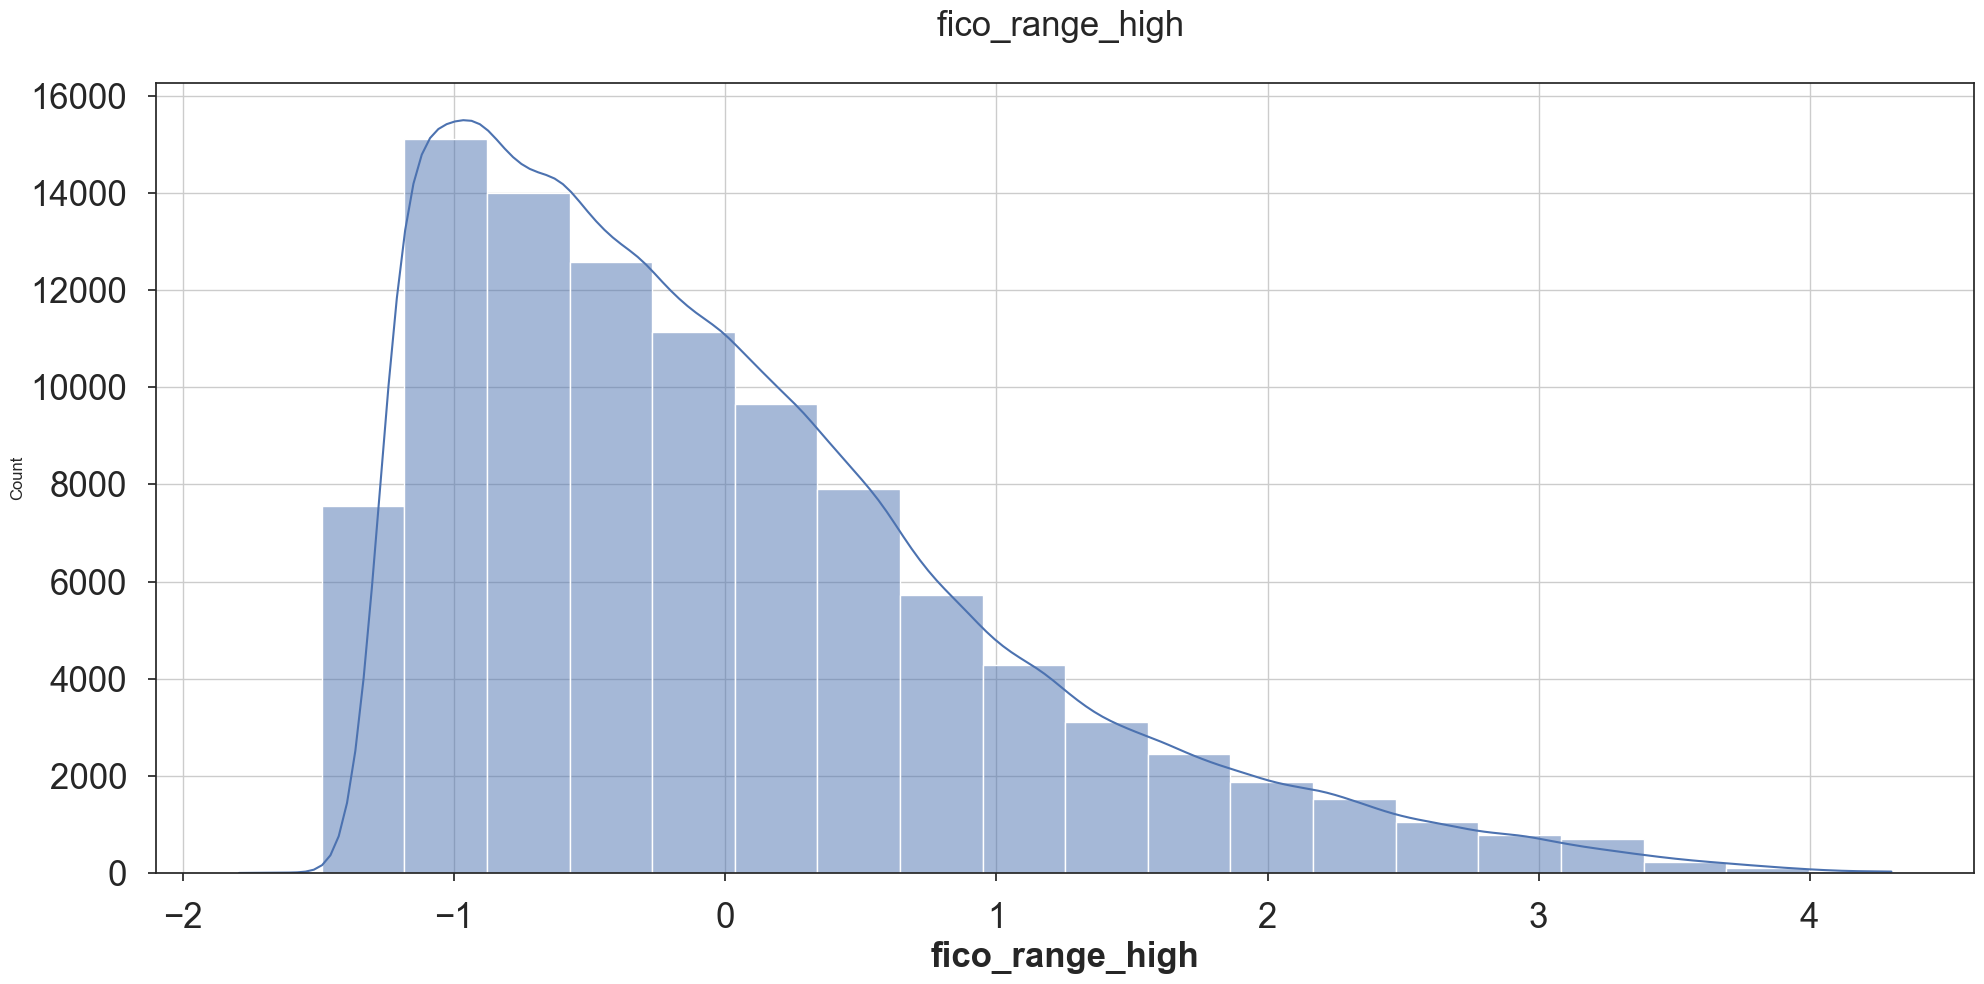

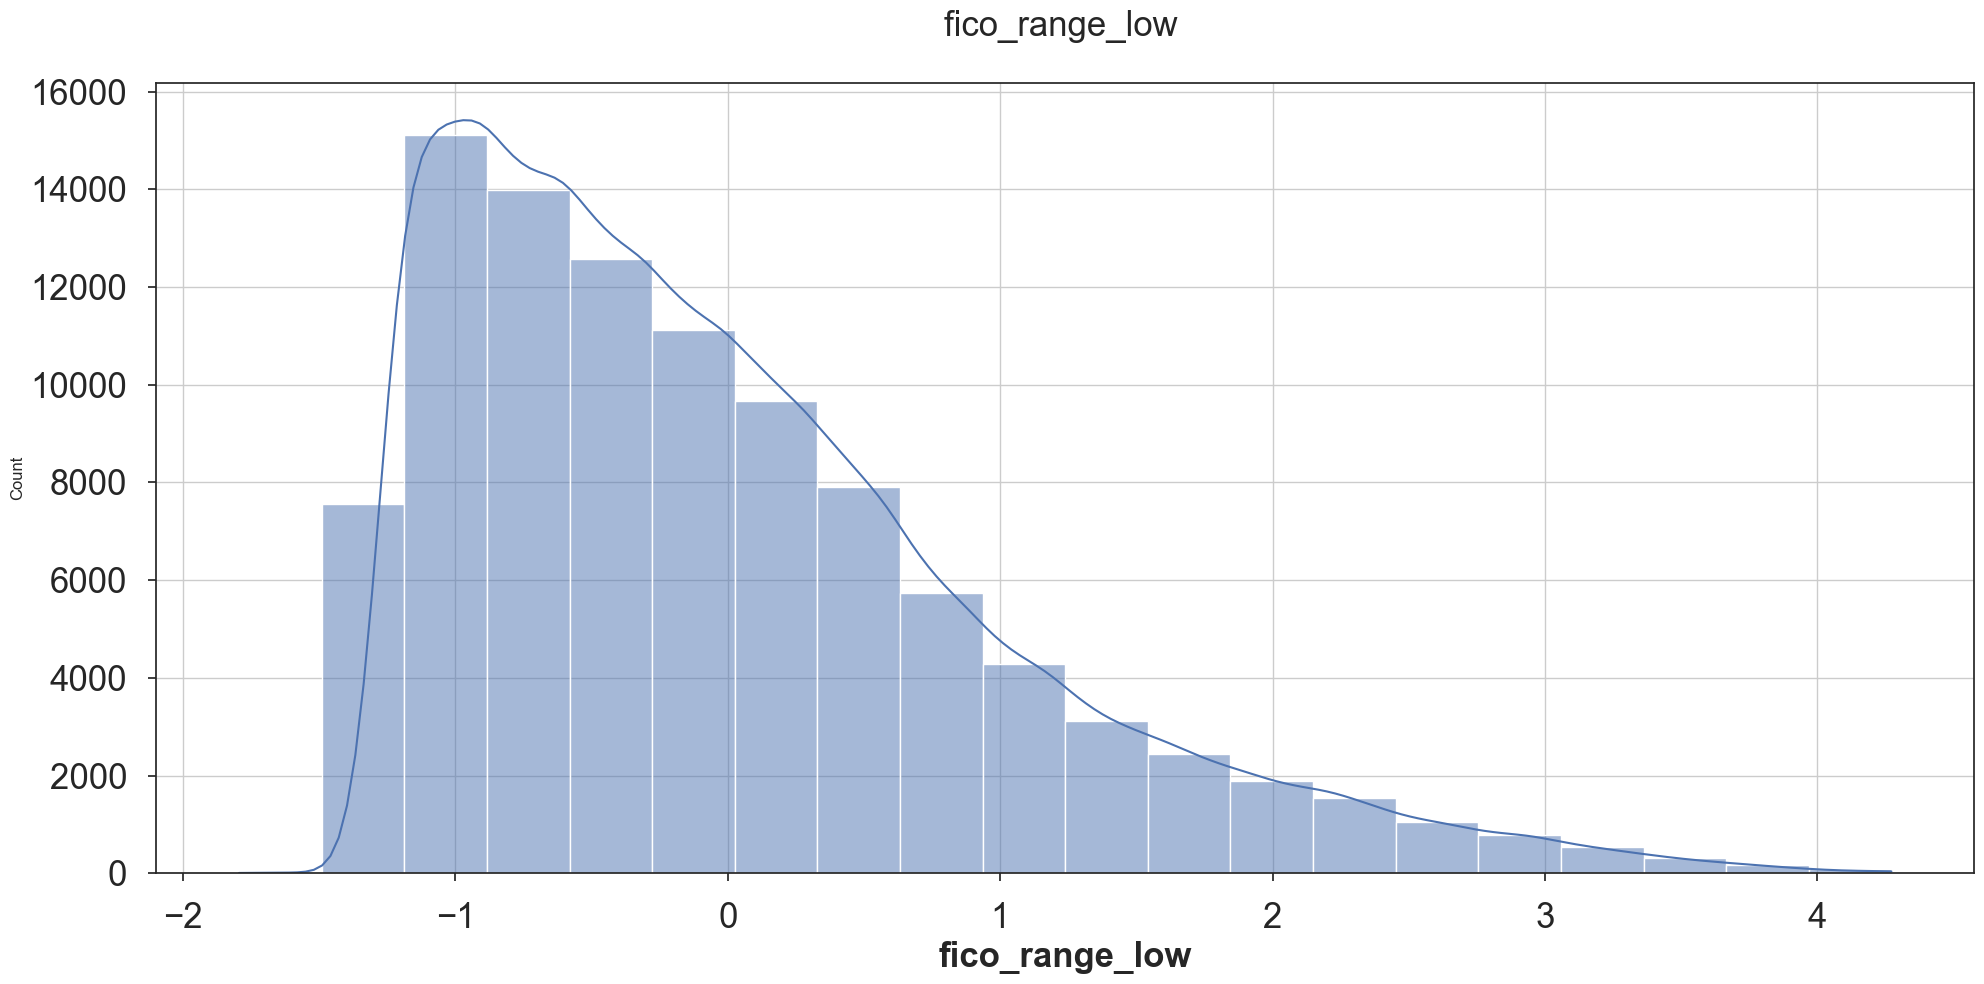

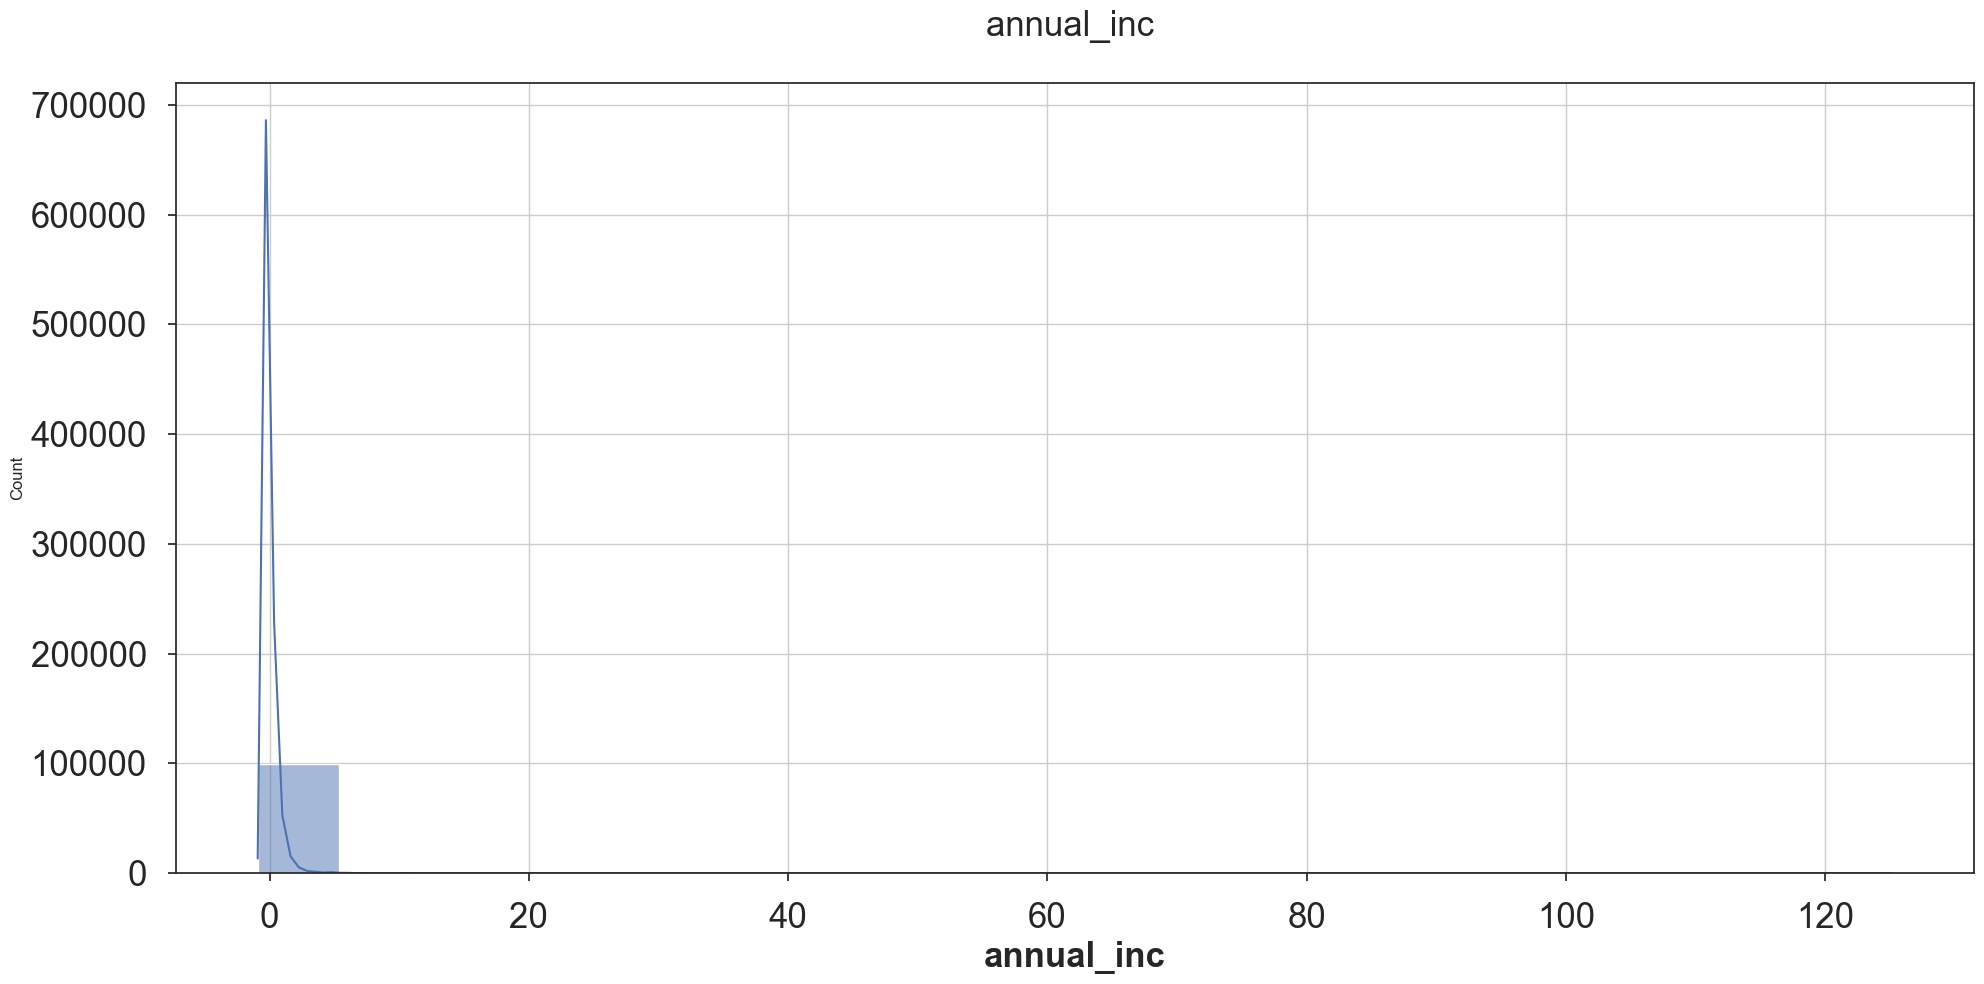

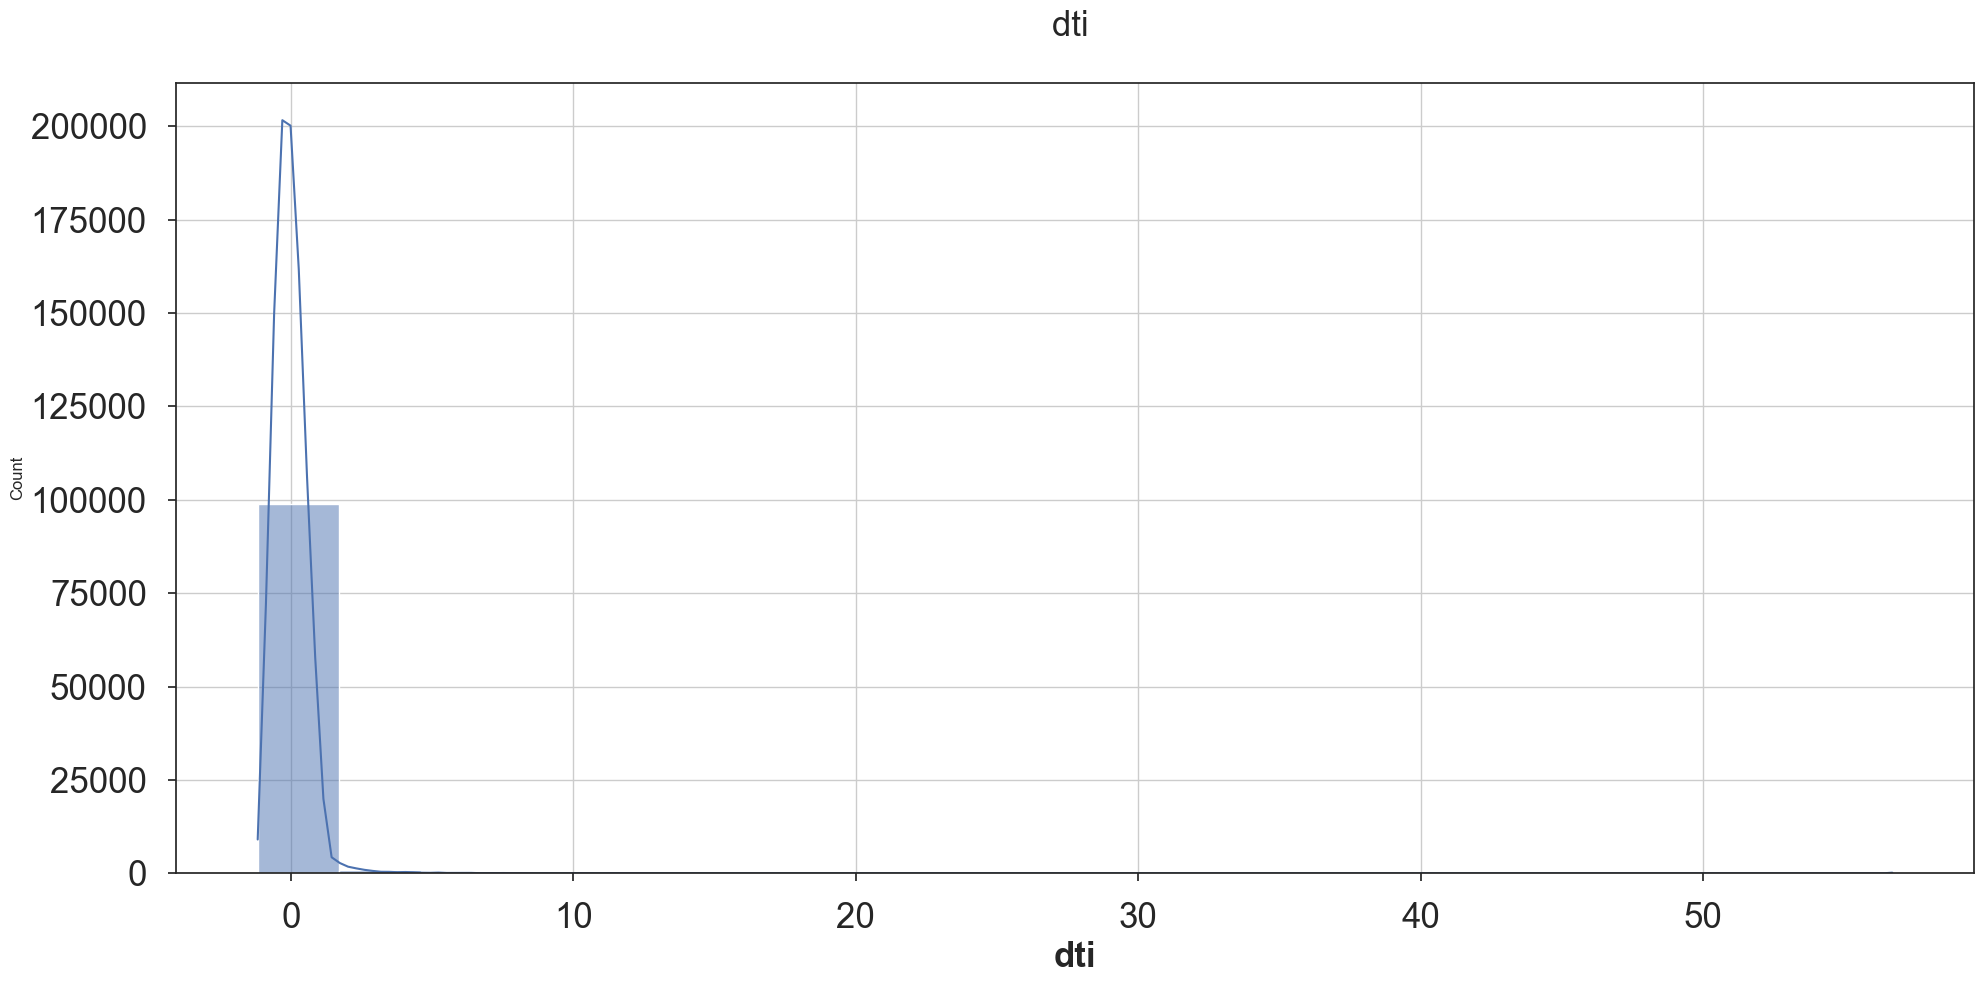

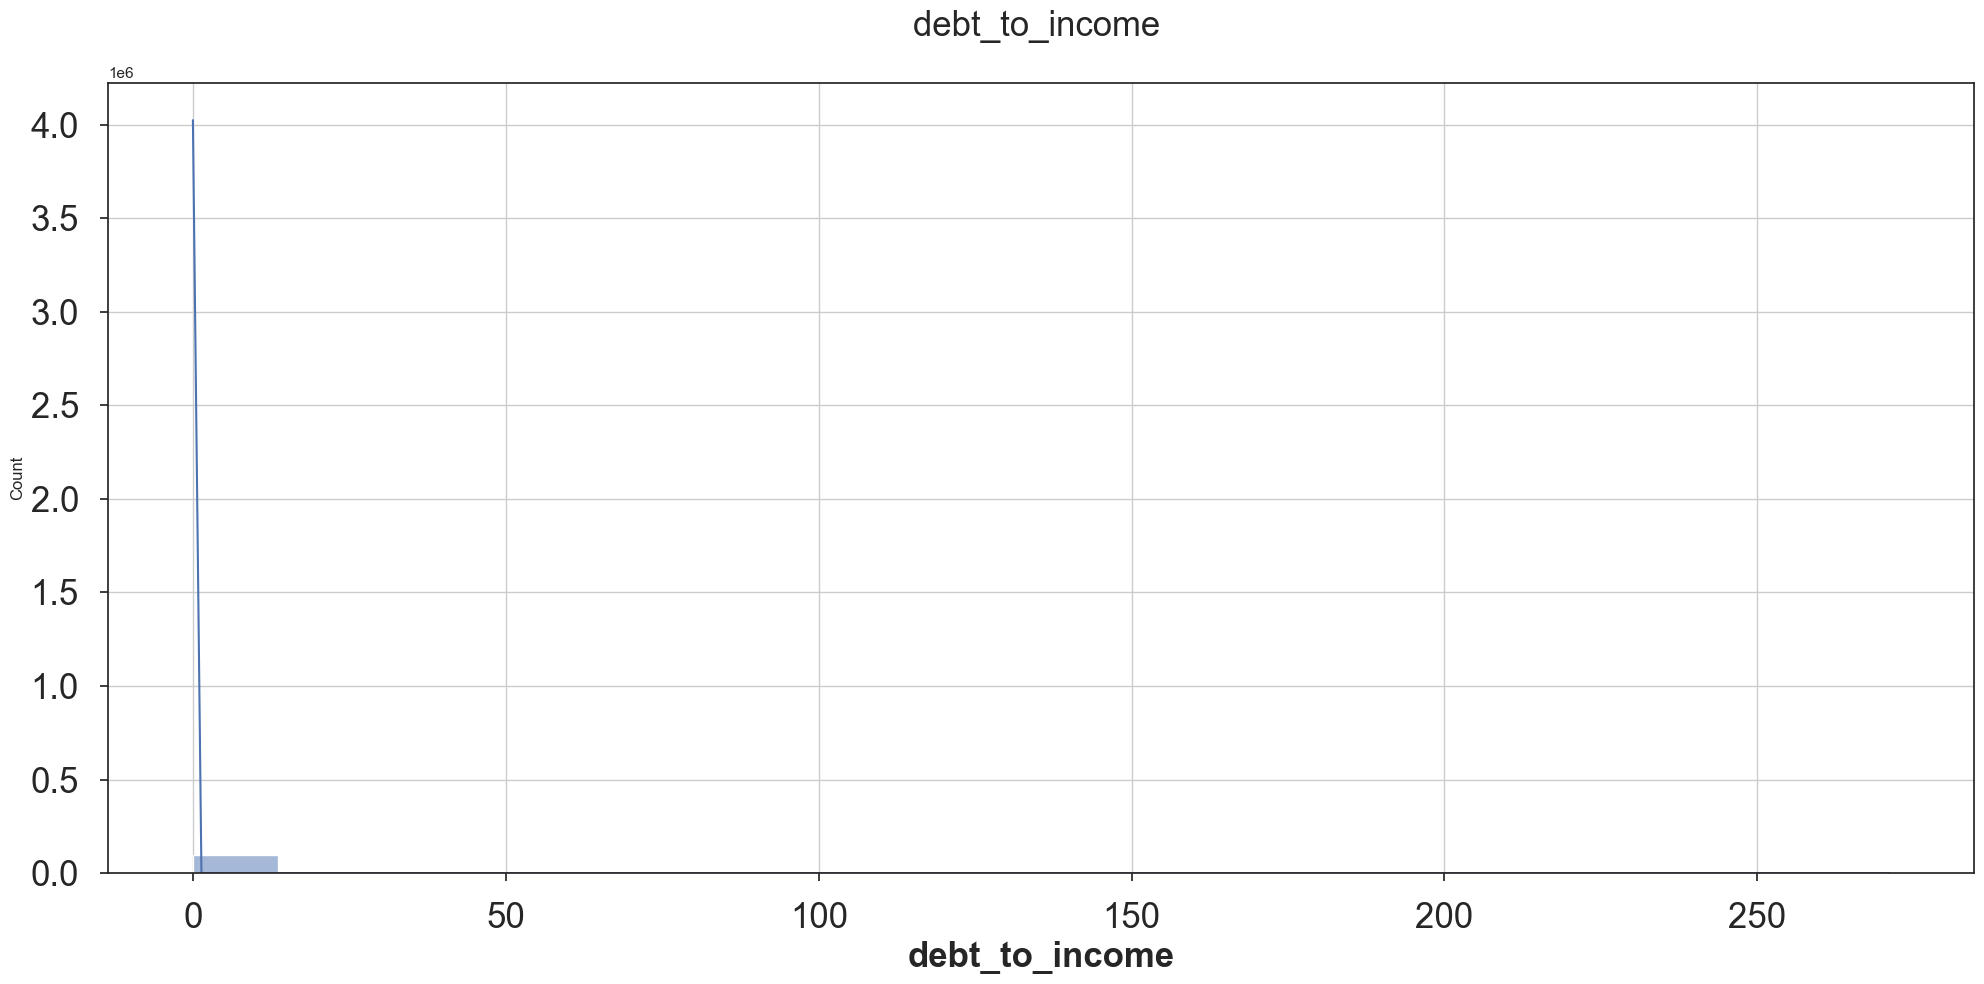

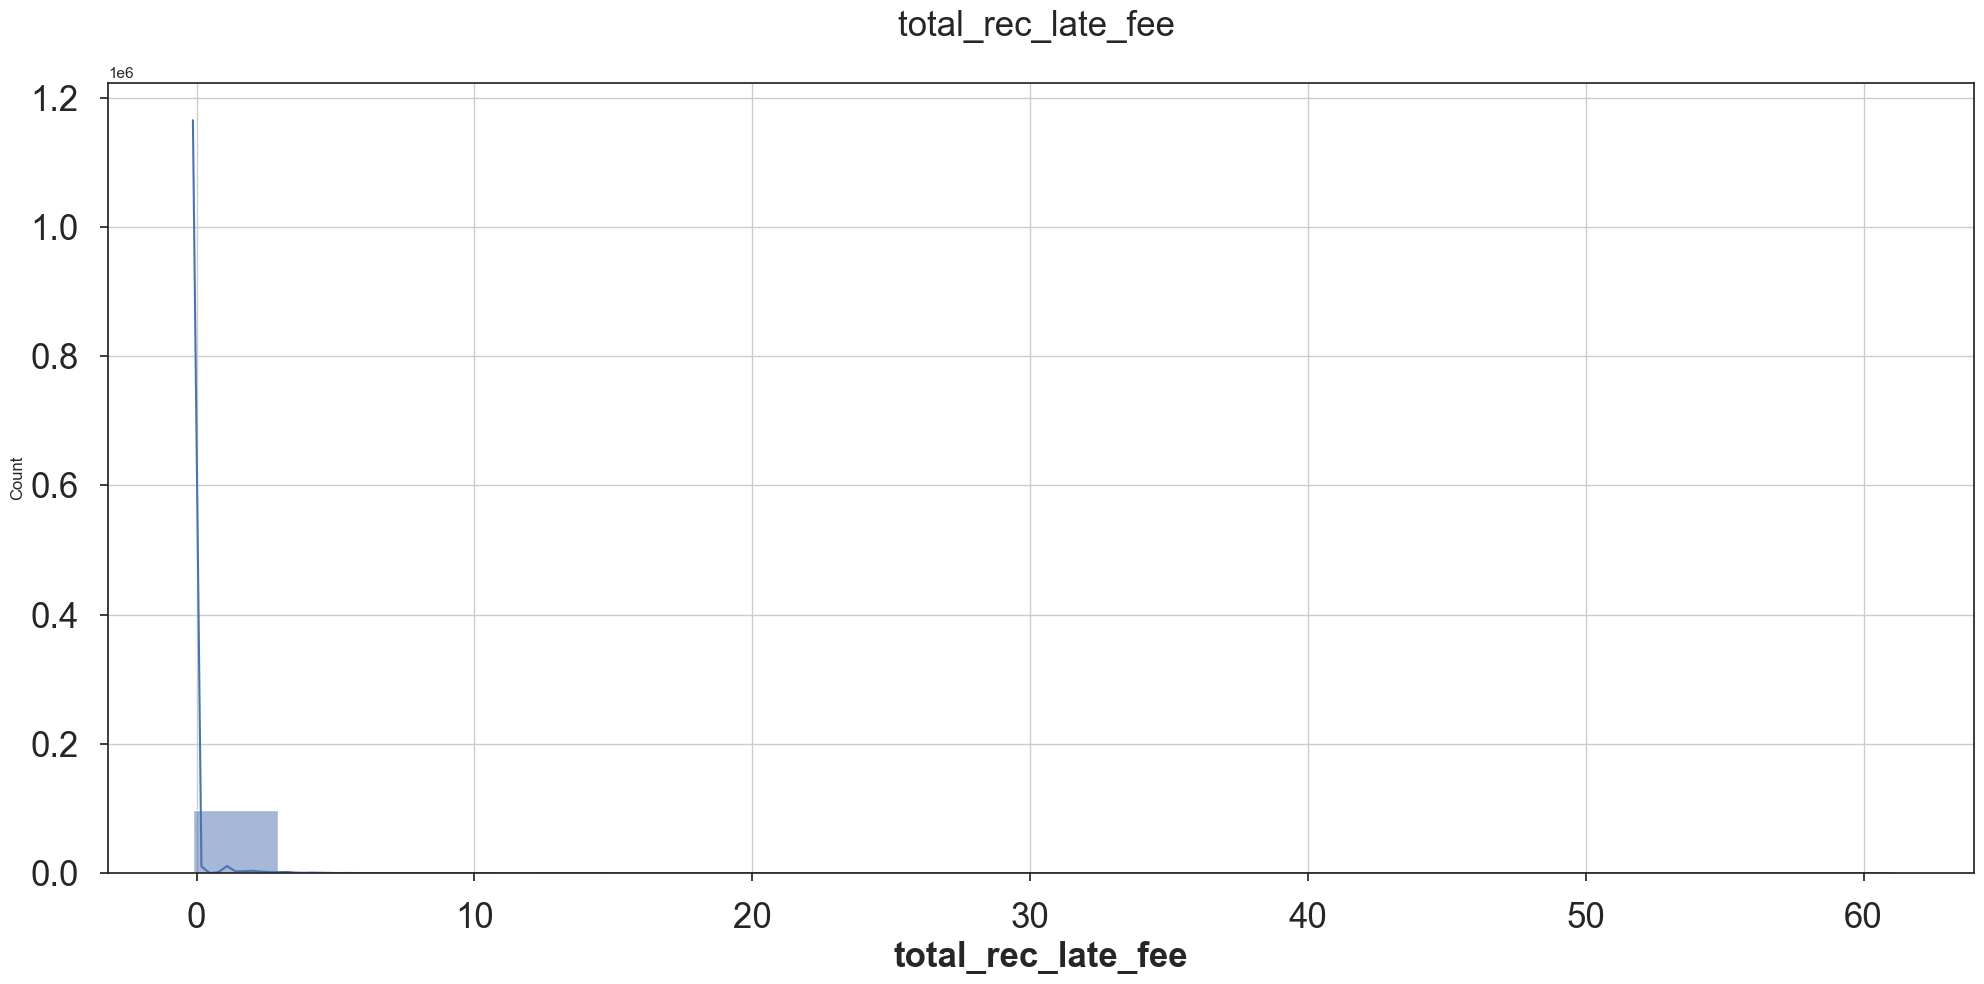

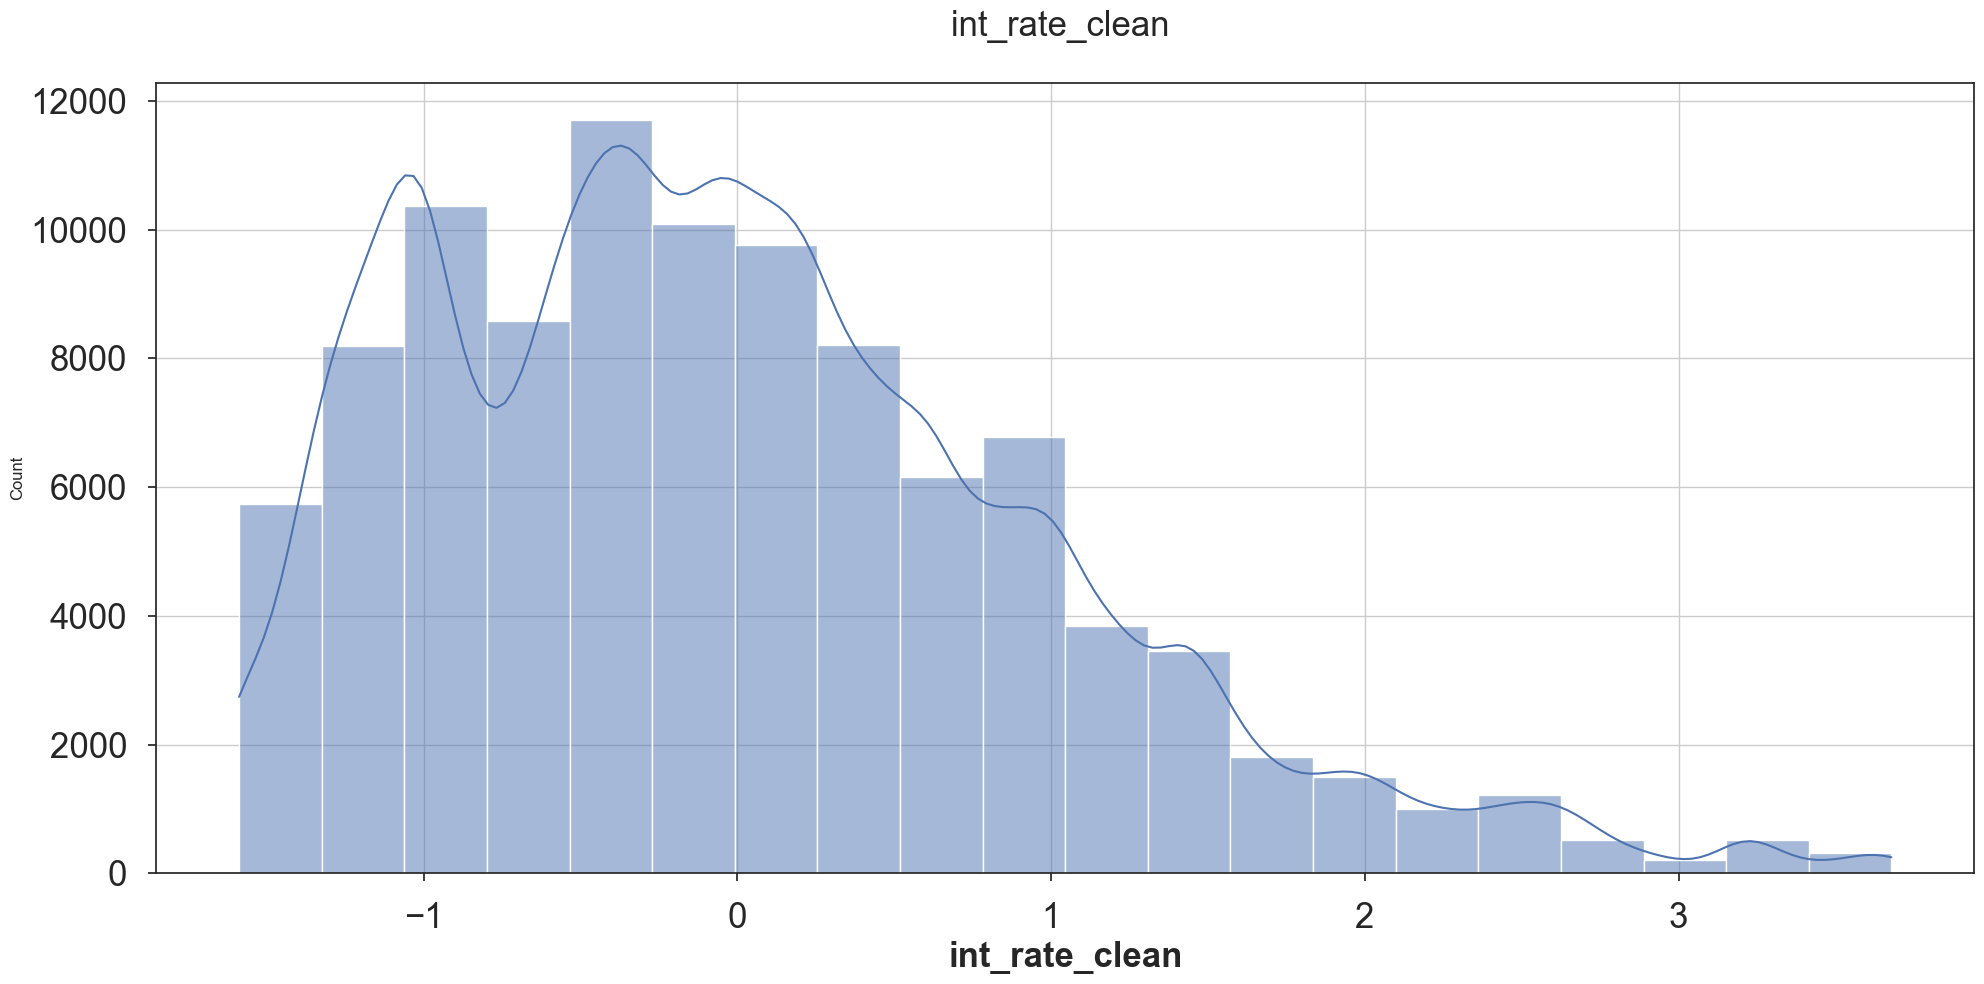

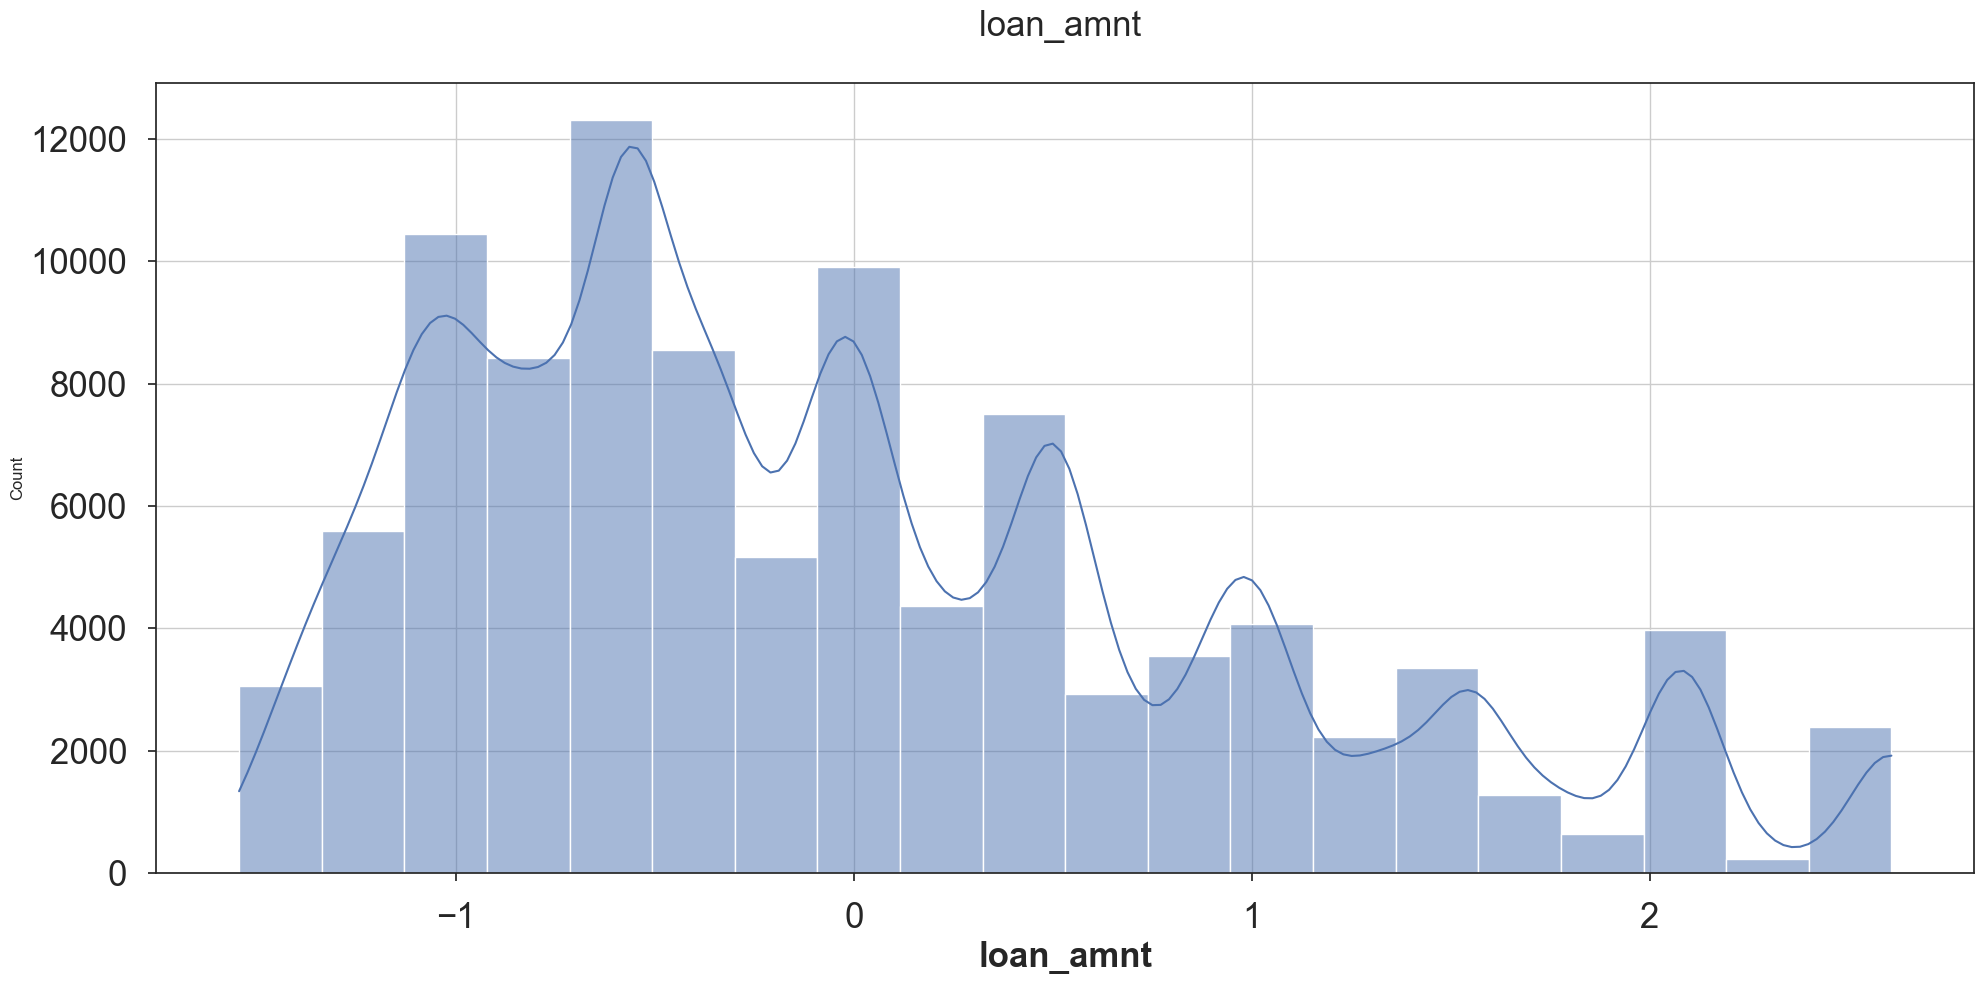

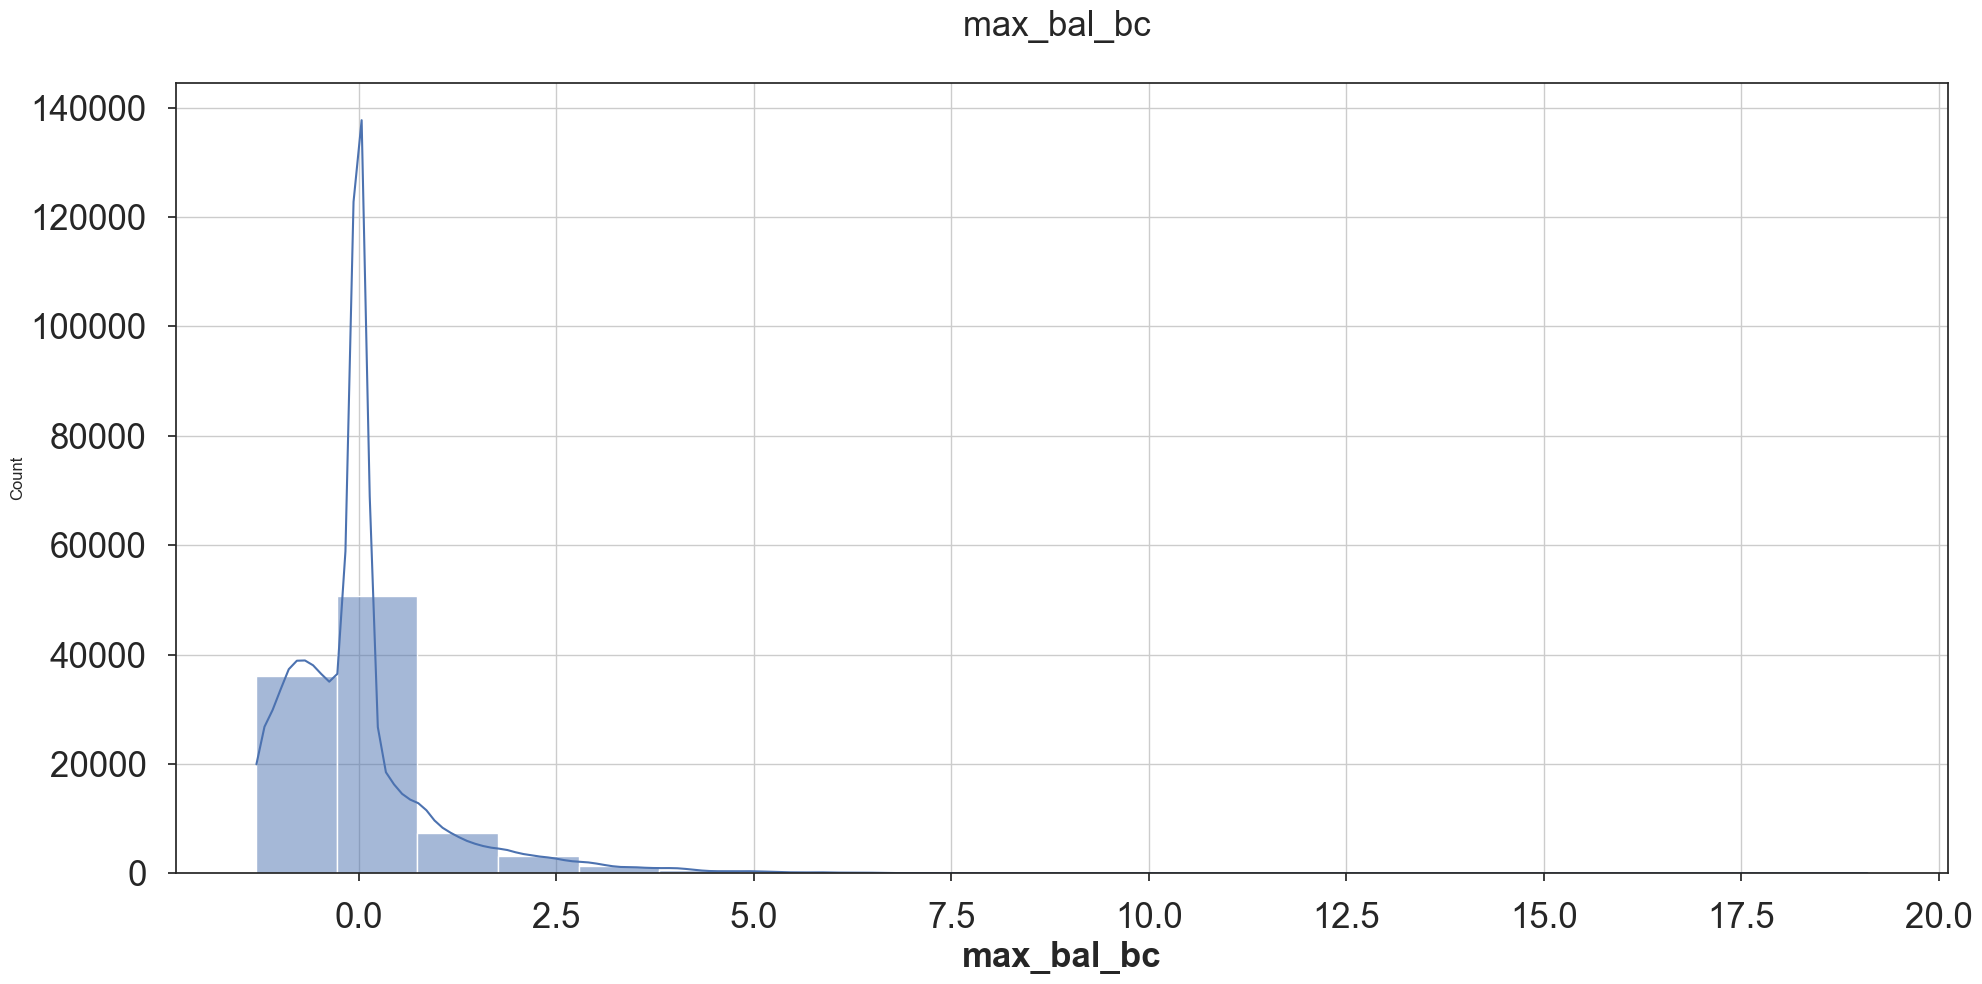

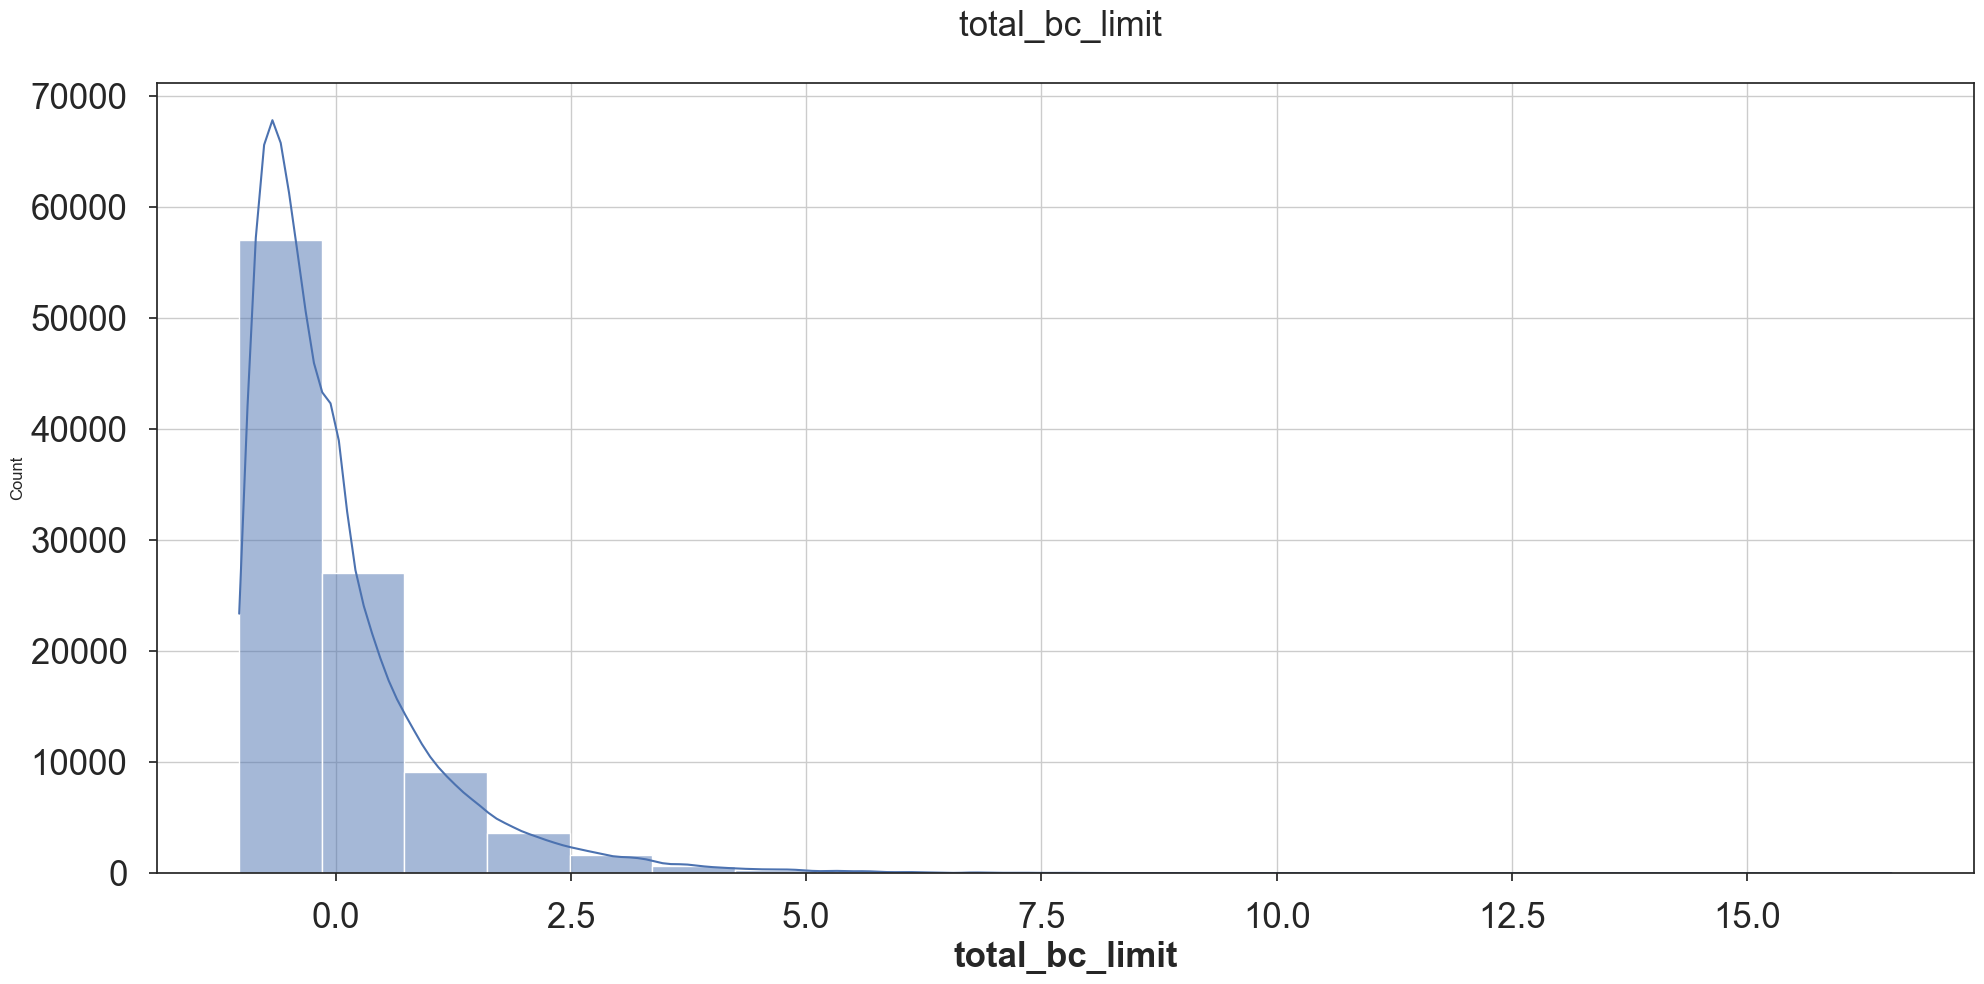

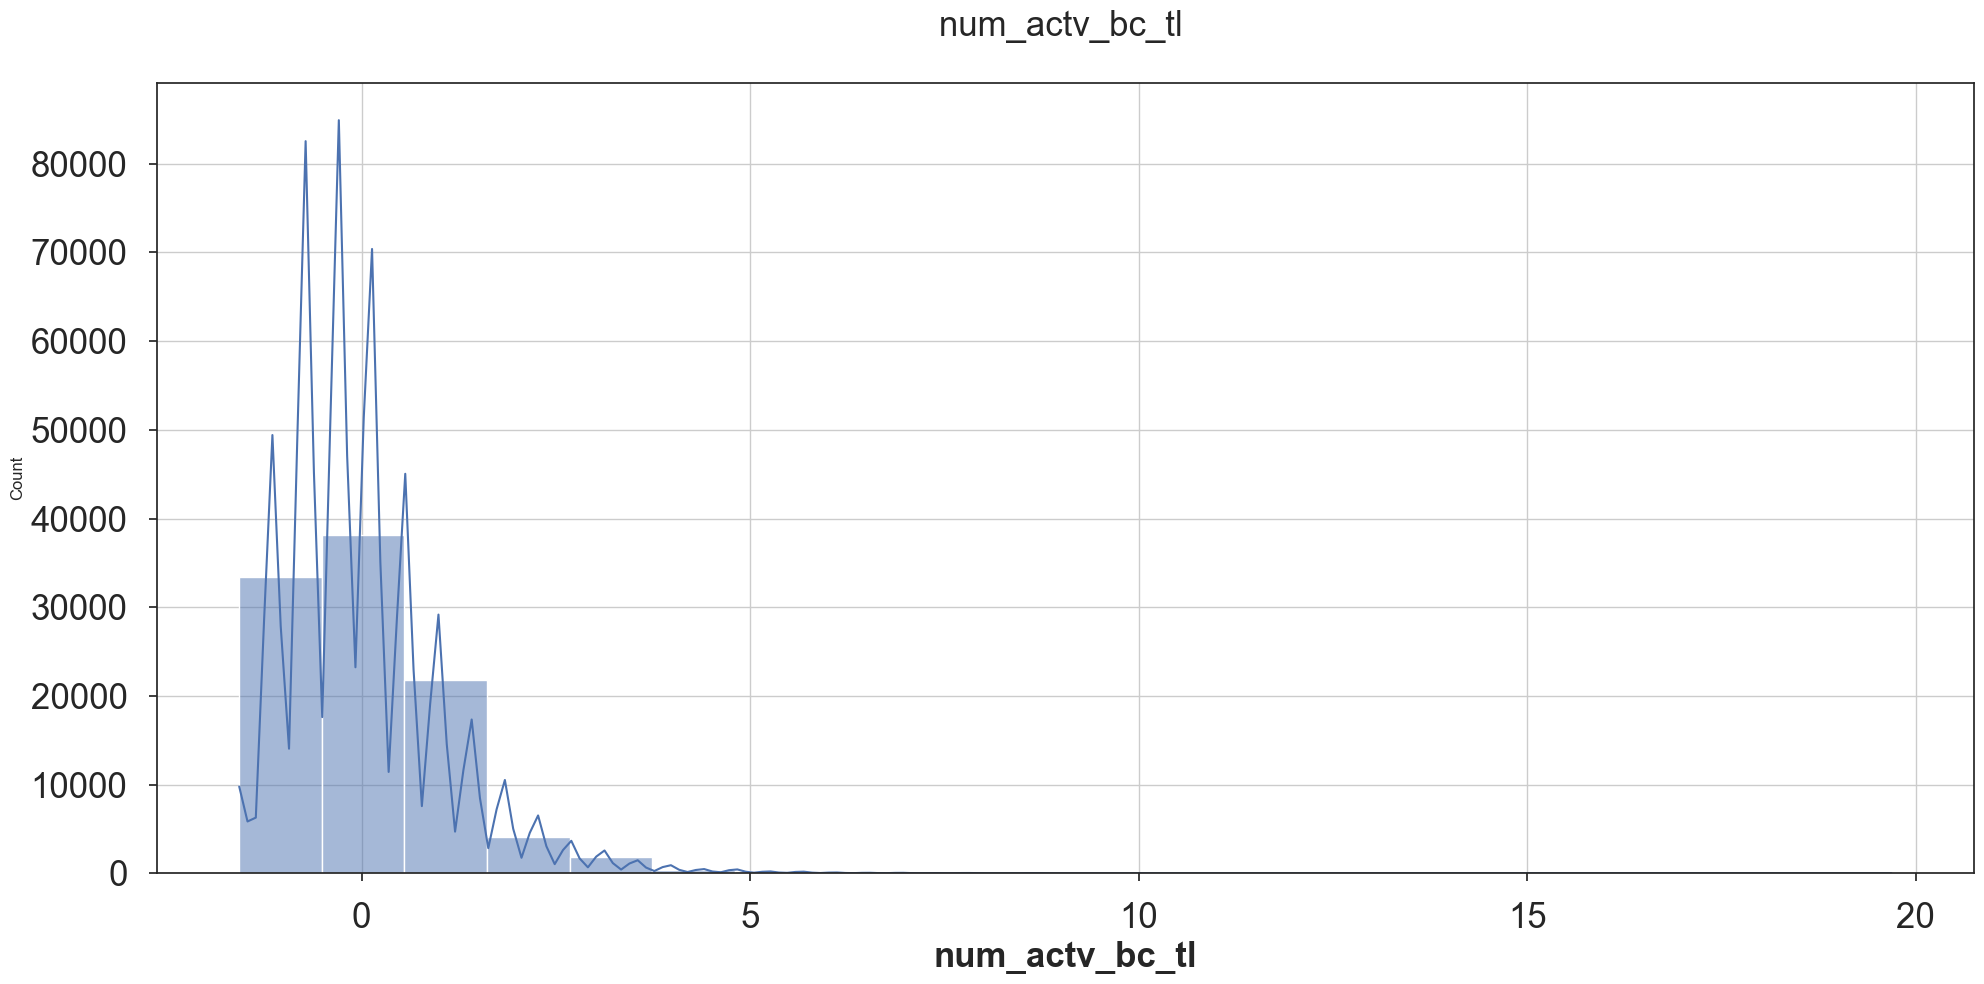

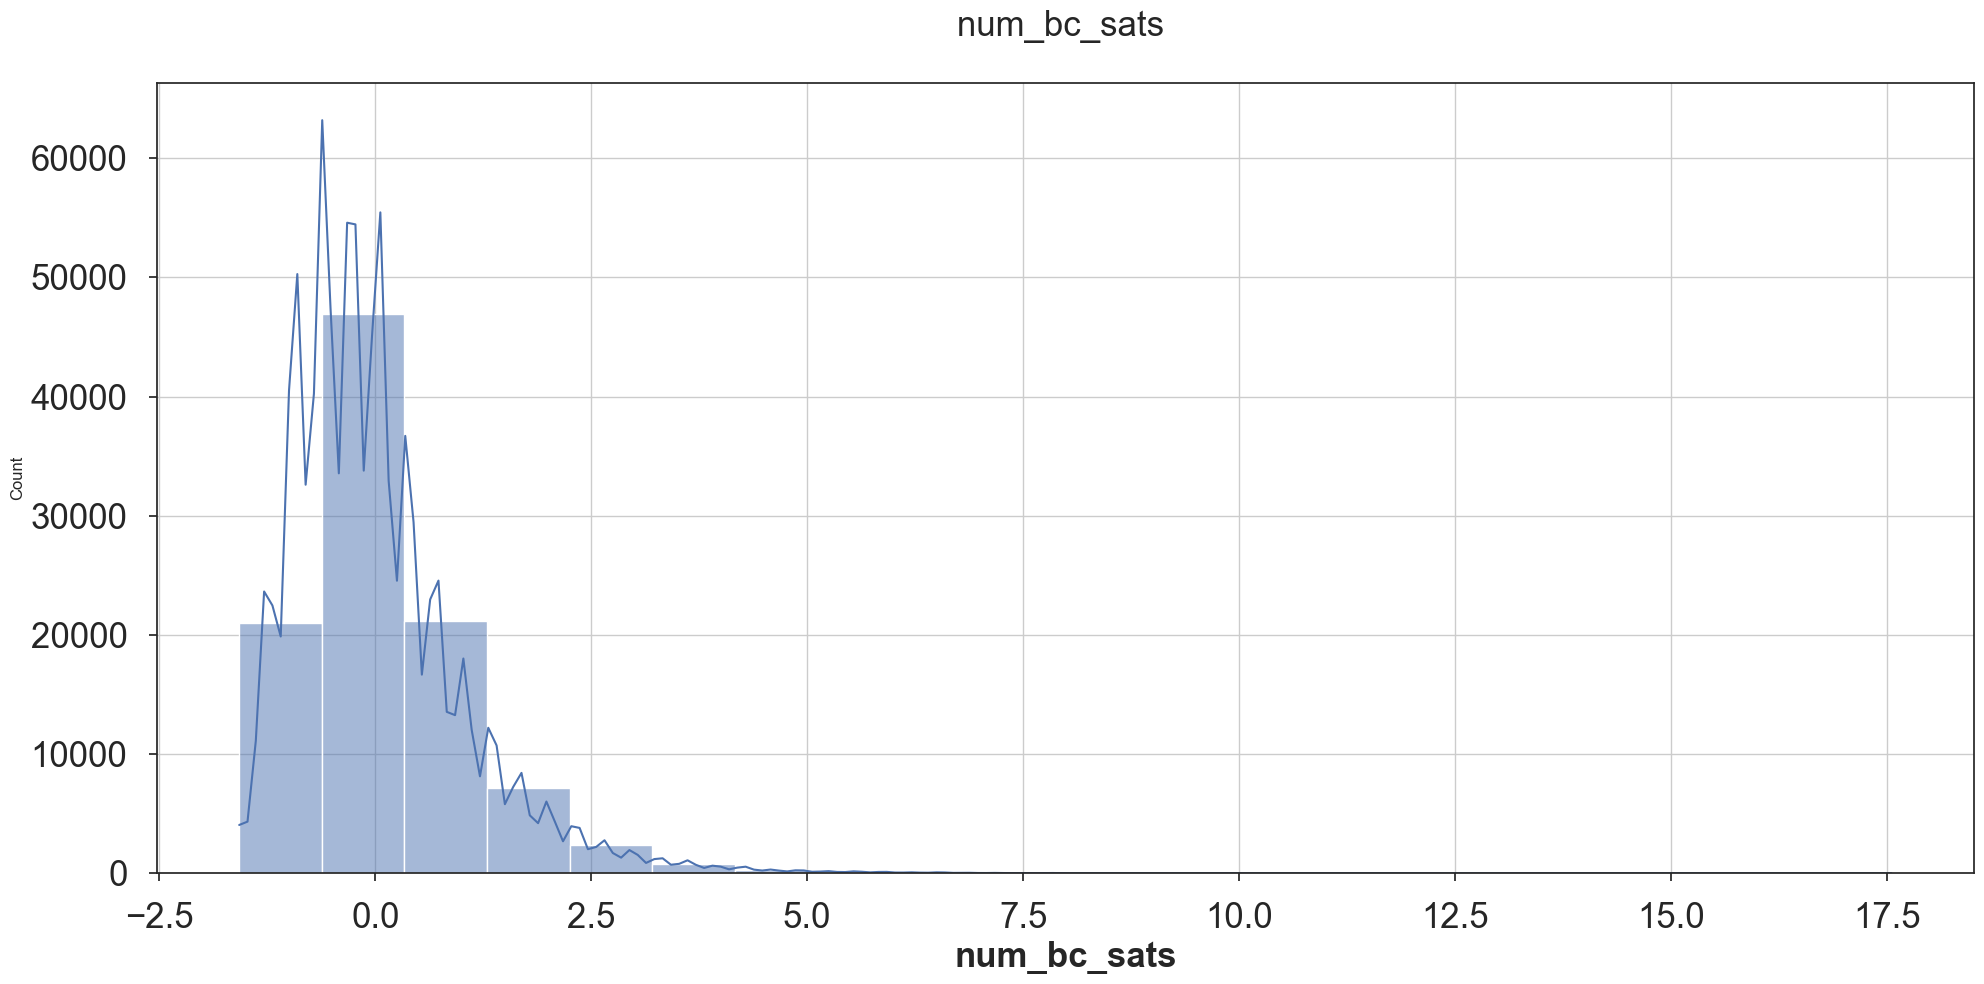

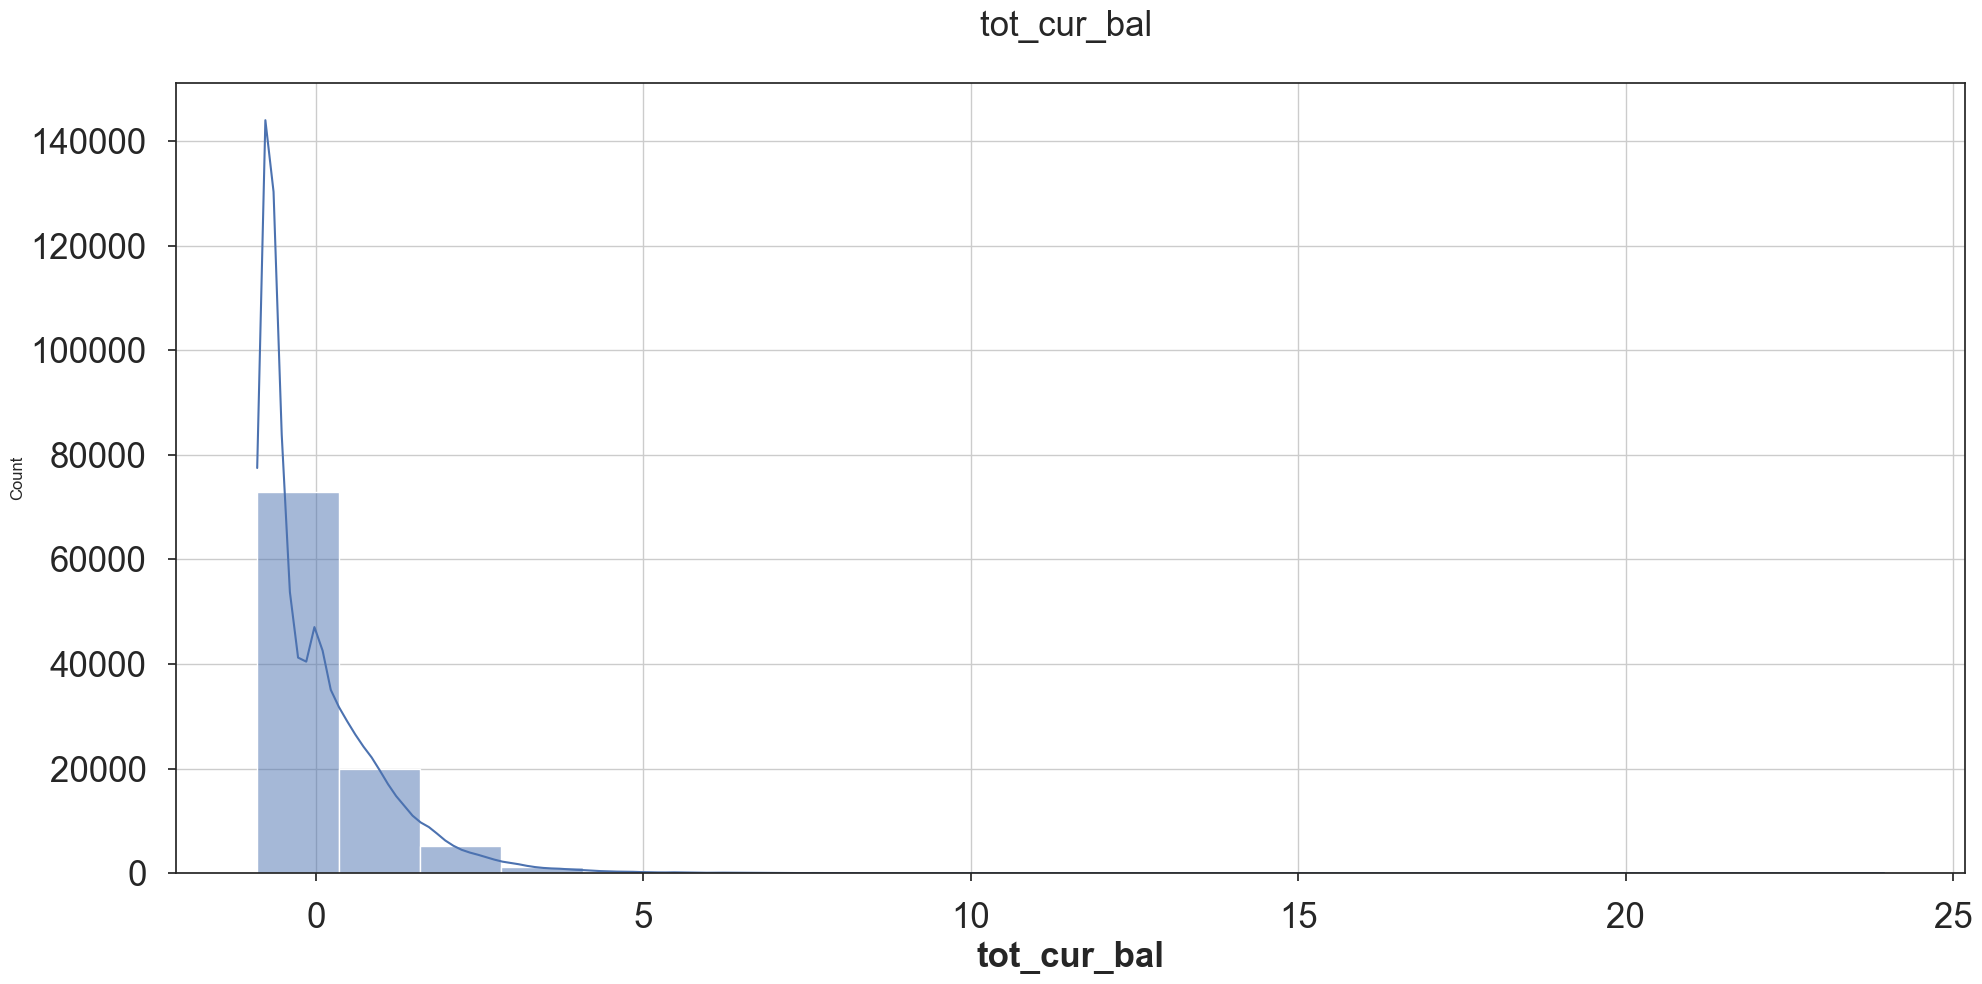

In [8]:
# inspecting the numerical fields if they follow a normal distribution
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

for n_col in X_num_3.columns:
    # Residual difference between Actual Values Predicted Values
    plt.figure(figsize=(20,10))
    sns.set(style="ticks")
    z_scores = stats.zscore(X_num_3[n_col])
    sns.histplot(z_scores, kde=True, bins=20)
    #sns.histplot(X_num_3[n_col], kde=True, bins=20)
    plt.xlabel('Counts' , fontsize=25 , weight='bold')
    plt.xlabel(f'{n_col}' , fontsize=25 , weight='bold')
    plt.title(f"{n_col} \n" , fontsize=25)
    plt.tick_params(axis='both', which='major', labelsize=25, pad=15)
    plt.grid(True)
    mng = plt.get_current_fig_manager()
    mng.full_screen_toggle()
    plt.tight_layout()
    plt.show()

In [9]:
# Setting the standard deviation limit to 3, to check the number of outliers per numerical feature

df_outlier_list = []

for n_col in X_num_3.columns:

    # Calculate Z-scores for numerical features
    z_scores_feat = np.abs(stats.zscore(df_model_3_dropped[n_col]))

    # Define a threshold for identifying outliers
    threshold = 3

    # How many outliers identified for each numerical columns?
    gt_thresh = z_scores_feat > threshold
    outlier_volume = pd.DataFrame( [[n_col , gt_thresh.sum()]], columns=[ "feature" , "num_outliers"])

    df_outlier_list.append(outlier_volume)

pd.concat(df_outlier_list).sort_values(by=['num_outliers'] , ascending=False).reset_index(drop=True)


feature  num_outliers
0   total_rec_late_fee          1184
1      fico_range_high          1107
2       fico_range_low          1107
3       int_rate_clean           871
4           annual_inc           567
5                  dti           365
6       debt_to_income            19
7            loan_amnt             0
8           max_bal_bc             0
9       total_bc_limit             0
10      num_actv_bc_tl             0
11         num_bc_sats             0
12         tot_cur_bal             0

### Observation
- Since our numerical features follow a `near` normal distribution with some positive right-skewness.
- Some features have difference scales
- The number of outliers beyond `3 x StandardDeviation` is average ~ 0.8% of the data
- Boundaries for some features are not well known

- Conclusion: We will choose to **StandardScaler** since the features are near normally distributed, some features have different scales e.g., interest rate, loan_amount, debt_to_income; and less prone prone to small number of outliers.



In [10]:
# 1.2 Feature Engineering

# - Standarizing numerical values
# - OneHotEncoding Categorical Variables
# - Handle Class imbalance of variables that are underrepresented, such as the categorical variables and the field 'total_rec_late_fee'
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# definie standarizing numerical features method
scaler = StandardScaler()

# Transform numerical features
X_num_3_std = scaler.fit_transform(X_num_3)

# Convert tranformed numerical features into Dataframe
X_num_3_std = pd.DataFrame(X_num_3_std, columns=features_num_3)

# Encoding categorical features
# One-hot encoding
X_cat_3_ohe = pd.get_dummies(X_cat_3, dtype=int)

# bring Numerical and categorical features into one dataframe
X_3 = pd.concat([X_num_3_std, X_cat_3_ohe] , axis=1)

# Handling Class imbalances for categorical features that may have classes underrepresented
# e.g., we have imbalances within across the categorical features, i.e., purpose ~ heavily populated with 'debt_consolidation'
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_3 , y_3 = smote.fit_resample(X_3, y_3)

print("\n Sample of New dataset ready for our Deep Learning Model_3")

pd.concat([X_3 , y_3] , axis=1)


c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



 Sample of New dataset ready for our Deep Learning Model_3


fico_range_high  fico_range_low  annual_inc       dti  debt_to_income  \
0             -1.054154       -1.054179   -0.368123  0.053106       -0.053802   
1             -0.610316       -0.610327   -0.264948  0.347122        0.057824   
2             -1.054154       -1.054179   -0.287876 -0.701035       -0.051298   
3              1.460930        1.460982   -0.419710  0.301978        0.101015   
4              1.017092        1.017130   -0.368123  0.287509        0.015058   
...                 ...             ...         ...       ...             ...   
175041        -1.026610       -1.026634   -0.212690  0.101960       -0.014050   
175042         0.064082        0.064091   -0.252321  0.128643       -0.024512   
175043        -1.160191       -1.160219   -0.238675  0.085653       -0.018205   
175044        -0.642253       -0.642265   -0.497609  0.221977       -0.023281   
175045        -0.422780       -0.422786   -0.392099  0.642811        0.013449   

        total_rec_late_fee  int_rate_clean  loan_amnt  max_bal_bc  \
0                -0.130413        0.004995  -1.196748   -1.297603   
1                -0.130413       -0.798969   0.916419   -0.835249   
2                -0.130413       -0.526196  -1.091090    0.000000   
3                -0.130413       -0.411344   0.916419   -0.816642   
4                -0.130413        0.109592  -0.140165   -0.452297   
...                    ...             ...        ...         ...   
175041           -0.130413        0.592295  -0.287073   -0.281469   
175042           -0.130413        0.059476  -0.578888    0.000000   
175043           -0.130413        0.465382  -0.421408   -0.969789   
175044           -0.130413        2.403377  -0.955103   -1.079846   
175045           -0.130413       -0.246577  -0.211965    0.229199   

        total_bc_limit  num_actv_bc_tl  num_bc_sats  tot_cur_bal  purpose_car  \
0            -1.025134       -1.574752    -1.575309     0.696420            0   
1            -0.488270       -0.299011     0.045712    -0.517783            0   
2            -0.612162       -0.299011    -0.602697     0.081385            0   
3             0.998431        0.976730     1.990937    -0.254420            0   
4             0.164227        0.126236     0.045712    -0.342692            0   
...                ...             ...          ...          ...          ...   
175041       -0.627000        1.149768     0.886402    -0.480258            0   
175042       -0.390853        1.449468     1.054532     0.605989            0   
175043       -0.850763       -0.238780    -0.556777    -0.493681            0   
175044       -0.949016       -0.724258    -0.926901    -0.769543            0   
175045       -0.288358       -0.233125    -0.552465    -0.707947            1   

        purpose_credit_card  purpose_debt_consolidation  purpose_educational  \
0                         0                           0                    0   
1                         1                           0                    0   
2                         1                           0                    0   
3                         0                           1                    0   
4                         0                           1                    0   
...                     ...                         ...                  ...   
175041                    0                           0                    0   
175042                    0                           0                    0   
175043                    1                           0                    0   
175044                    0                           1                    0   
175045                    0                           0                    0   

        purpose_home_improvement  purpose_house  purpose_major_purchase  \
0                              1              0                       0   
1                              0              0                       0   
2                              0              0

---
#  Building Deep Learning Challenger `Model_3`


## Building a neural network model

### We will use a simple architecture for the standard for binary classification task

### Dense [relu or leaky_relu] -> Dense [relu or leaky_relu]  -> Dense sigmoid
#### A Two layer input and a single layer output for binary classification

- We will be investigating between different parameter combinations, which are; 
    - Activation functions e.g., (ReLU and Leaky ReLU)
    - Number of Neurons for our Dense layers
        - e.g., first layer = Dense( No.Neurons )
                second layer = Dense ( (No. Neurons)/2 )
    - L2_Regularizer values = [1e-6, 1e-5, 1e-4] ~ adding weights to control the overfitting

- We will be looping through the combination of parameters for 50 epochs per combination, assessing 5th epoch for model performance based on AUC score, and to avoid overfitting.
    - e.g., if model performs worse after 5 epochs, then stop, retreat back to best performance epoch, else continue until 50 epochs.

- The model compiling ~ constant
    - Using 'adam' for optimization for its efficiency
    - Minimize loss = binary_crossentropy

- How to assess each combination ? :
    - Visuals/plots comparing train and validation metrics [accuracy, loss and AUC]
    - model evaluation metrics on between test data and predicted data
    - Overall roc_auc scores comparing train-to-prediction vs test-to-prediction 

In [11]:
# Defining a overfitting function, to plot residuals between accuracy, loss and AUC

def plot_training_vs_overfitting(history, title):
    """Plot training and validation accuracy to detect overfitting """
    import matplotlib.pyplot as plt

    # Plot accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

    # Plot auc
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()



# Explore model with Hyperparameter finetuning based on AUC scores
# Evaluate and prevent overfitting

- Here, we are looping through a range of parameters to tune our NN model, for 50 epochs, batch_size=64 (since our dataset > 100k due to post imbalance correction of features), and assess each 5th epoch for earlyStopping if the model performance gets worse

Shape of X, y train test datasets :
Shape of X_train: (140036, 33)
Shape of X_test: (35010, 33)
Shape of y_train: (140036,)
Shape of y_test: (35010,)
 ###  .. processing parameters = {'Neurons': 8, 'activation': 'relu', 'regularizer': 1e-06} ..  ## 


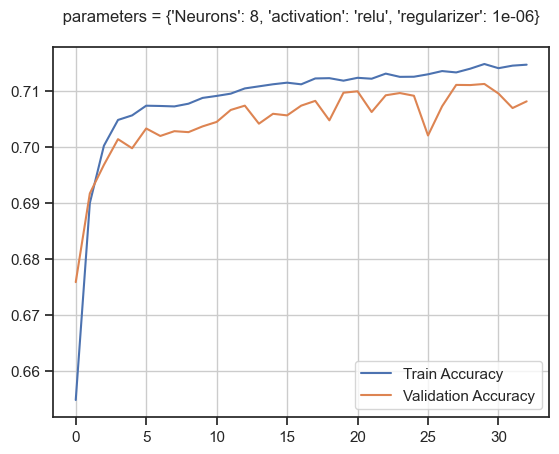

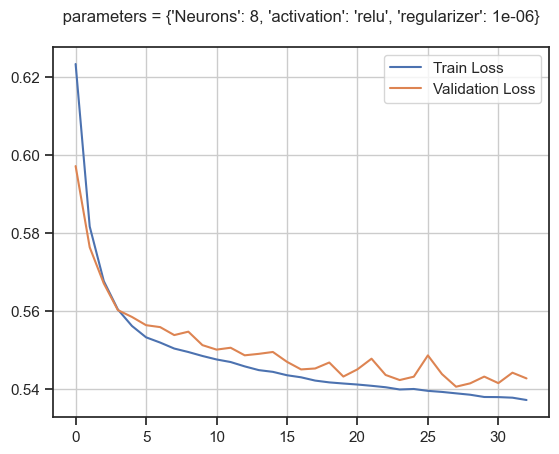

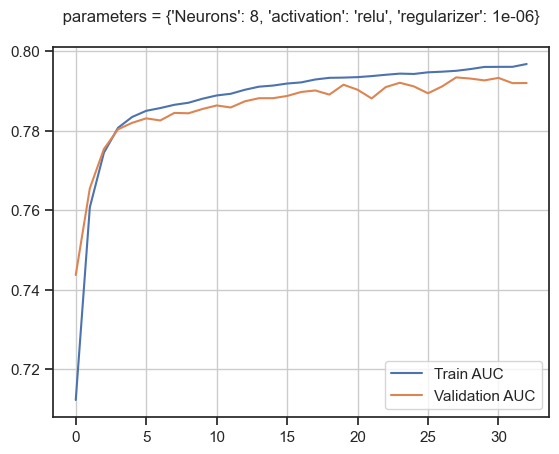

1095/1095 [==============================] - 1s 1ms/step
Accuracy: 0.7111396743787489
Precision: 0.7083474146671173
Recall (Sensitivity): 0.7181771457940723
F1-Score: 0.7132284134410889
ROC-AUC: 0.7934448551126488
Confusion Matrix:
[[12321  5178]
 [ 4935 12576]]


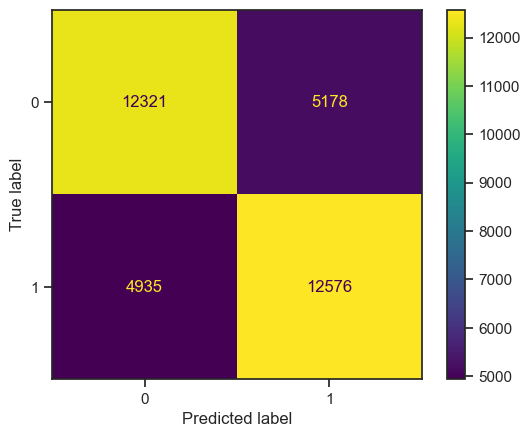

 ###  .. processing parameters = {'Neurons': 8, 'activation': 'relu', 'regularizer': 1e-05} ..  ## 


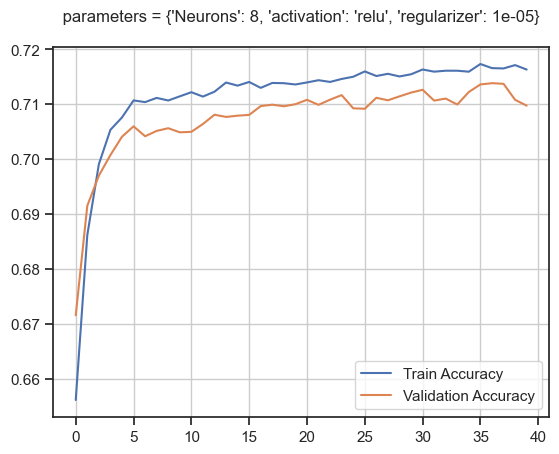

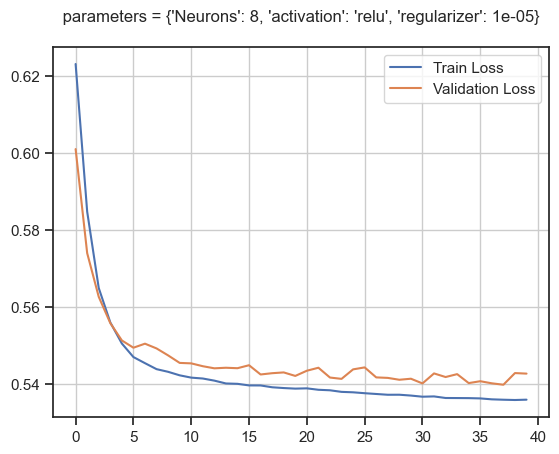

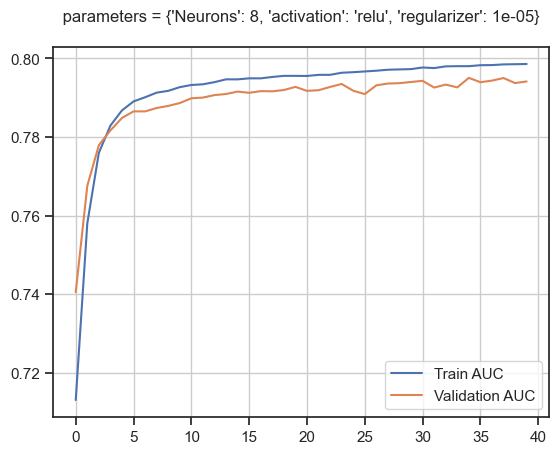

1095/1095 [==============================] - 1s 1ms/step
Accuracy: 0.7122536418166239
Precision: 0.7054533399635339
Recall (Sensitivity): 0.729141682371081
F1-Score: 0.7171019376579613
ROC-AUC: 0.7950281235059455
Confusion Matrix:
[[12168  5331]
 [ 4743 12768]]


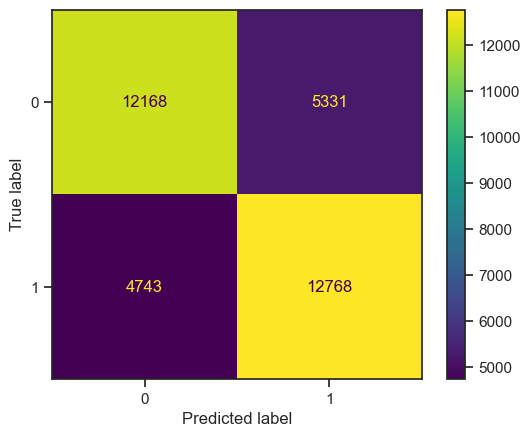

 ###  .. processing parameters = {'Neurons': 8, 'activation': 'relu', 'regularizer': 0.0001} ..  ## 


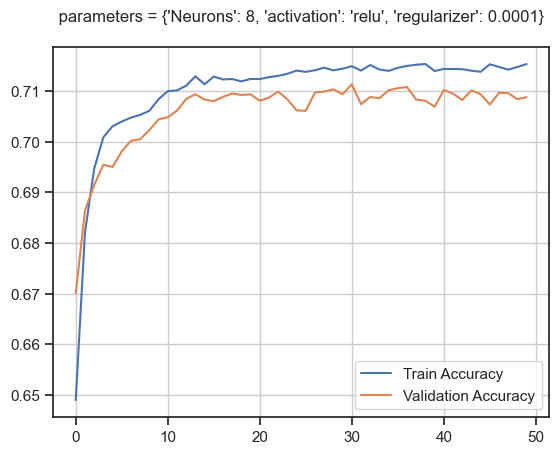

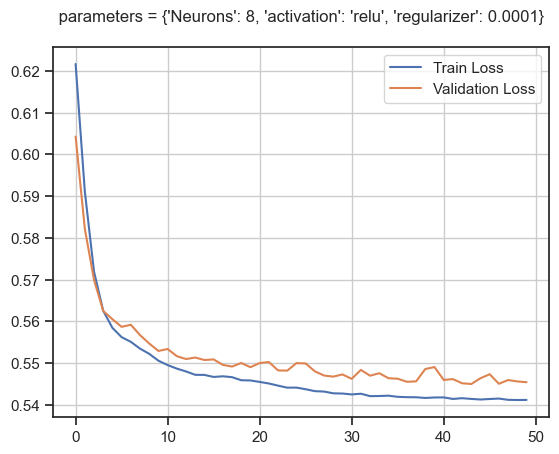

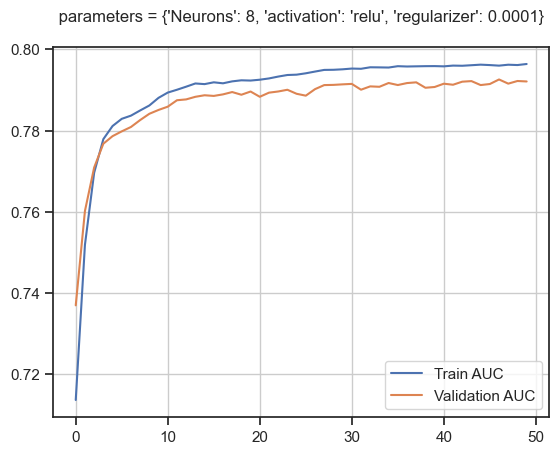

1095/1095 [==============================] - 1s 966us/step
Accuracy: 0.7087974864324479
Precision: 0.6963499731615673
Recall (Sensitivity): 0.7408486094454914
F1-Score: 0.7179104064635732
ROC-AUC: 0.7920999109508005
Confusion Matrix:
[[11842  5657]
 [ 4538 12973]]


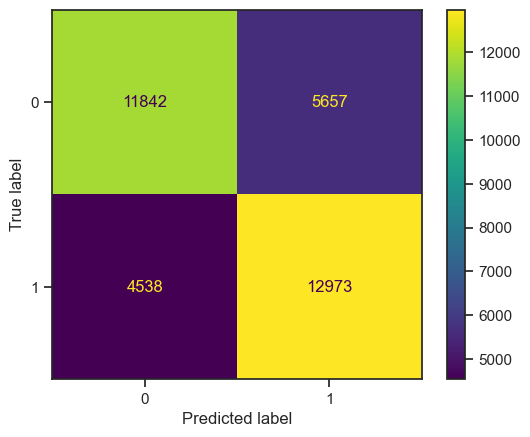

 ###  .. processing parameters = {'Neurons': 8, 'activation': 'leaky_relu', 'regularizer': 1e-06} ..  ## 


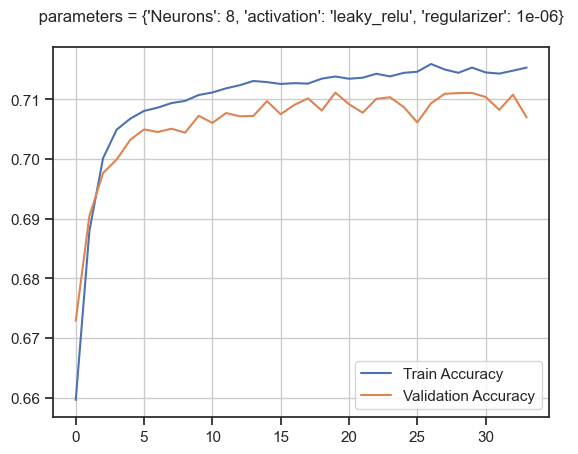

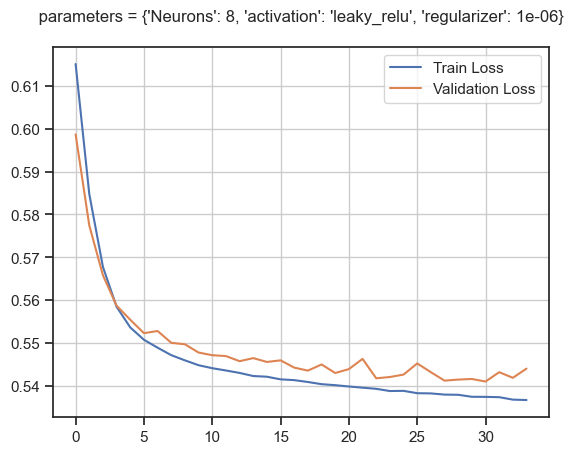

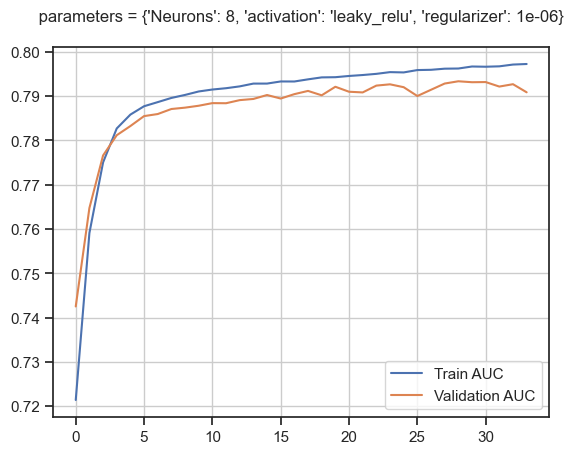

1095/1095 [==============================] - 2s 1ms/step
Accuracy: 0.7110539845758355
Precision: 0.6940843000367435
Recall (Sensitivity): 0.7551253497801382
F1-Score: 0.7233192932552924
ROC-AUC: 0.7933517409704467
Confusion Matrix:
[[11671  5828]
 [ 4288 13223]]


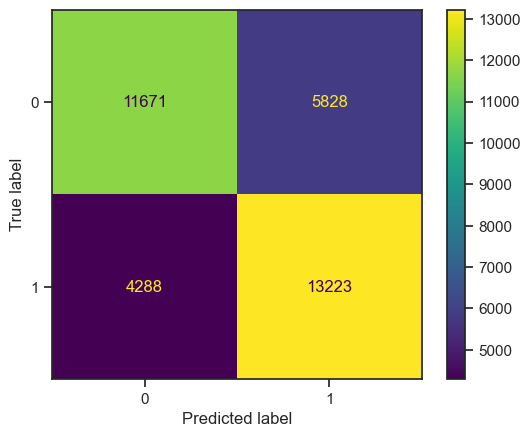

 ###  .. processing parameters = {'Neurons': 8, 'activation': 'leaky_relu', 'regularizer': 1e-05} ..  ## 


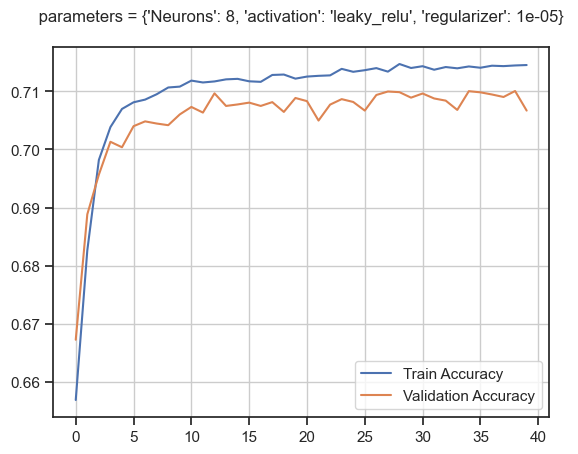

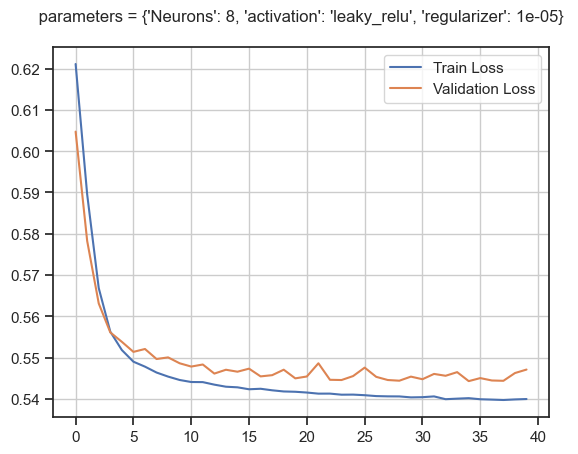

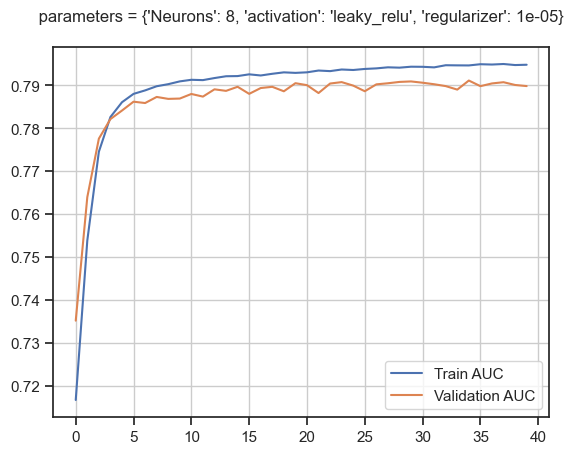

1095/1095 [==============================] - 1s 1ms/step
Accuracy: 0.7100257069408741
Precision: 0.6986234817813766
Recall (Sensitivity): 0.7390782936439952
F1-Score: 0.7182817182817183
ROC-AUC: 0.791138114391839
Confusion Matrix:
[[11916  5583]
 [ 4569 12942]]


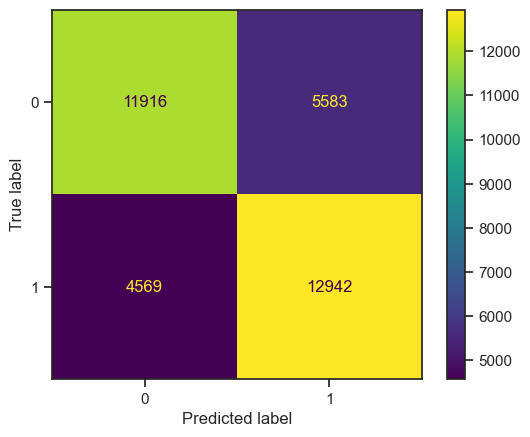

 ###  .. processing parameters = {'Neurons': 8, 'activation': 'leaky_relu', 'regularizer': 0.0001} ..  ## 


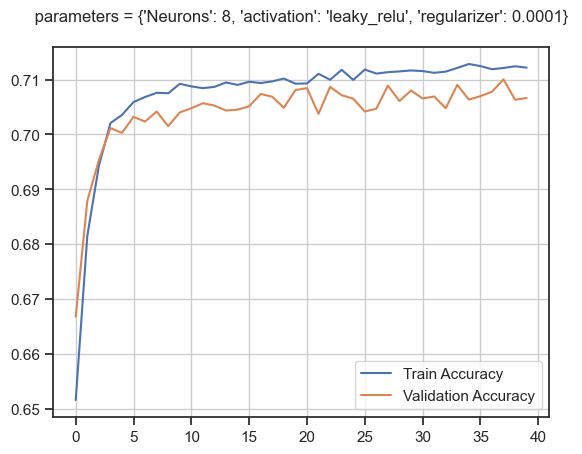

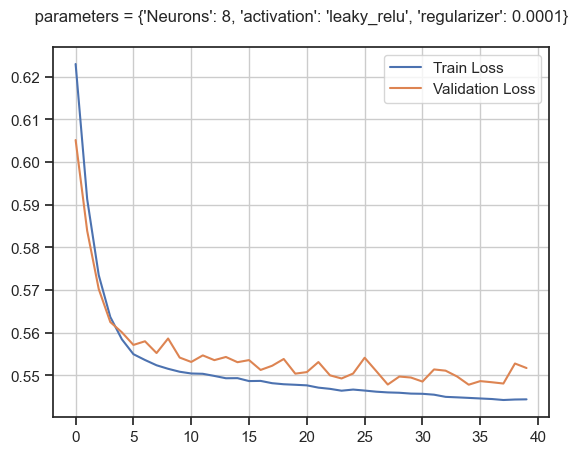

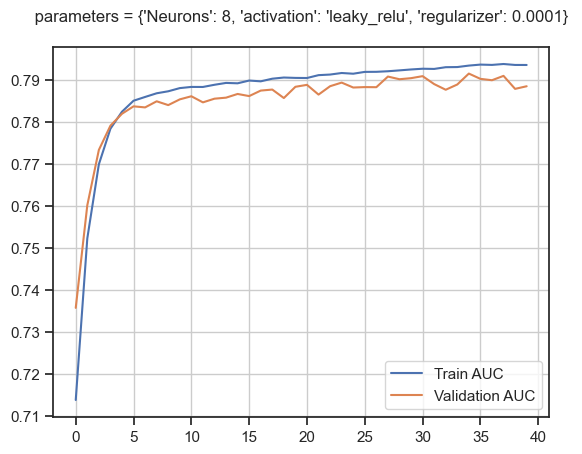

1095/1095 [==============================] - 1s 1ms/step
Accuracy: 0.7063410454155955
Precision: 0.6921645758026791
Recall (Sensitivity): 0.7435897435897436
F1-Score: 0.7169561985518818
ROC-AUC: 0.7914202013726759
Confusion Matrix:
[[11708  5791]
 [ 4490 13021]]


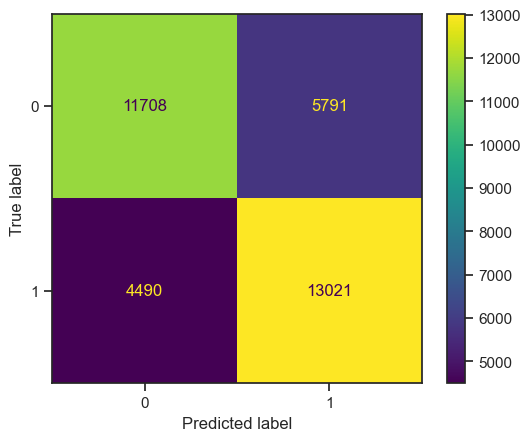

 ###  .. processing parameters = {'Neurons': 16, 'activation': 'relu', 'regularizer': 1e-06} ..  ## 


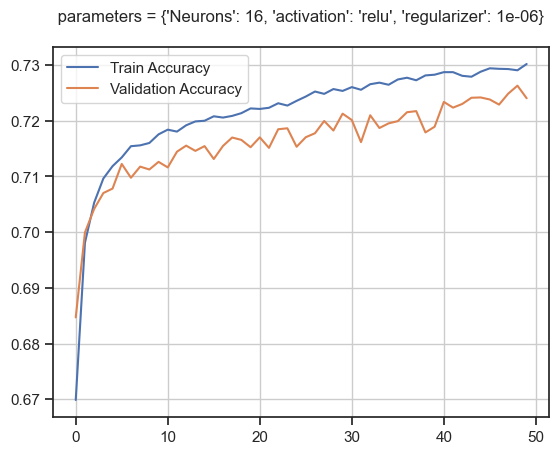

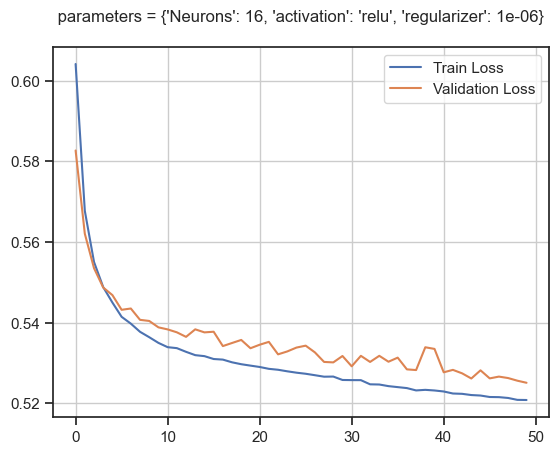

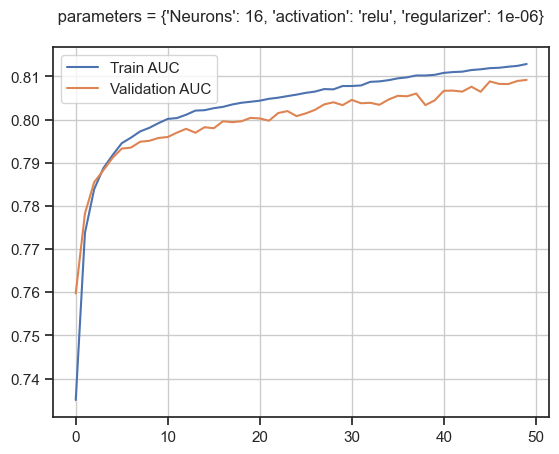

1095/1095 [==============================] - 1s 1ms/step
Accuracy: 0.7240502713510426
Precision: 0.715351695380226
Recall (Sensitivity): 0.7445605619324995
F1-Score: 0.7296639337381425
ROC-AUC: 0.8092003309168758
Confusion Matrix:
[[12311  5188]
 [ 4473 13038]]


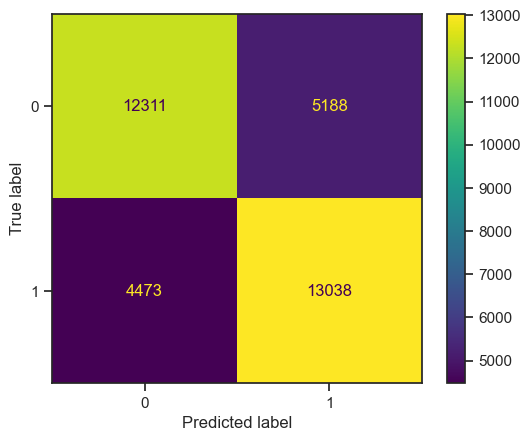

 ###  .. processing parameters = {'Neurons': 16, 'activation': 'relu', 'regularizer': 1e-05} ..  ## 


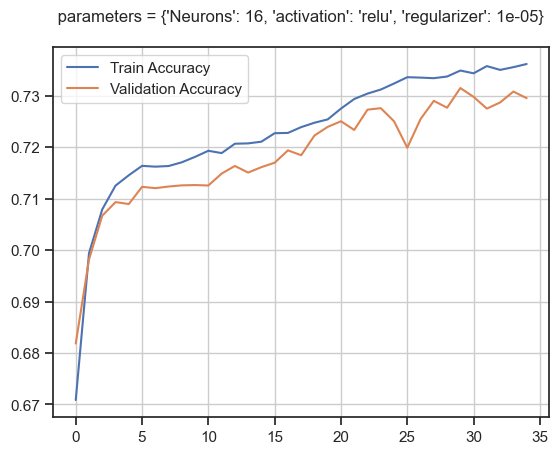

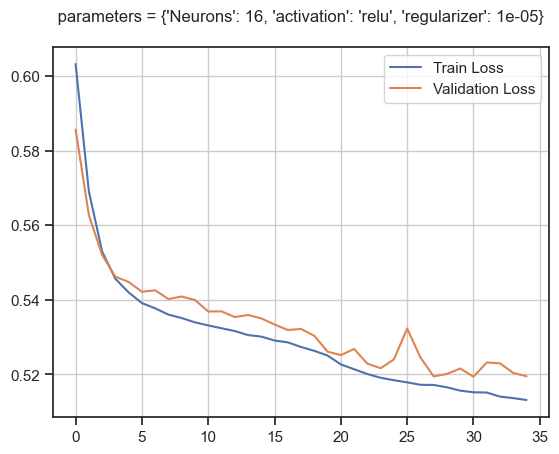

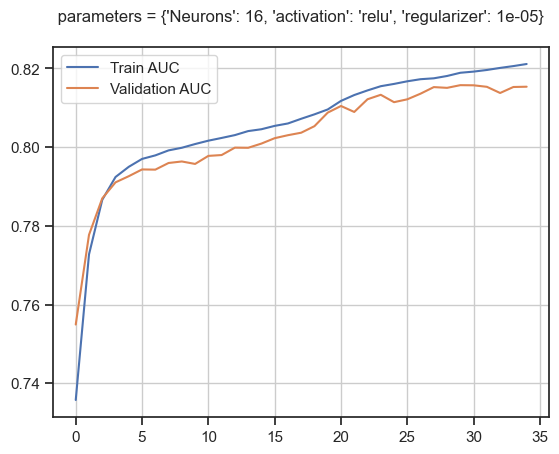

1095/1095 [==============================] - 2s 2ms/step
Accuracy: 0.7314767209368752
Precision: 0.7526794616151545
Recall (Sensitivity): 0.6897949860087945
F1-Score: 0.7198665037694806
ROC-AUC: 0.8157422777944524
Confusion Matrix:
[[13530  3969]
 [ 5432 12079]]


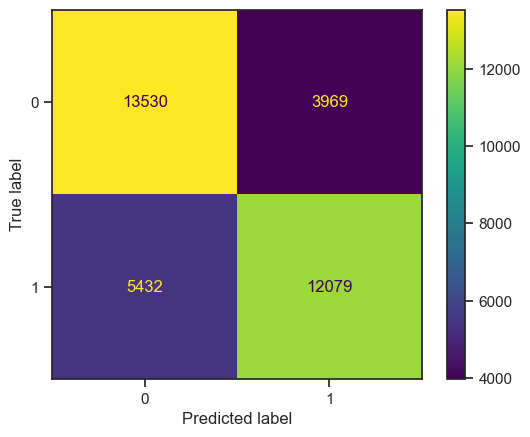

 ###  .. processing parameters = {'Neurons': 16, 'activation': 'relu', 'regularizer': 0.0001} ..  ## 


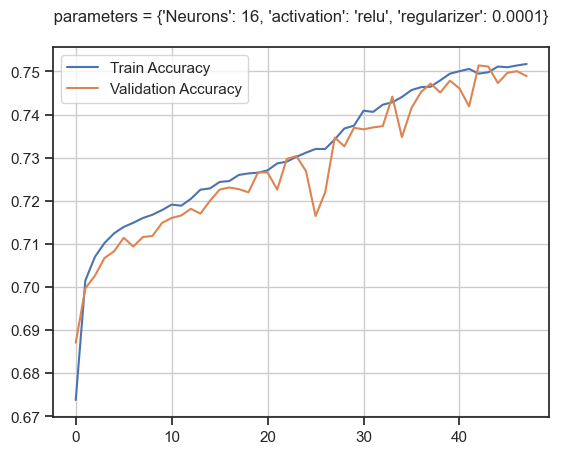

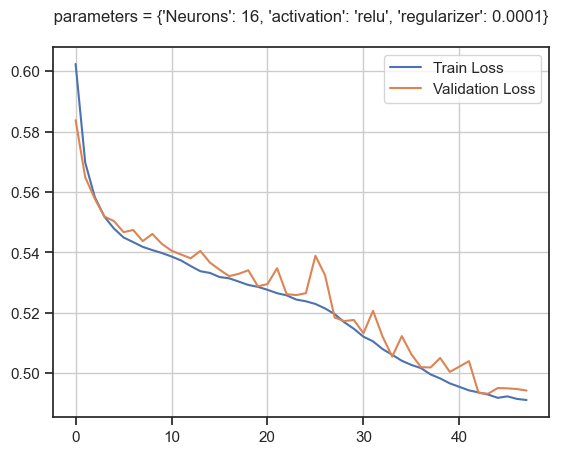

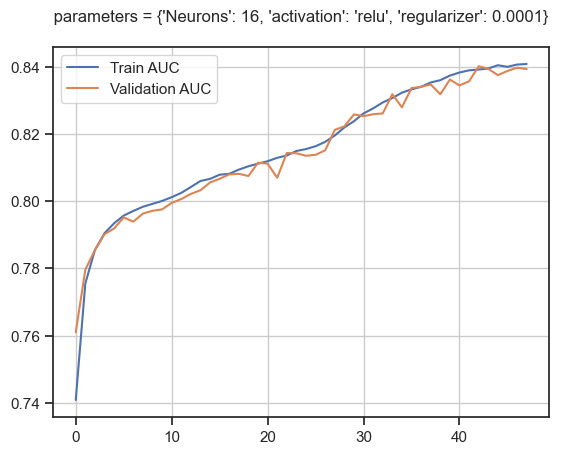

1095/1095 [==============================] - 1s 1ms/step
Accuracy: 0.7513853184804342
Precision: 0.7709345966898419
Recall (Sensitivity): 0.7155502255724973
F1-Score: 0.7422106385499349
ROC-AUC: 0.8401004364562448
Confusion Matrix:
[[13776  3723]
 [ 4981 12530]]


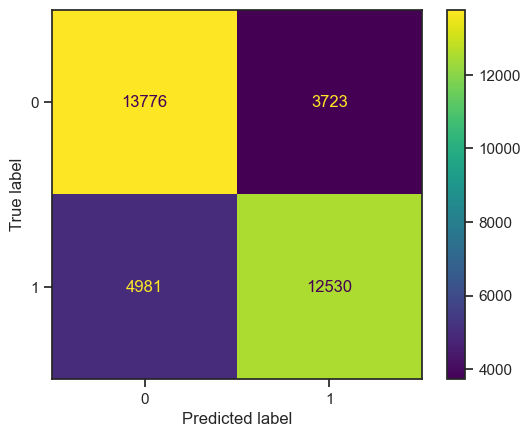

 ###  .. processing parameters = {'Neurons': 16, 'activation': 'leaky_relu', 'regularizer': 1e-06} ..  ## 


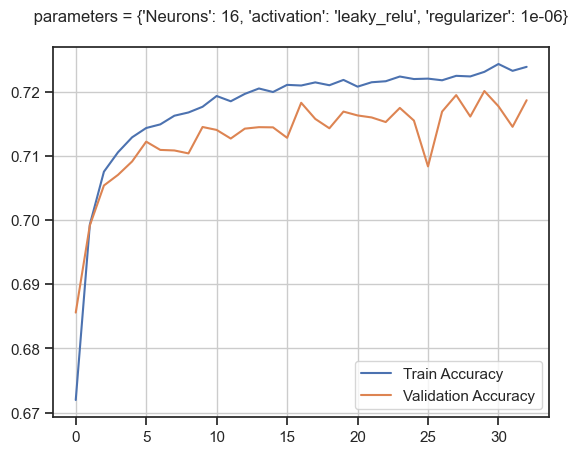

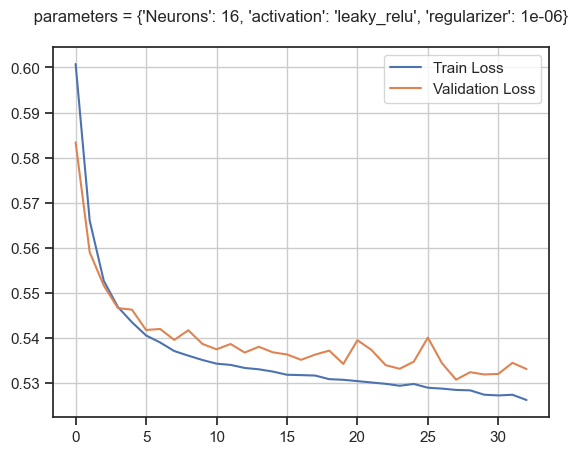

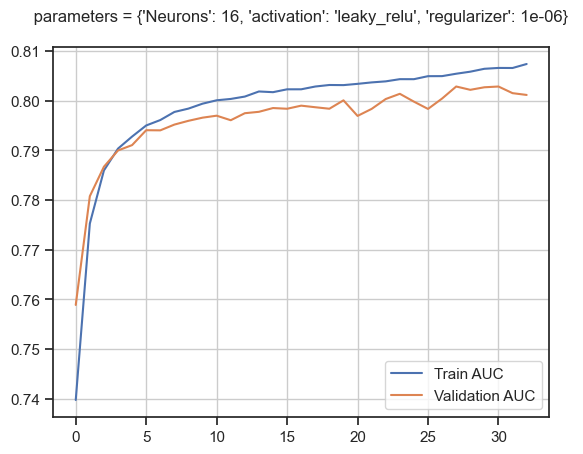

1095/1095 [==============================] - 1s 1ms/step
Accuracy: 0.7194515852613539
Precision: 0.7156802244039271
Recall (Sensitivity): 0.7285135057963565
F1-Score: 0.7220398460493548
ROC-AUC: 0.8028473715634205
Confusion Matrix:
[[12431  5068]
 [ 4754 12757]]


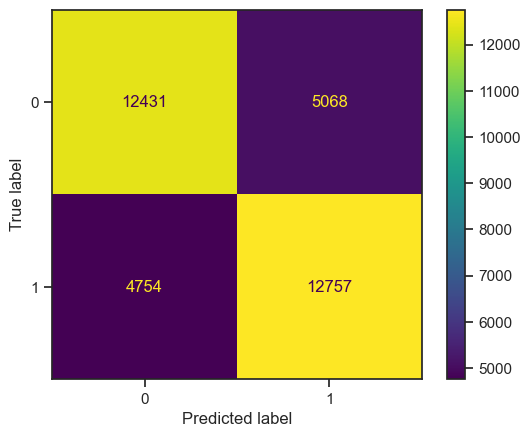

 ###  .. processing parameters = {'Neurons': 16, 'activation': 'leaky_relu', 'regularizer': 1e-05} ..  ## 


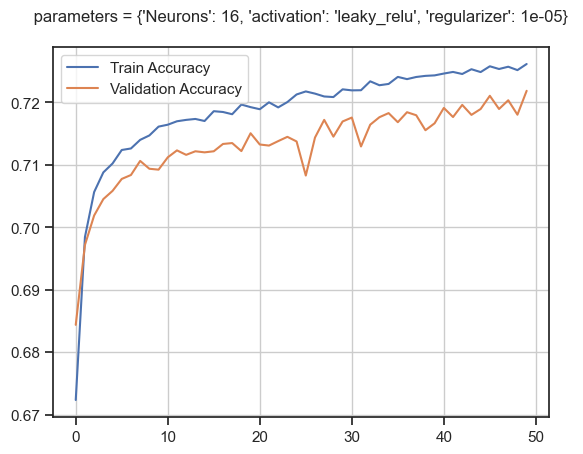

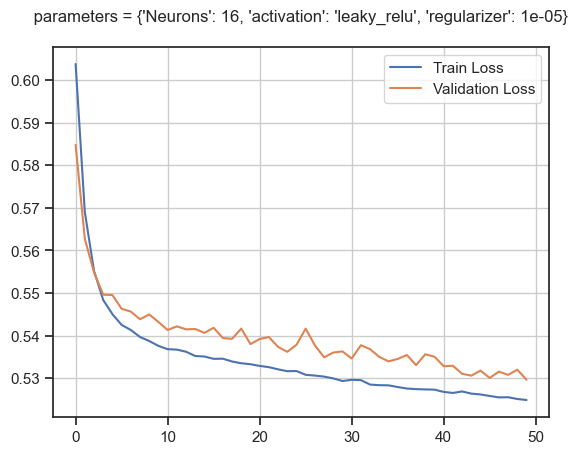

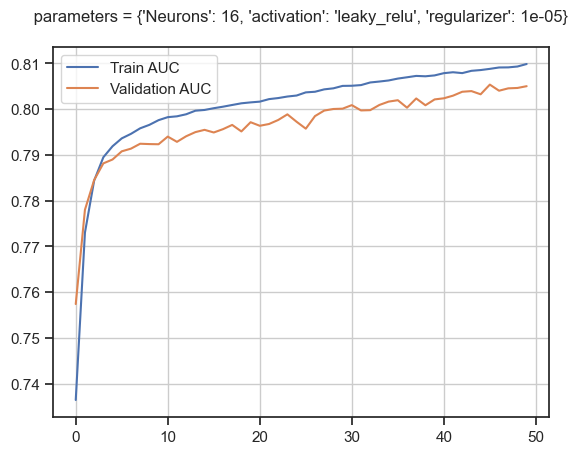

1095/1095 [==============================] - 1s 1ms/step
Accuracy: 0.7218508997429306
Precision: 0.7139083053552755
Recall (Sensitivity): 0.7407343955228143
F1-Score: 0.7270739910313901
ROC-AUC: 0.8050231781194581
Confusion Matrix:
[[12301  5198]
 [ 4540 12971]]


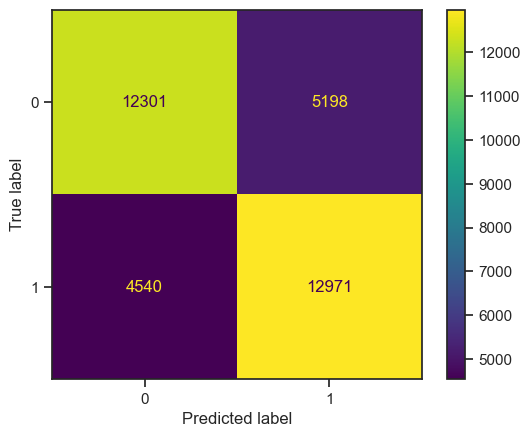

 ###  .. processing parameters = {'Neurons': 16, 'activation': 'leaky_relu', 'regularizer': 0.0001} ..  ## 


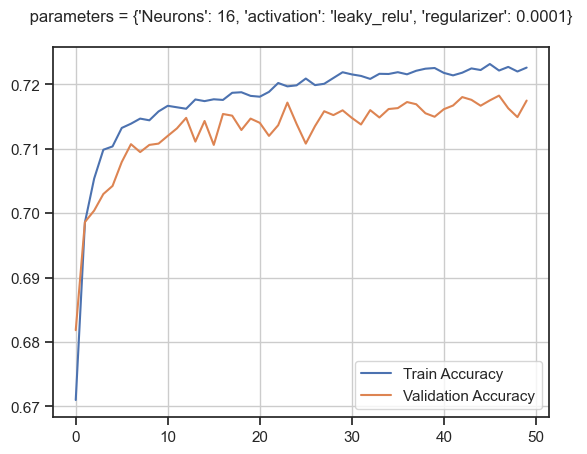

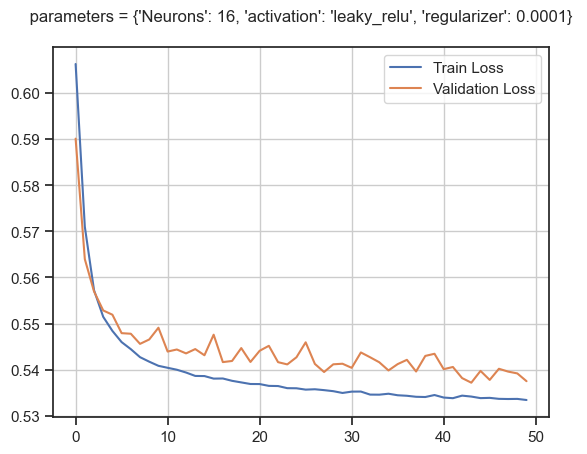

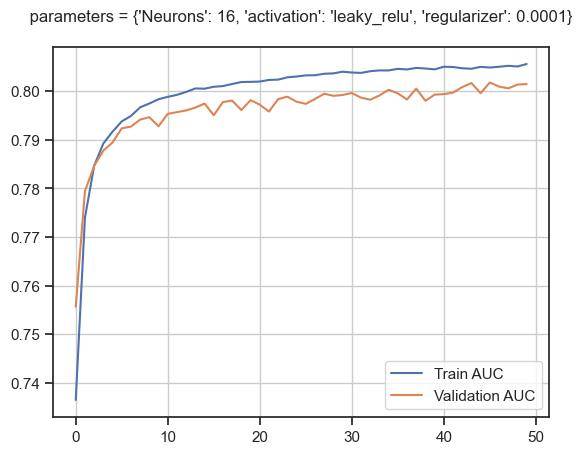

1095/1095 [==============================] - 1s 1ms/step
Accuracy: 0.7174807197943445
Precision: 0.7085614188745347
Recall (Sensitivity): 0.7391925075666724
F1-Score: 0.7235529221051454
ROC-AUC: 0.8014307981259322
Confusion Matrix:
[[12175  5324]
 [ 4567 12944]]


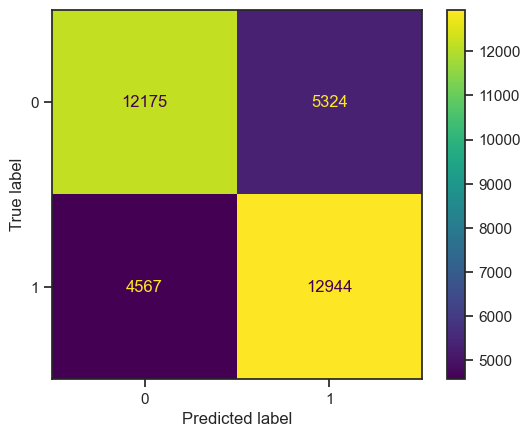

 ###  .. processing parameters = {'Neurons': 32, 'activation': 'relu', 'regularizer': 1e-06} ..  ## 


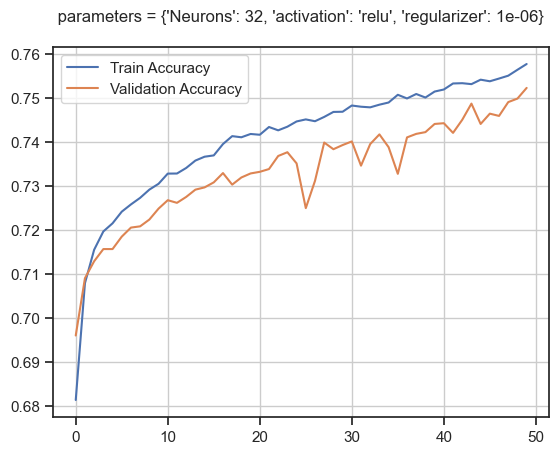

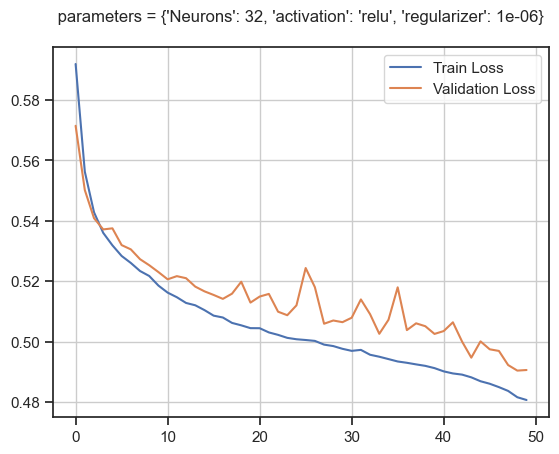

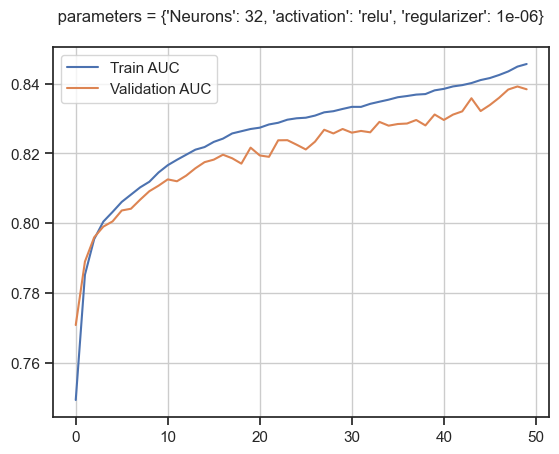

1095/1095 [==============================] - 1s 1ms/step
Accuracy: 0.7523279063124821
Precision: 0.7485380116959064
Recall (Sensitivity): 0.7602078693392724
F1-Score: 0.7543278084714549
ROC-AUC: 0.838381193512909
Confusion Matrix:
[[13027  4472]
 [ 4199 13312]]


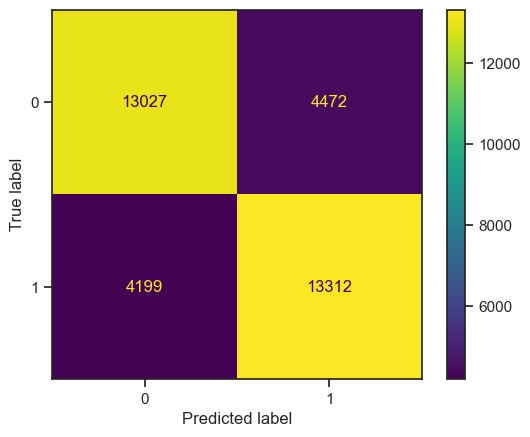

 ###  .. processing parameters = {'Neurons': 32, 'activation': 'relu', 'regularizer': 1e-05} ..  ## 


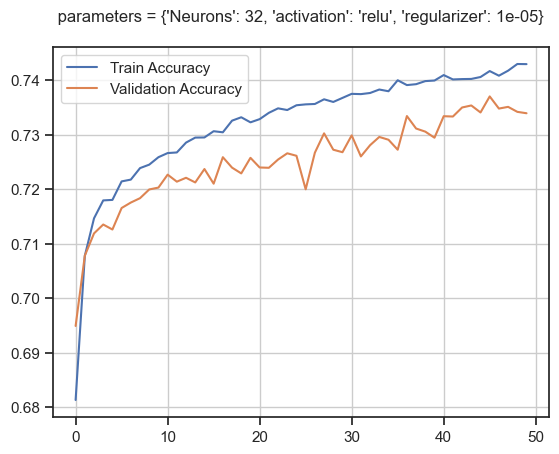

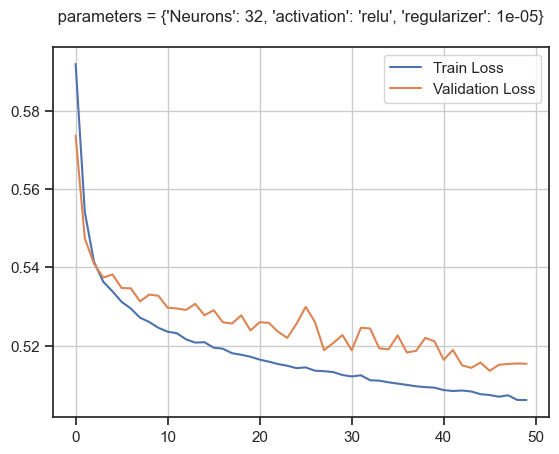

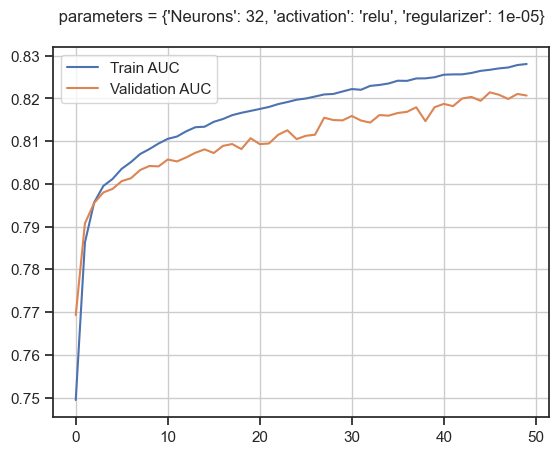

1095/1095 [==============================] - 1s 1ms/step
Accuracy: 0.7339045986860897
Precision: 0.7468522200132538
Recall (Sensitivity): 0.7079549997144652
F1-Score: 0.726883611844034
ROC-AUC: 0.8207013332062157
Confusion Matrix:
[[13297  4202]
 [ 5114 12397]]


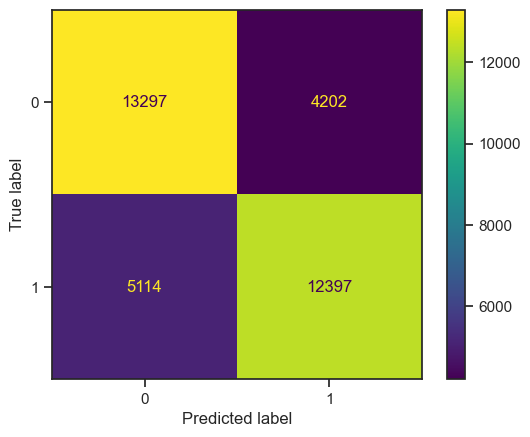

 ###  .. processing parameters = {'Neurons': 32, 'activation': 'relu', 'regularizer': 0.0001} ..  ## 


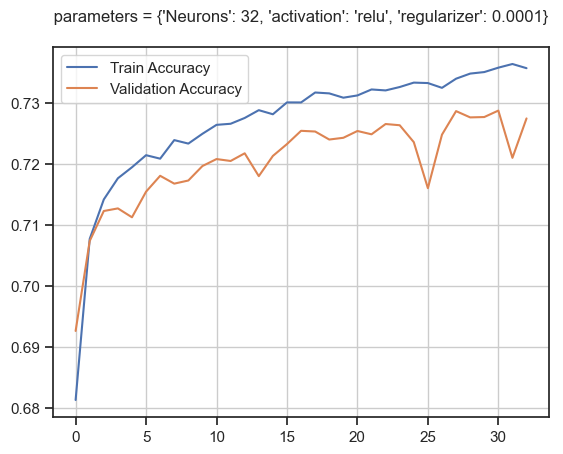

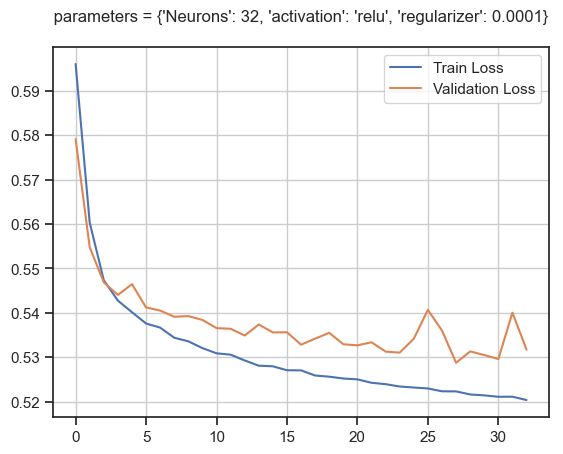

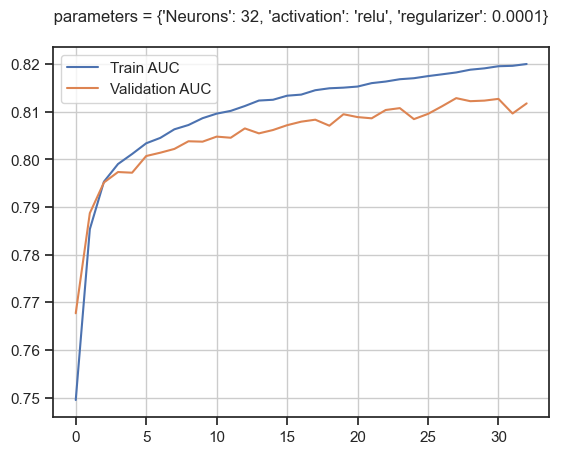

1095/1095 [==============================] - 1s 1ms/step
Accuracy: 0.7285918309054555
Precision: 0.7177423739872764
Recall (Sensitivity): 0.7538118896693506
F1-Score: 0.7353350788256922
ROC-AUC: 0.8128499989927389
Confusion Matrix:
[[12308  5191]
 [ 4311 13200]]


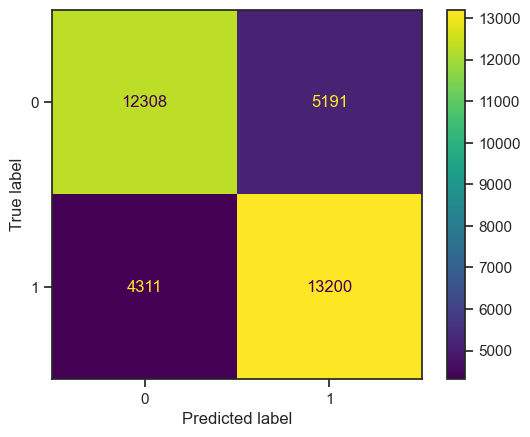

 ###  .. processing parameters = {'Neurons': 32, 'activation': 'leaky_relu', 'regularizer': 1e-06} ..  ## 


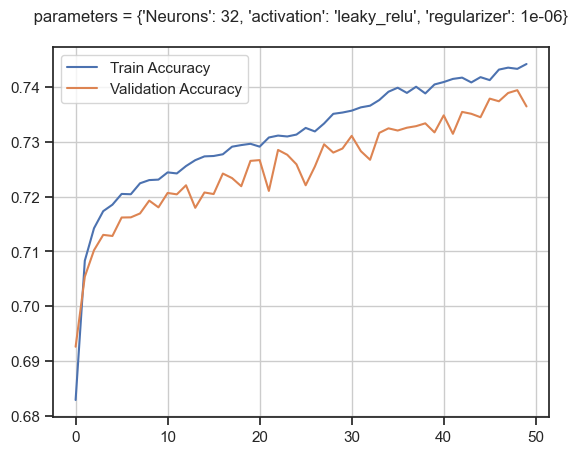

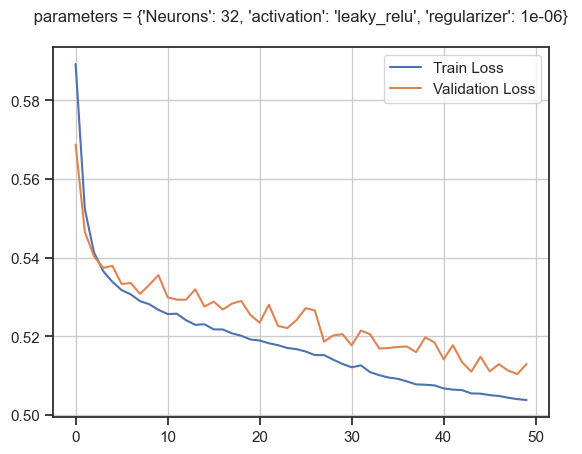

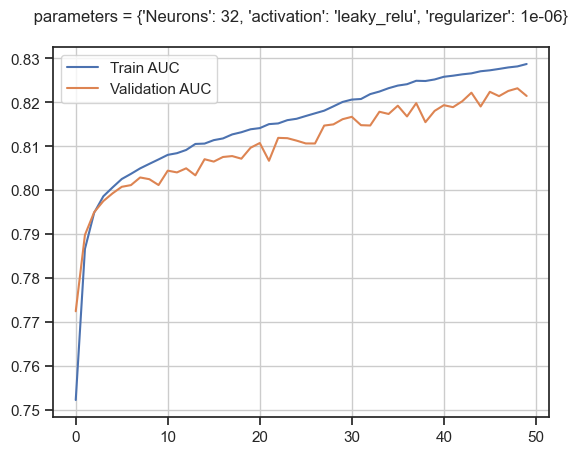

1095/1095 [==============================] - 1s 1ms/step
Accuracy: 0.7364467295058554
Precision: 0.7491878233666226
Recall (Sensitivity): 0.7111529895494261
F1-Score: 0.7296750944833446
ROC-AUC: 0.8214723473482771
Confusion Matrix:
[[13330  4169]
 [ 5058 12453]]


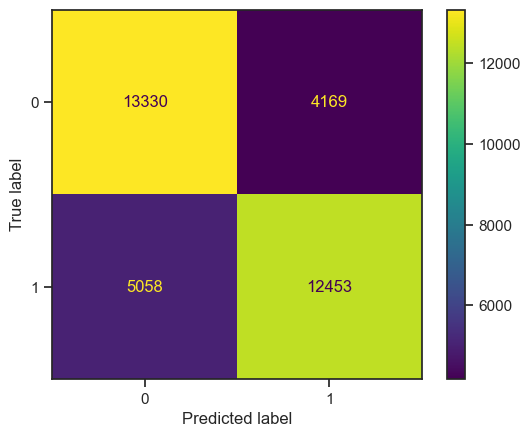

 ###  .. processing parameters = {'Neurons': 32, 'activation': 'leaky_relu', 'regularizer': 1e-05} ..  ## 


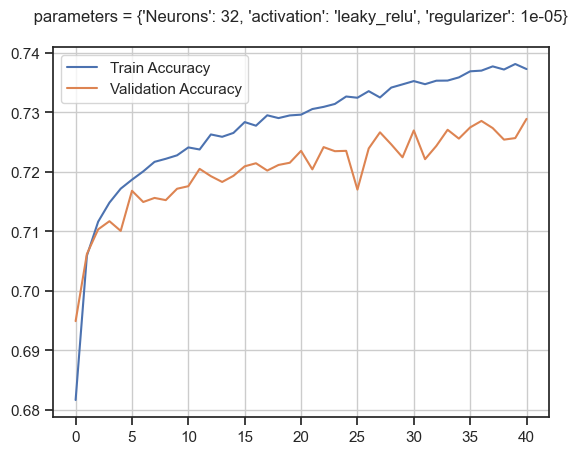

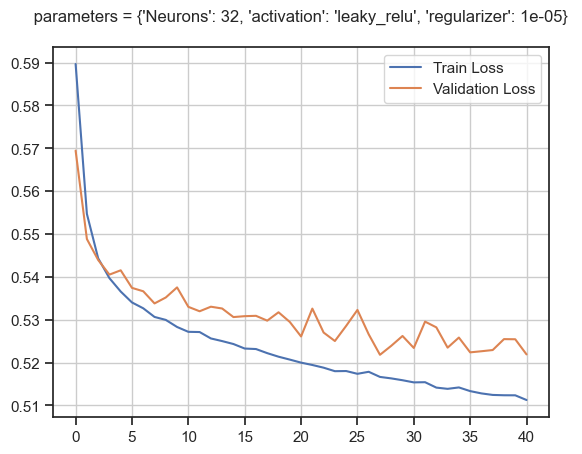

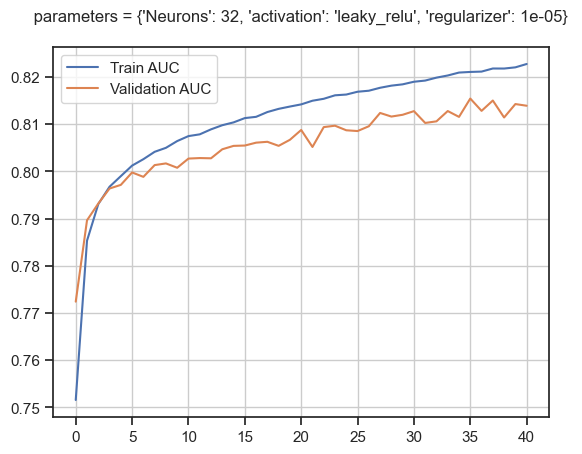

1095/1095 [==============================] - 1s 1ms/step
Accuracy: 0.7274493001999429
Precision: 0.6996342502129366
Recall (Sensitivity): 0.7974416081320312
F1-Score: 0.7453429410194823
ROC-AUC: 0.8154403066650677
Confusion Matrix:
[[11504  5995]
 [ 3547 13964]]


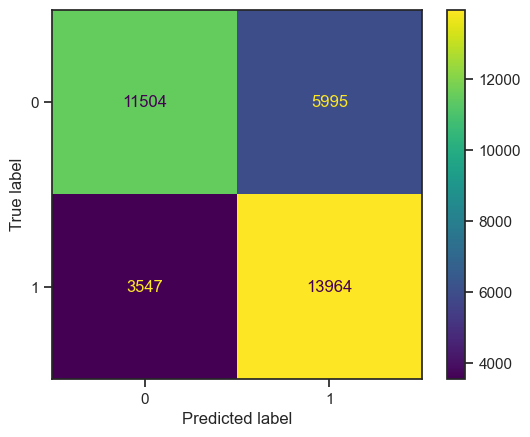

 ###  .. processing parameters = {'Neurons': 32, 'activation': 'leaky_relu', 'regularizer': 0.0001} ..  ## 


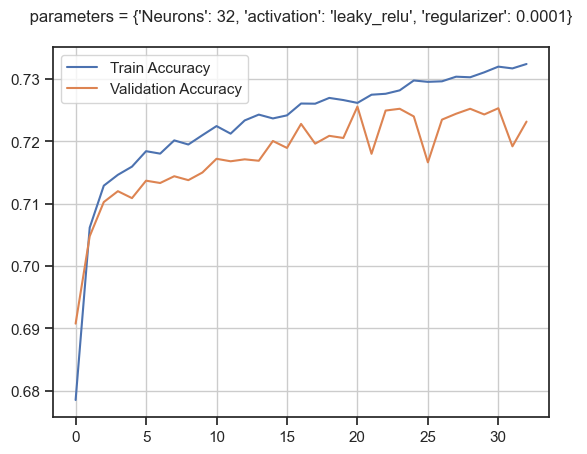

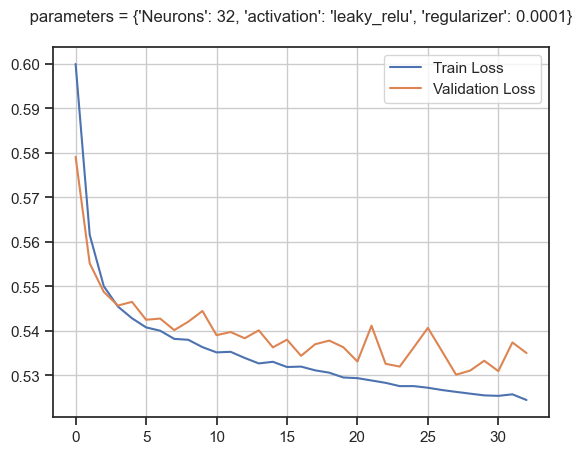

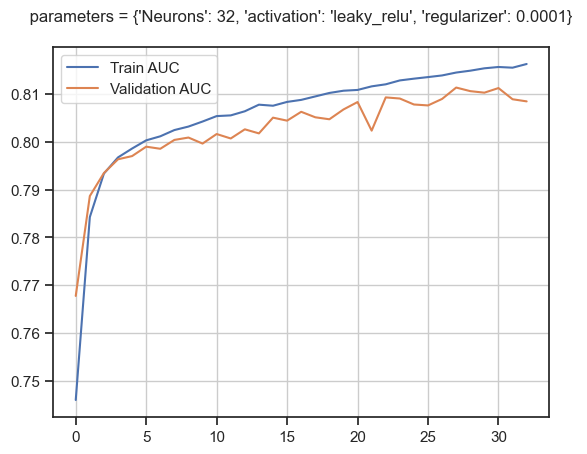

1095/1095 [==============================] - 1s 1ms/step
Accuracy: 0.7244215938303342
Precision: 0.7040112085517098
Recall (Sensitivity): 0.7747701444806122
F1-Score: 0.7376977869610135
ROC-AUC: 0.811319683199858
Confusion Matrix:
[[11795  5704]
 [ 3944 13567]]


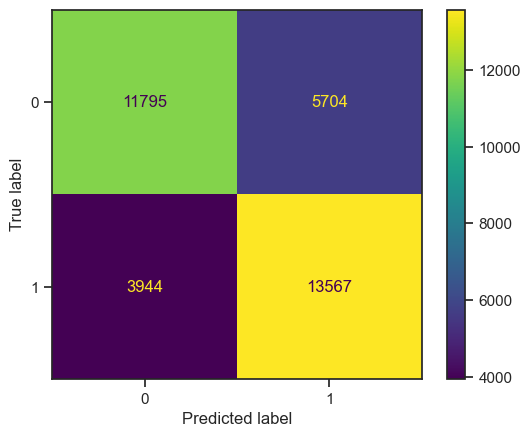

param  \
0          {'Neurons': 8, 'activation': 'relu', 'regularizer': 1e-06}   
0          {'Neurons': 8, 'activation': 'relu', 'regularizer': 1e-05}   
0         {'Neurons': 8, 'activation': 'relu', 'regularizer': 0.0001}   
0    {'Neurons': 8, 'activation': 'leaky_relu', 'regularizer': 1e-06}   
0    {'Neurons': 8, 'activation': 'leaky_relu', 'regularizer': 1e-05}   
0   {'Neurons': 8, 'activation': 'leaky_relu', 'regularizer': 0.0001}   
0         {'Neurons': 16, 'activation': 'relu', 'regularizer': 1e-06}   
0         {'Neurons': 16, 'activation': 'relu', 'regularizer': 1e-05}   
0        {'Neurons': 16, 'activation': 'relu', 'regularizer': 0.0001}   
0   {'Neurons': 16, 'activation': 'leaky_relu', 'regularizer': 1e-06}   
0   {'Neurons': 16, 'activation': 'leaky_relu', 'regularizer': 1e-05}   
0  {'Neurons': 16, 'activation': 'leaky_relu', 'regularizer': 0.0001}   
0         {'Neurons': 32, 'activation': 'relu', 'regularizer': 1e-06}   
0         {'Neurons': 32, 'activation': 'relu', 'regularizer': 1e-05}   
0        {'Neurons': 32, 'activation': 'relu', 'regularizer': 0.0001}   
0   {'Neurons': 32, 'activation': 'leaky_relu', 'regularizer': 1e-06}   
0   {'Neurons': 32, 'activation': 'leaky_relu', 'regularizer': 1e-05}   
0  {'Neurons': 32, 'activation': 'leaky_relu', 'regularizer': 0.0001}   

   Neurons  Activation  Regularizer_L2_value  Train_AUC  Test_AUC  
0        8        relu                  0.00       0.80      0.79  
0        8        relu                  0.00       0.80      0.80  
0        8        relu                  0.00       0.80      0.79  
0        8  leaky_relu                  0.00       0.80      0.79  
0        8  leaky_relu                  0.00       0.80      0.79  
0        8  leaky_relu                  0.00       0.80      0.79  
0       16        relu                  0.00       0.82      0.81  
0       16        relu                  0.00       0.82      0.82  
0       16        relu                  0.00       0.84      0.84  
0       16  leaky_relu                  0.00       0.81      0.80  
0       16  leaky_relu                  0.00       0.81      0.81  
0       16  leaky_relu                  0.00       0.81      0.80  
0       32        relu                  0.00       0.85      0.84  
0       32        relu                  0.00       0.83      0.82  
0       32        relu                  0.00       0.82      0.81  
0       32  leaky_relu                  0.00       0.83      0.82  
0       32  leaky_relu                  0.00       0.83      0.82  
0       32  leaky_relu                  0.00       0.82      0.81

In [ ]:
# standard scikit-learn libraries for metric evaluations
from sklearn.metrics import roc_auc_score

# bespoke library to perform model evaluations reporting
from model_evaluations import model_evaluation_report_classification

# Keras, our Deep Learning python packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Setting seed randomness to produce the same results each run
from tensorflow.config.experimental import enable_op_determinism
from keras.utils import set_random_seed
enable_op_determinism()
set_random_seed(1)

# Weight decay regularization, to prevent overfitting
from keras.regularizers import l2

# For early stopping incase the model performance declines
from keras.callbacks import EarlyStopping

# Data-splitting
# Split the data into training and testing sets by 80/20
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=42)

print("Shape of X, y train test datasets :")
for dframe, dlabel in zip([X_train_3, X_test_3, y_train_3, y_test_3], ['X_train', 'X_test', 'y_train', 'y_test']):
    print(f"Shape of {dlabel}: {dframe.shape}")

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_auc',  # Evaluation metric to watch 
    mode='max',
    patience=5,               # Stop if no improvement after <X> epochs
    restore_best_weights=True  # Restore the model weights at the best epoch
)

# List to store dataframes of parameters and AUC scoring metric
df_list = []

# Range of parameters to evaluate
from itertools import product

# parameter dictionary to loop though
params = {
    'Neurons' : [8,16,32],
    'activation' : ['relu', 'leaky_relu'],
    'regularizer' : [1e-6, 1e-5, 1e-4]
}

keys, values = zip(*params.items())
result = [dict(zip(keys, p)) for p in product(*values)]

# Loop over each depth
for param in result:

    print(f" ###  .. processing parameters = {param} ..  ## ")

    # Initialize the model (empty intiially)
    model_3_test = Sequential()

    # Initialize Decision Tree with the current max depth
    model_3_test.add(Dense(param['Neurons'], input_dim=X_3.shape[1], activation=param['activation'], kernel_regularizer=l2(param['regularizer'])))

    # smaller brain part that processes what the first layer has figured out.
    # Using Half the unit_size from previous Dense Layer
    model_3_test.add(Dense(int(param['Neurons']/2), activation=param['activation'], kernel_regularizer=l2(param['regularizer'])))

    #This is like the brain's decision-making part, where it makes a yes/no decision (like "Will this person pay back their loan?").
    model_3_test.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model_3_test.compile(
        optimizer= 'adam', #adam, # like the brain’s coach, guiding it to get better and better at its task
        loss='binary_crossentropy', # how the brain measures its mistakes,  for optimisation
        metrics=['accuracy', 'Precision', 'Recall', 'AUC']
        )
    
    # Train with early stopping
    history_test = model_3_test.fit(
        X_train_3, y_train_3,
        validation_data=(X_test_3, y_test_3),
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
        )

    
    plot_training_vs_overfitting(history_test,f" parameters = {param} \n")

    
    # Predict probabilities for the ROC AUC calculation
    y_train_prob_3 = history_test.model.predict(X_train_3)
    y_train_pred_3 = (y_train_prob_3 >= 0.5)
    
    y_test_prob_3 = history_test.model.predict(X_test_3)
    y_test_pred_3 = (y_test_prob_3 >= 0.5)

    model_evaluation_report_classification(X_test_3, y_test_3, y_test_pred_3, y_test_prob_3)

    train_auc = roc_auc_score(y_train_3, y_train_prob_3)
    test_auc = roc_auc_score(y_test_3, y_test_prob_3)


    df_list.append(
        pd.DataFrame({
        'param' : [param],
        'Neurons' : [param['Neurons']],
        'Activation' : [param['activation']],
        'Regularizer_L2_value' : [param['regularizer']],
        'Train_AUC' : [train_auc],
        'Test_AUC' : [test_auc]
        })
    )



df_test_nn_param_full = pd.concat(df_list)

df_test_nn_param_full
    

### Observation

- After multiple iterations via the suite of parameters, we select the Champion paramters based on the observations of the following ;
    - **Test_AUC & Train_AUC** scores
    - **Loss vs Val_Loss** plots
    - **Accuracy vs Val_Accuracy** plots
    - **AUC vs Val_AUC** plots

- With prevention of overffitting due to the L2_regularizer, and inspecting every 5 epochs for 50 epochs, the Champion parameters are:

- `Neurons`: 32, 
- `activation` : 'relu', 
- `L2_regularizer` : 1e-6
	
- When we inspect the other plots, which compare [accuracy, loss, auc] by implementing EarlyStopping to prevent overfits, we see the parameters mentioned performs the overall best, showing signs to improve more with more epochs.

- To build our final `model_3`, we will use 32 first layer (16 second layer), and we will run it over 100 epochs, and inspect after every 10 with EarlyStopping to avoid overfitting, with a batch_size=64.

## Build final `model_3` .. the Challenger.!
- Includes:
    - Using best parameters sources, evaluated from previous cell.
    - Train, fit on 100 epochs, EarlyStopping by 10 if no improvements
    - Make predictions
    - Assess probability values distribution 

Shape of X, y train test datasets :
Shape of X_train: (140036, 33)
Shape of X_test: (35010, 33)
Shape of y_train: (140036,)
Shape of y_test: (35010,)


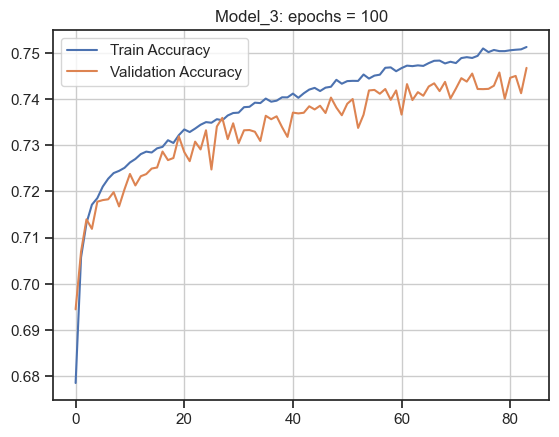

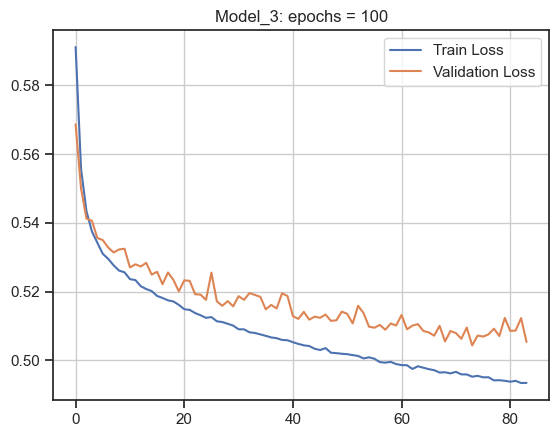

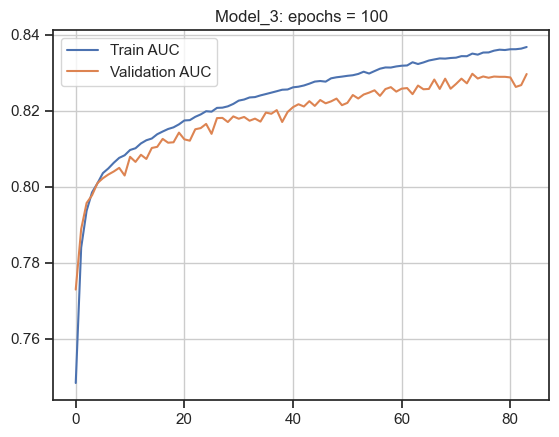

In [12]:
# Build final model_3

# Data-splitting
# Split the data into training and testing sets by 80/20
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=42)

print("Shape of X, y train test datasets :")
for dframe, dlabel in zip([X_train_3, X_test_3, y_train_3, y_test_3], ['X_train', 'X_test', 'y_train', 'y_test']):
    print(f"Shape of {dlabel}: {dframe.shape}")

# Initialize the model (empty intiially)
model_3 = Sequential()

# Neurons
neuron = 32

# Initialize Decision Tree with the current max depth
model_3.add(Dense(neuron, input_dim=X_3.shape[1], activation='relu' , kernel_regularizer=l2(1e-6)))

# smaller brain part that processes what the first layer has figured out.
# Using Half the unit_size from previous Dense Layer
model_3.add(Dense(int(neuron/2), activation='relu' , kernel_regularizer=l2(1e-6)))

#This is like the brain's decision-making part, where it makes a yes/no decision (like "Will this person pay back their loan?").
model_3.add(Dense(1, activation='sigmoid'))


# Compile the model
model_3.compile(
    optimizer= 'adam', # like the brain’s coach, guiding it to get better and better at its task
    loss='binary_crossentropy', # how the brain measures its mistakes,  for optimisation
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
    )

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_auc',  # Evaluation metric to watch
    mode='max',
    patience=10,               # Stop if no improvement after <X> epochs
    restore_best_weights=True  # Restore the model weights at the best epoch
)

# Fit the model on training data
# Train with early stopping
history = model_3.fit(
    X_train_3, y_train_3,
    validation_data=(X_test_3, y_test_3),
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

plot_training_vs_overfitting(history, 'Model_3: epochs = 100')


### Observation
- We can see with increasing epochs, and inspecting after every 10 epochs, we gradually get to better fitted AUC scores, however, it results in divergence leading to overfitting.

1095/1095 [==============================] - 1s 913us/step


count   35010.00
mean        0.49
std         0.29
min         0.00
0%          0.00
1%          0.01
10%         0.09
25%         0.25
50%         0.49
75%         0.72
90%         0.89
95%         1.00
99%         1.00
100%        1.00
max         1.00
Name: prob, dtype: float64

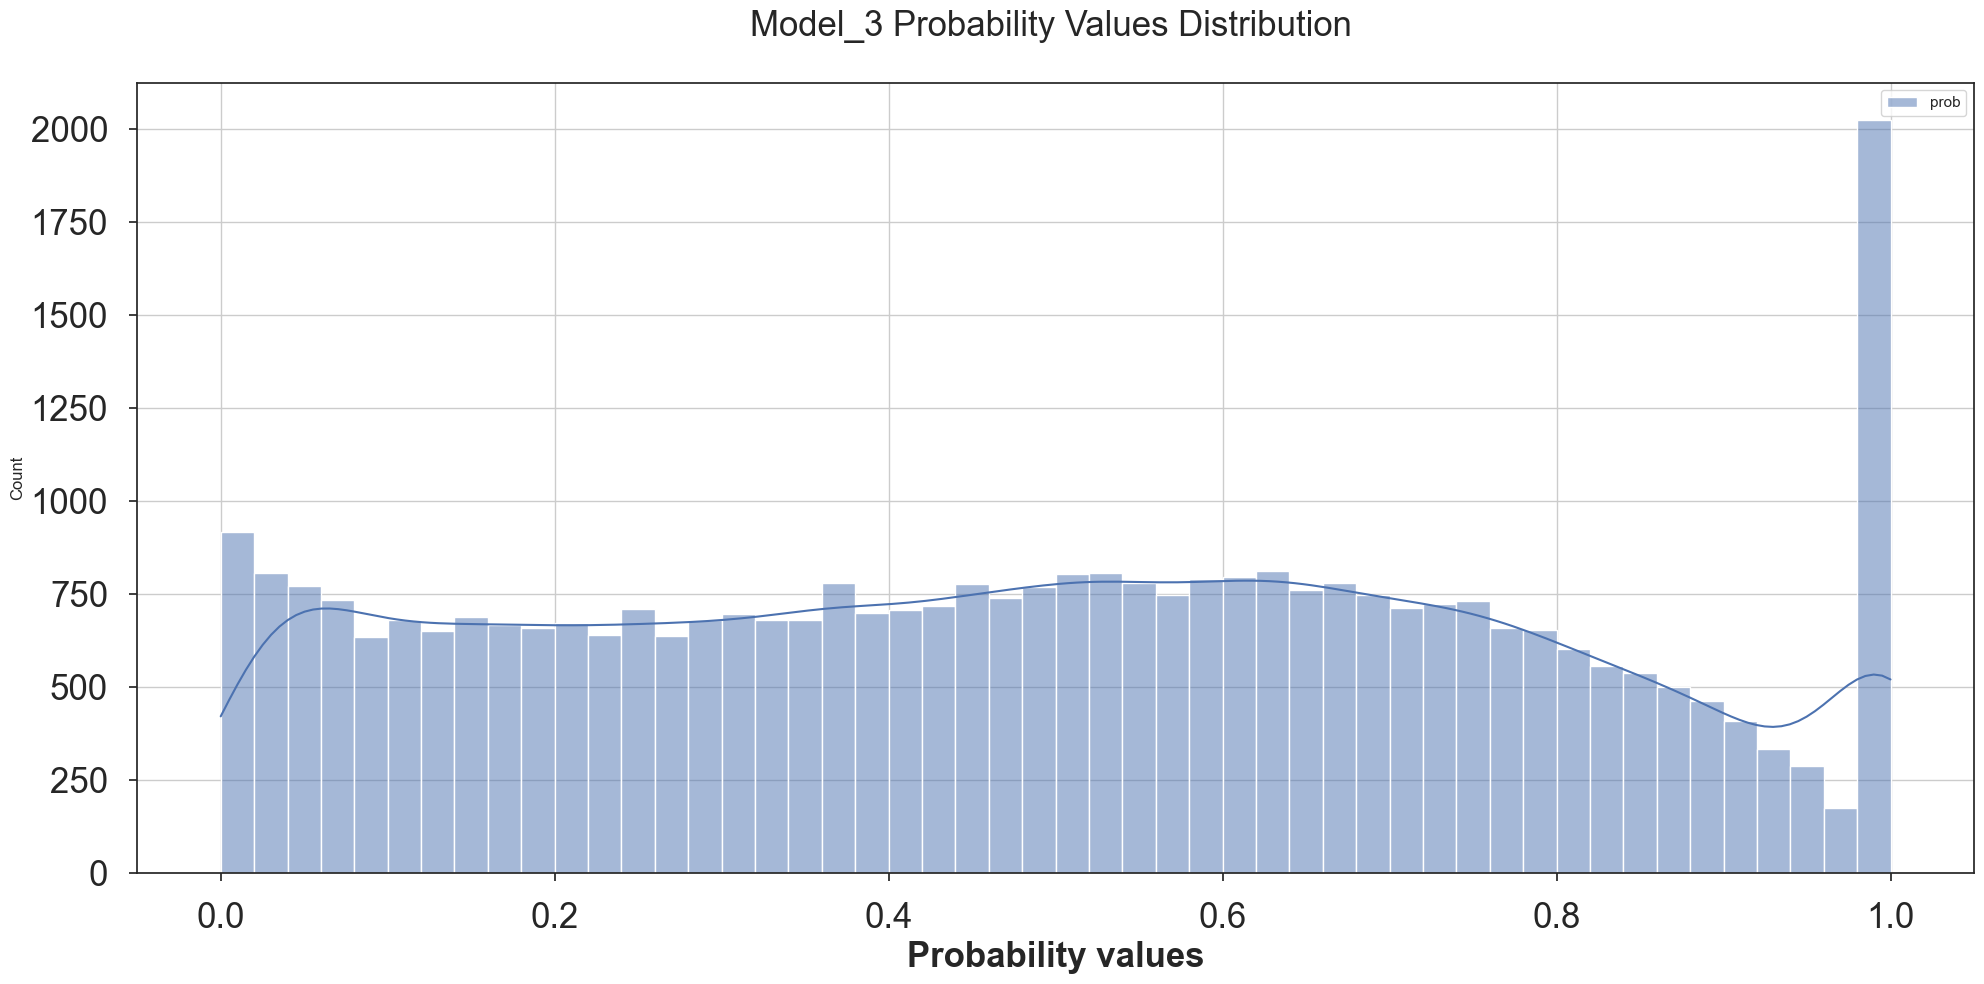

In [13]:
# Make predictions based of the 'fitted' model_3, which was prevented from overfitting

y_prob_3 = history.model.predict(X_test_3)
y_pred_3 = (y_prob_3 >= 0.5)

# Set float format to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

df_y_prob_3 = pd.DataFrame(y_prob_3 , columns=["prob"])
display(df_y_prob_3.prob.describe(percentiles = [round(i / 100 , 2) for i in [0, 1, 10, 25, 50, 75, 90, 95, 99, 100]]))



import seaborn as sns

# Residual difference between Actual Values Predicted Values
plt.figure(figsize=(20,10))
sns.set(style="ticks")
sns.histplot(df_y_prob_3, kde=True, bins=50)
plt.xlabel('Counts' , fontsize=25 , weight='bold')
plt.xlabel('Probability values' , fontsize=25 , weight='bold')
plt.title("Model_3 Probability Values Distribution \n" , fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25, pad=15)
plt.grid(True)
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.tight_layout()
plt.show()

### Observation
- We have a bimodal to uniform (wide-spread) distribution of probability values, with two peaks near 0 and 1.

- This indicates the model is making confident predictions, but with some struggles with a subset of data points; however entails the model is struggling to confidently classify this subset of data points and is instead producing a significant number of predictions near the two peaks.

- Potentially signifying a problem with data separation or model complexity.

- Based on the **key points** below, there is a positive interpretation that the model is generally making confident predictions, with a struggle on a subset of data points. Improvements are mainly focused on the feature selection & engineering, in combination with a slight model tuning. 

---
**Key points to consider:**
- Data separation issues:
    - A bimodal distribution could mean the data is not well separated, meaning there are large overlaps between the features of the positive and negative classes, making it difficult for the model to confidently classify instances.

- Model complexity:
    - A model that is too complex for the data can sometimes lead to overfitting, causing it to learn noise in the data and produce extreme probability predictions, resulting in two peaks. 

- Interpretation:
    - **Positive:** If the two peaks are located near 0 and 1, it could indicate that the model is generally making confident predictions, even if it struggles with a subset of data points. 

    - **Negative:** If the peaks are located away from 0 and 1, it suggests the model is often uncertain about its predictions, potentially indicating a need for feature engineering or model tuning. 

---
# 4. Model Comparisons
- Model evaluation metrics
- ROC_AUC curve plot
- Conclusion [advtangaes, disadvtages between models]

 
 ... Evaluation Metrics for model ... 
Accuracy: 0.87835
Precision: 0.0
Recall (Sensitivity): 0.0
F1-Score: 0.0
ROC-AUC: 0.6173932969589436
Confusion Matrix:
[[17567     0]
 [ 2433     0]]


c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


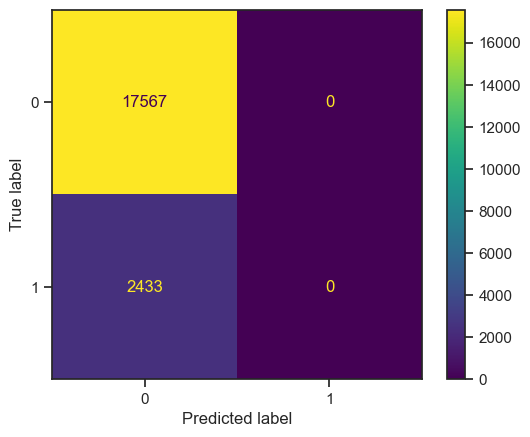

 
 ... Evaluation Metrics for model_2 ... 
Accuracy: 0.8824050271351043
Precision: 0.9136504014823965
Recall (Sensitivity): 0.8447261721203815
F1-Score: 0.8778374528945728
ROC-AUC: 0.9470188379447083
Confusion Matrix:
[[16101  1398]
 [ 2719 14792]]


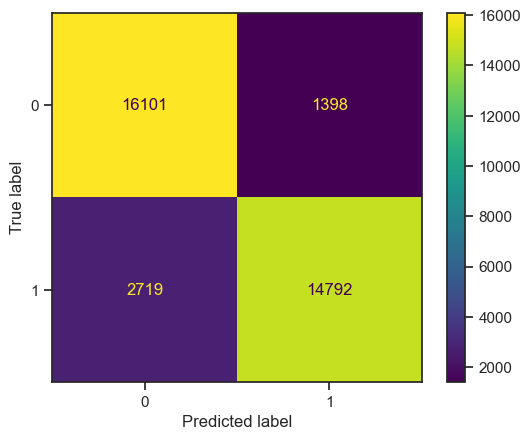

 
 ... Evaluation Metrics for model_3 ... 
Accuracy: 0.7455298486146815
Precision: 0.7500290663876293
Recall (Sensitivity): 0.7367940151904517
F1-Score: 0.7433526344597124
ROC-AUC: 0.8297208848068198
Confusion Matrix:
[[13199  4300]
 [ 4609 12902]]


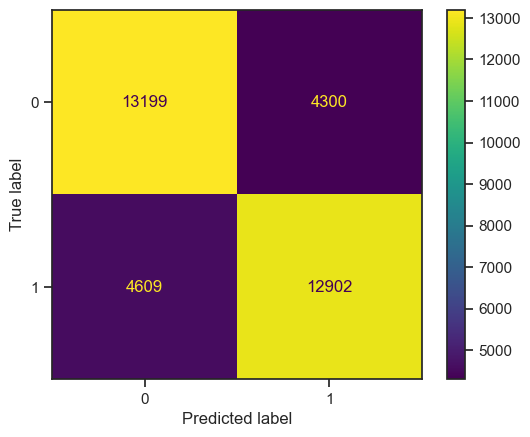


  ... Confusion Matrix for reference  ... 


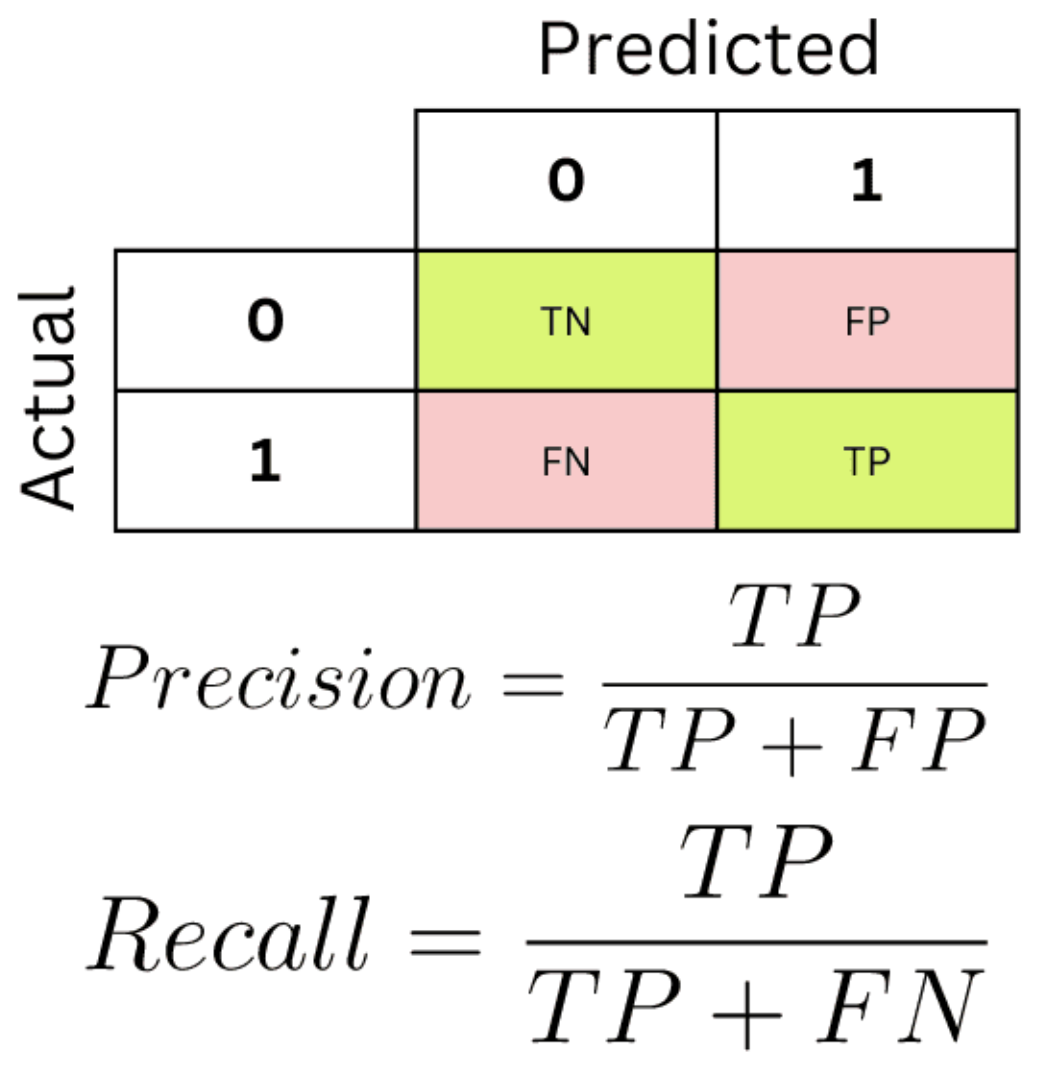

In [14]:
from model_evaluations import model_evaluation_report_classification

print(" \n ... Evaluation Metrics for model ... ")
model_evaluation_report_classification(X_test, y_test, y_pred, y_prob)

print(" \n ... Evaluation Metrics for model_2 ... ")
model_evaluation_report_classification(X_test_2, y_test_2, y_pred_2, y_prob_2)

print(" \n ... Evaluation Metrics for model_3 ... ")
model_evaluation_report_classification(X_test_3, y_test_3, y_pred_3, y_prob_3)

from IPython.display import Image
print("\n  ... Confusion Matrix for reference  ... ")
Image(filename=f"{path_python_material}/images/confusion_matrix_v2.png", width=500,)

### Observation

- **TN** = predicted[0], Actual[0] = loan_default False when it is actually False
- **TP** = predicted[1], Actual[1] = loan_default True when it is actually True
- **FP** = predicted[1], Actual[0] = loan default True when it is actually False
- **FN** = predicted[0], Actual[1] = loan default False when it is actually True

- **Legacy model**
    - We can see from the confusion matrix (Top-Left = TN), it achieves a high number ~17500 in predicting these correctly (i.e., loan_default = False when it is actually False). 

    - However, it performs terribily in predicting (Bottom-right = TP) (i.e., loan_defaults = True when it is actually True) where it predicted a total of zero.
    
    - As for the (Top-Right = FP), also predicted a total of zero, which makes sense as it predicted a high number of TN, 
    
    - As for the (Bottom-Left = FN), it predicted ~2400 records to have loan_defaults=False when they were actually True.
    
    - Hence Precision and Recall = 0, due to number of TP = 0, resulting ROC_AUC score ~ 62%, entails it will distinguish between loan_defaults [True, False] 62% of the time.

- **New model_2**
    - We can see from the confusion matrix (Top-Left = TN), it achieves a high number ~ 16000 in predicting these correctly (i.e., loan_default = False when it is actually False). 

    - However, it performs very well in predicting (Bottom-right = TP) (i.e., loan_defaults = True when it is actually True) where it predicted a total of ~ 14700.
    
    - As for the (Top-Right = FP), it predicted a total of ~1400 (~ <10% of the TN and TP) 
    
    - As for the (Bottom-Left = FN), it predicted ~2700 records to have loan_defaults=False when they were actually True.
    
    - Hence Precision = 91% and Recall (Sensitivity) =81% , resulting ROC_AUC score ~ 94%, entails it will distinguish between loan_defaults [True, False] 94% of the time.

- **Challenger model_3**
    - We can see from the confusion matrix (Top-Left = TN), it achieves a high number ~ 13200 in predicting these correctly (i.e., loan_default = False when it is actually False). 

    - However, it performs very well in predicting (Bottom-right = TP) (i.e., loan_defaults = True when it is actually True) where it predicted a total of ~ 12900.
    
    - As for the (Top-Right = FP), it predicted a total of ~ 4300 
    
    - As for the (Bottom-Left = FN), it predicted ~ 4600 records to have loan_defaults=False when they were actually True.
    
    - Hence Precision = 75% and Recall (Sensitivity) = 75% , resulting ROC_AUC score ~ 83%, entails it will distinguish between loan_defaults [True, False] 83% of the time.

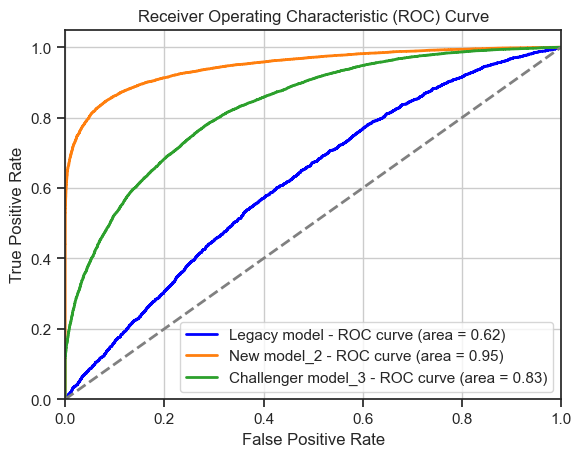

Legacy model - ROC AUC Score: 0.62
New model_2 - ROC AUC Score: 0.95
Challenger model_3 - ROC AUC Score: 0.83


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Compute ROC curve and ROC AUC

# - Legacy model 'balanced
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# - New model_2 
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test_2, y_prob_2)
roc_auc_2 = auc(fpr_2, tpr_2)

# - New model_3 
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test_3, y_prob_3)
roc_auc_3 = auc(fpr_3, tpr_3)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Legacy model - ROC curve (area = {roc_auc:.2f})')
plt.plot(fpr_2, tpr_2, color='#ff7f0e', lw=2, label=f'New model_2 - ROC curve (area = {roc_auc_2:.2f})')
plt.plot(fpr_3, tpr_3, color='#2ca02c', lw=2, label=f'Challenger model_3 - ROC curve (area = {roc_auc_3:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random prediction)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Additional stats
print(f'Legacy model - ROC AUC Score: {roc_auc_score(y_test, y_prob):.2f}')

# Additional stats
print(f'New model_2 - ROC AUC Score: {roc_auc_score(y_test_2, y_prob_2):.2f}')

# Additional stats
print(f'Challenger model_3 - ROC AUC Score: {roc_auc_score(y_test_3, y_prob_3):.2f}')



---
# Conclude

- After many iterations of finding the ideal number of neurons, and performing EarlyStopping to prevent overfitting, we see the Deep Learning model tends to remain with ROC_AUC score ~ 80%

- Steps that can be taken for the Deep Learning model to improve are;
    - Be more selective of features (Categorical encoded features can potenitally bring too much sparsity to the preprocessed data for the model)
    - To try Activation models that are more computationally expensive, but have higher accuracy, (will require to utilise EarlyStopping)
    - Finally, To have much more/larger dataset for the Deep Learning model_3 to train on.

- The Champion model still remains as `model_2`, which is built off the highly accurate Ensemble XGBoostClassifier with finetuned parameters.

- `model` ~ LogisticRegression:
    - Advantages : Very simple, quick, efficient model to implement and train, and a great starting point for building a new model to solve a business problem to meet KPIs/ OKRs and to give insight on outcomes, before building and replacing it with a more sophisticated model.
    - Disadvantages : It assumes linearity between the input variables and target, hence it cannot solve for non-linear problems and complex datasets, which is not ideal for real-world problems

- Champion `model_2` ~ Ensemble XGBClassifier:
    - Advantages : Highly accurate especially when dealing with non-linear complex datasets. It can efficiently handle missing missing values and outliers, and scales well with large datasets. Also provides feature importance scores for interpretability.
    - Disadvantages : It requires careful parameter finetuning to achieving opitmal performance, and it is prone to overfitting, if not properly regularized. It is computationally expensive especially dealing with large datasets, and interpreting the model can be challenging.

- Challenger `model_3` ~ Deep Learning Leaky_ReLU->Leaky_ReLU->Sigmoid:
    - Advantages : Automatic Feature Learning & Engineering (can learn about the relevant features to use automatically), which is ideal for very complex non-linear datasets. With large amounts of data and complexity of data it becomes highly accurate, and ideal for large scale applications due to better performance with increasing data samples.
    - Disadvantages : Very high computational costs, takes a very long time to finetune especially if we are trying to avoid overfitting. It relies on large amounts of data, and can be quite difficult to interpret their decision making.

---
# 5. (Optional) model profiling with SHAP/LIME/SHAPASH

- Using SHAPASH on the Champion Ensemble `model_2` 
    - *(Please see this example, as SHAP for DeepLearning Keras lead to issues of compatibility)*

- Using SHAP on the Challenger NN `model_3`
    - The set-up is ready for any plotting, but I had issues with Tensflow -> SHAP compatibility when trying to use shap.DeepExplainer
    - Hence, faced issues in getting the values to be plotting into SHAP visuals
    - This is due to shap.DeepExplainer only uses np.array values from TensorFlow, which leads to not showing the features
    - the preferred python DeepLearning library, fully compatible is PyTorch

---

## Using SHAPASH on the Champion Ensemble `model_2`
(Intepretability that works.!)

In [100]:
from shapash import SmartExplainer

response_dict = {0: 'Loan Default = False', 1:' Loan Default = True'}

# Calling SmarExplainer to perform on `model_2`
xpl = SmartExplainer(model=model_2 , label_dict=response_dict)



# Compiling SmartExplainer on the testing data
xpl.compile(x=X_test_2[selected_features], 
            y_target=y_test_2.astype(int) # Optional: allows to display True Values vs Predicted Values
           )

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x0000020DB767BD00>


## **NOTE:** To generate a Web-app

In [91]:
# app = xpl.run_app(title_story='Loan Defaults', port=8020)
# app.kill()

## To generate a pandas dataFrame showng each record, each feature, their value and contribution to the target/prediction

In [101]:
xpl.to_pandas()

pred        feature_1 value_1 contribution_1  \
173255   Loan Default = True       annual_inc    0.04           0.92   
10507   Loan Default = False        loan_amnt    1.55           1.25   
94239   Loan Default = False       annual_inc   -0.14           0.86   
40749    Loan Default = True        loan_amnt    0.15           0.56   
36009   Loan Default = False   int_rate_clean    1.54           1.12   
...                      ...              ...     ...            ...   
35907   Loan Default = False  fico_range_high    0.13           0.87   
46522   Loan Default = False        loan_amnt   -0.14           0.76   
27784    Loan Default = True       annual_inc   -0.05           1.20   
44443   Loan Default = False   debt_to_income    0.04          -0.62   
161     Loan Default = False   debt_to_income   -0.06           1.25   

                       feature_2 value_2 contribution_2  \
173255            debt_to_income    0.05           0.74   
10507   purpose_home_improvement    True          -0.66   
94239                  loan_amnt   -0.03           0.78   
40749            fico_range_high   -0.91          -0.39   
36009                  loan_amnt   -0.03           0.68   
...                          ...     ...            ...   
35907             int_rate_clean   -0.96           0.82   
46522                 annual_inc   -0.23           0.73   
27784                  loan_amnt    0.92          -0.62   
44443                 annual_inc   -0.56           0.61   
161              fico_range_high   -1.05           0.76   

                         feature_3 value_3 contribution_3  \
173255               purpose_other    True           0.61   
10507              fico_range_high   -1.05           0.50   
94239              fico_range_high   -0.46           0.61   
40749               int_rate_clean    0.29           0.36   
36009              fico_range_high   -0.91           0.51   
...                            ...     ...            ...   
35907                    loan_amnt    0.92           0.82   
46522              fico_range_high    0.57           0.67   
27784               debt_to_income    0.02           0.55   
44443              fico_range_high   -0.46           0.59   
161     purpose_debt_consolidation   False           0.72   

                         feature_4 value_4 contribution_4  \
173255  purpose_debt_consolidation   False          -0.44   
10507               debt_to_income    0.05          -0.50   
94239               int_rate_clean   -0.31           0.27   
40749               debt_to_income    0.00           0.32   
36009                   annual_inc   -0.32           0.48   
...                            ...     ...            ...   
35907               debt_to_income   -0.02           0.27   
46522   purpose_debt_consolidation   False           0.61   
27784              fico_range_high    0.57          -0.40   
44443                    loan_amnt   -0.46           0.19   
161                     annual_inc   -0.40           0.43   

                         feature_5 value_5 contribution_5  \
173255              int_rate_clean   -0.24           0.37   
10507   purpose_debt_consolidation   False           0.39   
94239               debt_to_income   -0.01           0.19   
40749                   annual_inc   -0.17          -0.27   
36009               debt_to_income    0.01          -0.17   
...                            ...     ...            ...   
35907           total_rec_late_fee   -0.13           0.14   
46522               int_rate_clean   -1.04           0.53   
27784          home_ownership_RENT    True           0.21   
44443          home_ownership_RENT   False           0.17   
161                      loan_amnt   -1.30          -0.23   

                         feature_6 value_6 contribution_6  \
173255             fico_range_high    1.93          -0.36   
10507                   annual_inc   -0.07          -0.33   
94239           total_rec_late_fee   -0.13           0.18   
40749  

## To generate feature-importance chart (Interactive)

### Overall feature-importance for non-default loans

In [ ]:
xpl.plot.features_importance(label=response_dict[0])

### Comparing the overall dataset, semi-local, and local (micro-dataset) feature-importance for default loans:
- We can see on a local scale, 'total_rec_late_fee' has a large contribution, as well has those taking out a loan for home_improvements

- Other features indicate they are important both globally and locally

In [114]:
xpl.plot.features_importance(label=response_dict[1], mode='global-local' , zoom=True, max_features=10)

## Alternatives to a confusion-matrix, showing in both loan_defalt cases, the distribution of correct-to-wrong predictions

In [115]:
xpl.plot.scatter_plot_prediction(label=response_dict[1])

In [116]:
xpl.plot.scatter_plot_prediction(label=response_dict[0])

### Observation
- the wide-orange contours indicate the large distribution of points, hence we predict the majority correct..!!

---
# Generating a fully specified report, showing a suite of plots with documentation

In [117]:
import yaml

with open(f'{path_python_material}/reports/project_info.yml') as file:
    project_info = yaml.full_load(file)

print(yaml.dump(project_info, sort_keys=False))

General information:
  version: 0.7
  name: Loan Defaults Prediction Project
  purpose: Predicting if a loan is going to default or not
  date: auto
  contributors: Charalambos Pittordis
  description: This work is a data science project that tries to predict if an invidual
    receiving a loan is going to end up into a loan default or not based on multiple
    features related to loan_amount, annual_income, purpose of loan and home_ownership
    status.
  source code: TBC, on github
Dataset information:
  path: https://www.kaggle.com/datasets/wordsforthewise/lending-club
  origin: All Lending Club Loan Data
  description: 2007 through current Lending Club accepted and rejected loan data
  depth: from 2007 to current date
  perimeter: only residential sales
  target variable: loan_default
  target description: loan default = [True, False]
Data Preparation:
  variable filetring: All variables containing outliers and those that required special
    knowledge or previous calculations for 

In [118]:
xpl.generate_report(
    output_file=f'{path_python_material}/reports/LendingClub_LoanDefaults_Classifier_Report.html',
    project_info_file=f'{path_python_material}/reports/project_info.yml',
    x_train=X_train_2[selected_features],
    y_train=y_train_2.astype(int),
    y_test=y_test_2.astype(int),
    title_story="Loan Defaults Report",
    title_description="""This document is a data science report showing insights to features that can potentially lead to loan defaults.""",
    metrics=[
        {
            'path': 'sklearn.metrics.accuracy_score',
            'name': 'Accuracy',
        },
        {
            'path': 'sklearn.metrics.precision_score',
            'name': 'Precision',
        },
        {
            'path': 'sklearn.metrics.recall_score',
            'name': 'Recall',
        },
        {
            'path': 'sklearn.metrics.f1_score',
            'name': 'F1 Score',
        },
        {
            'path': 'sklearn.metrics.roc_auc_score',
            'name': 'ROC AUC',
        },
        {
            'path': 'sklearn.metrics.confusion_matrix',
            'name': 'Confusion Matrix',
        },
    ]
)

INFO:papermill:Input Notebook:  C:\Users\cpitt\anaconda3\envs\tf\Lib\site-packages\shapash\report\base_report.ipynb
INFO:papermill:Output Notebook: C:\Users\cpitt\AppData\Local\Temp\tmp12pee4cl\base_report.ipynb


Executing:   0%|          | 0/15 [00:00<?, ?cell/s]

INFO:papermill:Executing notebook with kernel: python3


---

# Using SHAP on the Challenger NN `model_3` (Not working on visuals, TensorFlow incompatability)

- The set-up is ready for any plotting, but I had issues with Tensflow -> SHAP compatibility when trying to use shap.DeepExplainer
- Hence, faced issues in getting the values to be plotting into SHAP visuals
- This is due to shap.DeepExplainer only uses np.array values from TensorFlow, which leads to not showing the features
- the preferred python DeepLearning library, fully compatible is PyTorch

In [15]:
import shap

# Initialize JS visualization
shap.initjs()

# A hack as shap does not contain handlers for leaky_relu
shap.explainers._deep.deep_tf.op_handlers["LeakyRelu"] = shap.explainers._deep.deep_tf.op_handlers["Relu"]

In [ ]:
# Initiating explainer
explainer = shap.DeepExplainer(model_3, X_train_3.to_numpy())

c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\shap\explainers\_deep\deep_tf.py:155: UserWarning: You have provided over 5k background samples! For better performance consider using smaller random sample.
  warnings.warn("You have provided over 5k background samples! For better performance consider using smaller random sample.")


In [ ]:
# Generate SHAP values on a random 200 sub_sample
X_test_3_sample = X_test_3.sample(200)
shap_values = explainer.shap_values(X_test_3_sample.to_numpy() )


c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [2]:
import pandas as pd
from category_encoders import OrdinalEncoder
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

from shapash.data.data_loader import data_loading
house_df, house_dict = data_loading('house_prices')

y_df=house_df['SalePrice'].to_frame()
X_df=house_df[house_df.columns.difference(['SalePrice'])]

house_df.shape

house_df.head()

from category_encoders import OrdinalEncoder

categorical_features = [col for col in X_df.columns if X_df[col].dtype == 'object']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(X_df)

X_df=encoder.transform(X_df)

Xtrain, Xtest, ytrain, ytest = train_test_split(X_df, y_df, train_size=0.75, random_state=1)

regressor = LGBMRegressor(n_estimators=100).fit(Xtrain,ytrain)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2986
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 66
[LightGBM] [Info] Start training from score 182319.757078


In [3]:
from shapash import SmartExplainer

xpl = SmartExplainer(
    model=regressor,
    preprocessing=encoder,   # Optional: compile step can use inverse_transform method
    features_dict=house_dict # optional parameter, specifies label for features name
)

xpl.compile(x=Xtest,
            y_target=ytest # Optional: allows to display True Values vs Predicted Values
           )

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x000001F65CB9D630>


In [ ]:
app = xpl.run_app(title_story='House Prices', port=8020)

INFO:root:Your Shapash application run on http://DrCPittordisXPS:8020/
INFO:root:Use the method .kill() to down your app.


Exception in thread Thread-5 (<lambda>):
Traceback (most recent call last):
  File "c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\urllib3\connection.py", line 198, in _new_conn
    sock = connection.create_connection(
  File "c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    raise err
  File "c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
OSError: [WinError 10049] The requested address is not valid in its context

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\urllib3\connectionpool.py", line 787, in urlopen
    response = self._make_request(
  File "c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\urllib3\connectionpool.py", line 493, in _make_request
    conn.request(
  File "c:\Users\cpitt\anaconda3\envs\tf\lib\site

In [11]:
app.setName

<bound method Thread.setName of <CustomThread(Thread-5 (<lambda>), stopped 41468)>>

In [19]:
path_python_material = ".."

from sklearn.metrics import mean_absolute_error, mean_squared_error

import yaml
import os

#with open(f'{path_python_material}/reports/project_info_house.yml') as file:
#    project_info = yaml.full_load(file)

#print(yaml.dump(project_info, sort_keys=False))


xpl.generate_report(
        output_file=f'{path_python_material}/reports/report.html',
        project_info_file=f'{path_python_material}/reports/project_info_house.yml',
        x_train=Xtrain,
        y_train=ytrain,
        y_test=ytest,
        title_story="House prices report",
        title_description="""This document is a data science report of the kaggle house prices tutorial project.
            It was generated using the Shapash library.""",
        metrics=[
            {
                "path": "sklearn.metrics.mean_absolute_error",
                "name": "Mean absolute error",
            },
            {
                "path": "sklearn.metrics.mean_squared_error",
                "name": "Mean squared error",
            },
        ],
    )

INFO:papermill:Input Notebook:  C:\Users\cpitt\anaconda3\envs\tf\Lib\site-packages\shapash\report\base_report.ipynb
INFO:papermill:Output Notebook: C:\Users\cpitt\AppData\Local\Temp\tmpj7_id2ed\base_report.ipynb


Executing:   0%|          | 0/15 [00:00<?, ?cell/s]

INFO:papermill:Executing notebook with kernel: python3


PapermillExecutionError: 
---------------------------------------------------------------------------
Exception encountered at "In [7]":
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[7], line 1
----> 1 report.display_model_analysis()

File c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\shapash\report\project_report.py:238, in ProjectReport.display_model_analysis(self)
    235 print_md(f"**Library :** {self.explainer.model.__class__.__module__}")
    237 for _, module in sorted(sys.modules.items()):
--> 238     module_name = module.__name__.split(".")[0]
    239     if self.explainer.model.__class__.__module__.split(".")[0] == module_name:
    240         try:

AttributeError: 'CythonDotParallel' object has no attribute '__name__'


In [ ]:
xpl.plot.features_importance()

In [21]:
house_df

MSSubClass                 MSZoning  LotArea  \
Id                                                                        
1                2-Story 1946 & Newer  Residential Low Density     8450   
2     1-Story 1946 & Newer All Styles  Residential Low Density     9600   
3                2-Story 1946 & Newer  Residential Low Density    11250   
4                2-Story 1945 & Older  Residential Low Density     9550   
5                2-Story 1946 & Newer  Residential Low Density    14260   
...                               ...                      ...      ...   
1456             2-Story 1946 & Newer  Residential Low Density     7917   
1457  1-Story 1946 & Newer All Styles  Residential Low Density    13175   
1458             2-Story 1945 & Older  Residential Low Density     9042   
1459  1-Story 1946 & Newer All Styles  Residential Low Density     9717   
1460  1-Story 1946 & Newer All Styles  Residential Low Density     9937   

     Street            LotShape      LandContour  \
Id                                                 
1     Paved             Regular  Near Flat/Level   
2     Paved             Regular  Near Flat/Level   
3     Paved  Slightly irregular  Near Flat/Level   
4     Paved  Slightly irregular  Near Flat/Level   
5     Paved  Slightly irregular  Near Flat/Level   
...     ...                 ...              ...   
1456  Paved             Regular  Near Flat/Level   
1457  Paved             Regular  Near Flat/Level   
1458  Paved             Regular  Near Flat/Level   
1459  Paved             Regular  Near Flat/Level   
1460  Paved             Regular  Near Flat/Level   

                             Utilities                        LotConfig  \
Id                                                                        
1     All public Utilities (E,G,W,& S)                       Inside lot   
2     All public Utilities (E,G,W,& S)  Frontage on 2 sides of property   
3     All public Utilities (E,G,W,& S)                       Inside lot   
4     All public Utilities (E,G,W,& S)                       Corner lot   
5     All public Utilities (E,G,W,& S)  Frontage on 2 sides of property   
...                                ...                              ...   
1456  All public Utilities (E,G,W,& S)                       Inside lot   
1457  All public Utilities (E,G,W,& S)                       Inside lot   
1458  All public Utilities (E,G,W,& S)                       Inside lot   
1459  All public Utilities (E,G,W,& S)                       Inside lot   
1460  All public Utilities (E,G,W,& S)                       Inside lot   

         LandSlope    Neighborhood  ... EnclosedPorch 3SsnPorch ScreenPorch  \
Id                                  ...                                       
1     Gentle slope   College Creek  ...             0         0           0   
2     Gentle slope         Veenker  ...             0         0           0   
3     Gentle slope   College Creek  ...             0         0           0   
4     Gentle slope        Crawford  ...           272         0           0   
5     Gentle slope      Northridge  ...             0         0           0   
...            ...             ...  ...           ...       ...         ...   
1456  Gentle slope         Gilbert  ...             0         0           0   
1457  Gentle slope  Northwest Ames  ...             0         0           0   
1458  Gentle slope        Crawford  ...             0         0           0   
1459  Gentle slope      North Ames  ...           112         0           0   
1460  Gentle slope         Edwards  ...             0         0           0   

     PoolArea  MiscVal  MoSold  YrSold                      SaleType  \
Id                                                                     
1           0        0       2    2008  Warranty Deed - Conventional   
2           0        0       5    2007  Warranty Deed - Conventional   
3           0        0       9    2008  Warranty Deed - Conventional   
4         